# AtaxxZero
## This algorithm tried to reimplement AlphaGo Zero for Ataxx
## however, the computation to train an AI from scratch can be too heavy, given my skills of code optimization and hardware limitation
## therefore, minor adjustments are made to the algorithms to make it plausible for this algorithm to give a rather satisfactory result in an acceptable period.

### modifications:
1. One major difference between AlphaGo Zero and Ataxx Zero is that Ataxx Zero relies __one engineered value function__. From the beginning of the training, the q value of each node is a combination of q from the hybrid network and a greedy function (output is monotone increasing with regard to difference of piece no. of each player).
2. Another major modification is Ataxx Zero apply MCTS to a __very shallow depth, currently being 3__. This change significantly reduce the searching time, thus accelerate training greatly.
3. The combination of 3 layer MCTS and an engineered value function guarantees a good performance of the algorithm in even before training, i.e. hybrid network output random probability and value. The behavior of Ataxx Zero before training should __resemble an impaired MinMax Searching with a depth of 3__. From a practical perspective, it wins 90% of the game with a greedy player(which attempts to maximize no.my_piece - no.opponent's_piece). With reinforcement learning, the algorithm is expected to behave better.
4. When actually applied in game, I plan to reduce the searching depth to 2 to further improve the speed, but expect the algorithm to work better than itself before training.

In [1]:
%load_ext Cython
from Cython.Compiler.Options import directive_scopes, directive_types
directive_types['linetrace'] = True
directive_types['binding'] = True

In [2]:
%load_ext line_profiler
import line_profiler

In [3]:
import os 
import importlib
import sys
import tensorflow as tf
import itertools
from multiprocessing import Queue, Pool, Process
import numpy as np
import numba as nb
from math import sqrt, log, exp
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape, Lambda
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply, Multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import keras.backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
#%matplotlib notebook

Using TensorFlow backend.


In [4]:
def set_keras_backend(backend):
    os.environ['KERAS_BACKEND'] = backend
    importlib.reload(K)
    K.set_image_dim_ordering('th')
    assert K.backend() == backend

def set_omp_threads(n):
    n = str(n)
    os.environ['OMP_NUM_THREADS'] = n

In [5]:
set_keras_backend('tensorflow')

Using TensorFlow backend.


In [6]:
def get_rot_policy_dict():
    augment_dict = {}
    rot_m_0 = np.array([[0, -1], [1, 0]]) 
    center = np.array([3, 3])
    for is_flip in [False, True]:
        for rot_time in range(4):
            if not (is_flip == False and rot_time == 0):
                tmp_dict = {}
                # get rot matrix
                rot_m = np.eye(2)
                for i in range(rot_time):
                    rot_m = rot_m_0.dot(rot_m)

                for r in range(7):
                    for c in range(7):
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                start = np.array([r, c])
                                end = np.array([r+dr, c+dc])
                                if (dr != 0 or dc != 0) and \
                                    (start[0] < 7 and start[0] >= 0) and (start[1] < 7 and start[1] >= 0):
                                    new_start = (start - center)
                                    new_end = (end - center)
                                    if is_flip:
                                        new_start[1] = -new_start[1]
                                        new_end[1] = -new_end[1]
                                    new_start = rot_m.dot(new_start) + center
                                    new_end = rot_m.dot(new_end) + center
                                    tmp_dict[(tuple(start), tuple(end))] = (tuple(new_start), tuple(new_end))
                augment_dict[(is_flip, rot_time)] = tmp_dict
    return augment_dict
augment_dict = get_rot_policy_dict()

In [7]:
def augment_policy(data, is_flip, rot_time):
    if is_flip == False and rot_time == 0:
        return data
    
    global policy_dict, policy_list, augment_dict
    out = np.zeros_like(data)
    for i in range(792):
        tmp_data = data[i]
        if tmp_data > 0:
            move = policy_list[i]
            move_after_rot = augment_dict[(is_flip, rot_time)][move]
            i_after_rot = policy_dict[move_after_rot]
            out[i_after_rot] = tmp_data
    return out
            
def augment_data(train_data):
    out = []
    # input is a list for follows
    feature_map = train_data[0]
    action_mask = train_data[1]
    frequency_map = train_data[2]
    value = train_data[3]
    
    # do 7 times augmentation
    for is_flip in [False, True]:
        for rot_time in range(4):
            # do feature map augmentation
            if is_flip:
                tmp_feature_map = np.fliplr(feature_map)
            tmp_feature_map = np.rot90(feature_map, k=rot_time, axes=(1, 2))
            # augment two policy related data
            tmp_action_mask = augment_policy(action_mask, is_flip, rot_time)
            tmp_frequency_map = augment_policy(frequency_map, is_flip, rot_time)
            # append them to out
            out.append([tmp_feature_map, tmp_action_mask, tmp_frequency_map, value])
    return out

## might be a bit of ugly, but it's really efficient to isolate functions that can be accelerated by cython and jit
1. all the dictionary lookup and creation are all integrated in the following cell, which at least reduce the running time for 40%
2. memoryview in cython is a strong weapon in terms of algorithm speedup

In [8]:
%%cython 
# -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
from random import choice

def get_policy_dict_list():
    index=0
    policy_dict = {}
    policy_list = []
    for r in range(7):
        for c in range(7):
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r + dr
                    new_c = c + dc
                    if (dr != 0 or dc != 0) and (new_r < 7 and new_r >= 0) and (new_c < 7 and new_c >= 0):
                        policy_dict[((r, c), (new_r, new_c))] = index
                        policy_list.append(((r, c), (new_r, new_c)))
                        index += 1
    return policy_dict, policy_list

policy_dict, policy_list = get_policy_dict_list()

# this is for expand last two lines
def assign_children(children, np.float32_t[:] p_array):
    for move in children:
        children[move] = np.float32(p_array[policy_dict[move]])

cdef class Ataxx:
    cdef public np.int8_t[:, :] data

    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7), dtype=np.int8)   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
            
    def reset(self, board=None):
        if board is None:
            self.data = np.zeros((7, 7), dtype=np.int8)
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
        
    def get_feature_map(self, turn, move):
        cdef int j, k
        cdef np.int8_t[:, :, :] out = np.zeros((6, 9, 9), dtype=np.int8)
        # define 1 edge
        
        # edge
        for j in range(9):
            for k in range(9):
                if j == 0 or j == 8 or k == 0 or k == 8:
                    out[0, j, k] = 1
         
        # my pieces
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == turn:
                        out[1, j, k] = 1
        
        # op pieces
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == -turn:
                        out[2, j, k] = 1
         
        # last move
        if not move is None:               
            out[3, move[0][0]+1, move[0][1]+1] = 1
            out[4, move[1][0]+1, move[1][1]+1] = 1
            
        # whose first
        if turn == -1:
            for j in range(9):
                for k in range(9):
                    out[5, j, k] = 1
        return np.array(out)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        cdef int dr, dc, r = pos[0], c = pos[1], new_r, new_c
        if self.data[r, c] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r+dr
                    new_c = c+dc
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        return True
            return False 
        
    def get_moves(self, turn, return_node_info=False):
        cdef int r, c, dr, dc, new_r, new_c
        cdef np.int8_t[:] action_mask = np.zeros(792, dtype=np.int8)
        next_moves = []
        corr_dict = {}
        children_dict = {}
        for r in range(7):
            for c in range(7):
                has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                if self.is_valid(turn, (r, c)): # duplicate move
                    for dr in range(-2, 3):
                        for dc in range(-2, 3):
                            new_r = r+dr
                            new_c = c+dc
                            if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                                if abs(dr) <= 1 and abs(dc) <=1:
                                    if has_duplicate_move: 
                                        cur_move = ((new_r, new_c), (r, c))
                                        corr_dict[cur_move] = dup_move
                                        # update action mask
                                        if return_node_info: 
                                            action_mask[policy_dict[cur_move]] = 1
                                    elif self.data[new_r, new_c] == turn:
                                        dup_move = ((new_r, new_c), (r, c))
                                        next_moves.append(dup_move) 
                                        has_duplicate_move = True
                                        # preparing children nodes and action mask
                                        if return_node_info: 
                                            children_dict[dup_move] = None
                                            action_mask[policy_dict[dup_move]] = 1
                                elif self.data[new_r, new_c] == turn:
                                    cur_move = ((new_r, new_c), (r, c))
                                    next_moves.append(cur_move) 
                                    # preparing children nodes and action mask
                                    if return_node_info:
                                        children_dict[cur_move] = None
                                        action_mask[policy_dict[cur_move]] = 1
                                else:
                                    continue
        if return_node_info:
            return next_moves, corr_dict, children_dict, np.array(action_mask)
        else:
            return next_moves
    
    def get_greedy_move(self, turn, moves=None):
        cdef int x0, y0, x1, y1, dr, dc, tmp_score, best_score = -50
        # get all possible moves if not provided
        if moves is None:
            moves, corr_dict, _, _ = self.get_moves(turn, return_node_info=True)
            for item in corr_dict:
                moves.append(item)
        
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        
        best_moves = []
        # calculate greedy move
        for (x0, y0), (x1, y1) in moves:
            tmp_score = 0
            if abs(x0-x1) <= 1 and abs(y0-y1) <= 1:
                tmp_score += 1
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    try:
                        if x1+dr >= 0 and y1+dc >= 0:
                            tmp_score += self.data[x1+dr, y1+dc] == -turn
                    except:
                        pass
            if tmp_score > best_score:
                best_moves = [((x0, y0), (x1, y1))]
                best_score = tmp_score
            elif tmp_score == best_score:
                best_moves.append(((x0, y0), (x1, y1)))
        return choice(best_moves)
        
    def move_to(self, turn, pos0, pos1):
        cdef int dr, dc, x0 = pos0[0], y0 = pos0[1], x1 = pos1[0], y1 = pos1[1]
        
        if not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[x0, y0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            self.data[x1, y1] = turn
            if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
                self.data[x0, y0] = 0

            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                        if self.data[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[x1+dr, y1+dc] = turn
    @staticmethod                       
    def get_manual_q(int turn, np.int8_t[:, :] board):
        '''consider linear growth of win prob with regard to n_diff
        when diff >= 10, the slope grow a bit
        when diff >= 35, consider win prob close to 1 or -1
        ''' 
        cdef int r, c, turn_no = 0, op_no = 0
        cdef float max1=0.9, max2=0.95, diff, sign
        # get no diff of turns
        for r in range(7):
            for c in range(7):
                if board[r, c] == turn:
                    turn_no += 1
                elif board[r, c] == -turn:
                    op_no += 1
        diff = turn_no - op_no
        sign = diff
        diff = abs(diff)
        if diff < 35:
            diff = (diff / 35) ** 2 * max1
        else:
            diff = max2

        if sign < 0:
            return -diff
        else:
            return diff
    
    def evaluate(self, turn, this_turn, max_score=1, min_score=0.001):
        cdef int r, c, turn_no=0, op_no=0
        for r in range(7):
            for c in range(7):
                if self.data[r, c] == turn:
                    turn_no += 1
                elif self.data[r, c] == -turn:
                    op_no += 1
        if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
            if turn_no > op_no:
                return max_score
            else:
                return -max_score
        else:
            value = turn_no - op_no
        return value * min_score

In [13]:
@nb.jit(nopython=True)
def for_node(c, parent_n_visit, n_visit, p, q):
    return c * p * sqrt(parent_n_visit + 1) / (n_visit + 1) - q / (n_visit + 1) 

@nb.jit(nopython=True)
def get_q(init_q, manual_q, mode):
    '''Manual_q and init_q are both an estimation for the q value
    It seems that considering init_q to be a rectification will not lead to good result'''
    #if abs(manual_q) >= 0.5:
    #    return manual_q * 0.5 + init_q * 0.5
    #else:
    #    return init_q
    if mode == 0:
        return manual_q
    elif mode == 1:
        return init_q
    elif mode == 2:
        return 0.75 * manual_q + 0.25 * init_q
    else:
        raise ValueError("Mode is not specified")


@nb.jit(nopython=True)
def recover_q(q, manual_q):
    '''manual q is the initial guess for win ratio
    while init q is the rectification'''
    return q

class TreeNode():
    def __init__(self, parent, p=0.0):
        self._parent = parent
        self._children = {} # a dictionary of action:node
        self._corr_dict = {} # a dictionary for duplicated moves
        self._n_visit = 0
        # from the parent perspective
        self._q = 0.0
        self._manual_q = -5 # manually deviced q
        self._init_q = -5 # learnt q
        self._p = p
        self._action_mask = None
        self._feature_map = None
        self._board = None
        self._is_expanded = False
        self._prev_move = None
        
    def __str__(self):
        out = "_n_visit: {}, _q: {}, _p: {}, _children: \n{}".format(\
                self._n_visit, self._q, self._p, self._children)
        return out
    
    def get_start_q(self, mode=0):
        ''' Different mode means different q
        mode 0: pure manual Q
        mode 1: pure policy Q
        mode 2: hybrid Q
        '''
        assert self._init_q != -5 and self._manual_q != -5
        assert self._q == 0
        self._q = get_q(self._init_q, self._manual_q, mode)
    
    def access_children(self, move):
        try:
            return self._children[move]
        except:
            return self._children[self._corr_dict[move]]
    
    def children_generator(self):
        for move in self._children:
            yield (move, self._children[move])
        for move in self._corr_dict:
            yield (move, self._children[self._corr_dict[move]])
    
    def update_all(self, t_v):
        node = self
        while not node is None: 
            node._q += t_v
            node._n_visit += 1
            node = node._parent
            t_v = -t_v
            
    @staticmethod
    def get_search_value(parent, node, c):
        # return values 
        try:
            value = for_node(c, parent._n_visit, node._n_visit, node._p, node._q)
        except:
            print(parent)
            print(node)
            raise
        #print(value)
        return value
        
    @staticmethod
    def get_frequency_value(node):
        try:
            return node._n_visit
        except:
            return 0
    
    def select(self, c):
        best_node = [0, 0]
        best_node[0], best_node[1] = max(self._children.items(), key=lambda node: self.get_search_value(self, node[1], c))
        return best_node
        
    def get_action_mask(self):
        # only generate the action mask once
        if not self._action_mask is None:
            return self._action_mask
        else:
            raise ValueError("No action mask, request failure")
    
    def get_action_frequency_map(self, temp=1):
        global policy_dict
        out = np.zeros(len(policy_dict))
        # record all the n_visit of each node
        nodes = self.children_generator()
        for node in nodes:
            out[policy_dict[node[0]]] = (float(node[1]._n_visit) / 100) ** (1/temp)
        # normalize the array
        out /= out.sum()
        return out

In [14]:
class PolicyValueNetwork():
    def __init__(self, lr=None, is_load_model=False, is_load_pretrain_model=False, gpu=None, verbose=False):
        if gpu is None:
            self._sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=24))
        else:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.allow_growth = True
            self._sess = tf.Session(config=config)
        K.set_session(self._sess)
        
        if gpu is None:
            self._device = "cpu"
        else:
            self._device = "gpu:" + str(gpu)
        
        if is_load_model:
            if not is_load_pretrain_model:
                self._model = load_model('MCTS_POLICY_MODEL/AtaxxZero_model.h5')
                self._target_model = load_model('MCTS_POLICY_MODEL/AtaxxZero_target_model.h5')
                print("successfully loaded two models")
            else:
                self._model = load_model('MCTS_POLICY_MODEL/pretrain_AtaxxZero_model.h5')
                self._target_model = load_model('MCTS_POLICY_MODEL/pretrain_AtaxxZero_target_model.h5')
                print("successfully loaded two pretrained models")
            if not lr is None:
                self.update_learning_rate(lr)
        else:
            assert not lr is None
            self._lr = lr
            self._model = self.create_model()
            self._target_model = self.create_model()
            init = tf.global_variables_initializer()
            self._sess.run(init)
            print("new models generated")
            
        # synchronize both models
        self.update_target_model()
        # print the model structure
        if verbose:
            print(self._model.summary())
        
    def update_learning_rate(self, lr):
        try:
            print("learning rate updated from {} to {}".format(self._lr, lr))
        except:
            print("compile new learning rate {}".format(lr))
        self._lr = lr
        self._model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                     loss_weights=[1, 1])
        
    def create_model(self):
        assert K.backend() == 'tensorflow'
        
        def res_block(res_in):
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(res_in)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
            x = BatchNormalization(axis=1)(x)
            x = add(inputs=[x, res_in])
            x = Activation('relu')(x)
            return x

        with tf.device(self._device):
            board_input = Input((6, 9, 9))
            mask_input = Input((792, ))
            x = Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(1e-4))(board_input)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            for i in range(1):
                x = res_block(x)
            y = x

            x = Conv2D(2, (1, 1), kernel_regularizer=l2(1e-4))(y) # as we have 792 policy compared to 360 policy in go
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(792, activation='softplus', kernel_regularizer=l2(1e-4))(x)
            x = multiply(inputs=[x, mask_input])     # this mask will mask any illegal move
            action_output = Activation('softmax')(x)

            x = Conv2D(1, (1, 1), kernel_regularizer=l2(1e-4))(y)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
            value_output = Dense(1, activation='tanh')(x)

            model = Model(input=[board_input, mask_input],output=[action_output, value_output])

        # compile the model
        model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                         loss_weights=[1, 1])
        
        return model

    def update_target_model(self):
        model_weights = self._model.get_weights()
        self._target_model.set_weights(model_weights)
        print("\n\ntarget model updated\n\n")

    def predict(self, feature_map, action_mask, is_target=True):
        if not is_target:
            model = self._model
        else:
            model = self._target_model
        
        return self._sess.run(model.outputs, feed_dict={model.inputs[0]: feature_map.reshape(-1, 6, 9, 9), \
                                    model.inputs[1]: action_mask.reshape(-1, 792), K.learning_phase(): 0})
    
    def save(self, is_pretrain=False):
        if not is_pretrain:
            self._model.save('MCTS_POLICY_MODEL/AtaxxZero_model.h5')
            self._target_model.save('MCTS_POLICY_MODEL/AtaxxZero_target_model.h5')
        else:
            self._model.save('MCTS_POLICY_MODEL/pretrain_AtaxxZero_model.h5')
            self._target_model.save('MCTS_POLICY_MODEL/pretrain_AtaxxZero_target_model.h5')

In [19]:
class Relay():
    def __init__(self, life_span=80):
        self._relay_dict = {}
        self._counter = 0
        self._life_span = int(life_span * 4)
        
    def append(self, train_data):
        train_data = list((zip(*train_data)))
        # stack the small batch
        for i in range(4):
            train_data[i] = np.stack(train_data[i], axis=0)
        # append new data
        self._relay_dict[self._counter] = train_data
        self._counter += 1
        
        # remove too old data
        remove_index = -1
        for index in self._relay_dict:
            if self._counter - index > self._life_span:
                remove_index = index
        if remove_index != -1:
            del self._relay_dict[remove_index]
                
    def get(self, n_data=None):
        # concatenate all data
        all_data = [[], [], [], []]
        for _, data in self._relay_dict.items():
            for i in range(4):
                all_data[i].append(data[i])
        for i in range(4):
            all_data[i] = np.concatenate(all_data[i], axis=0)
        # sample n_data from all data
        length = all_data[0].shape[0]
        
        # sampling n_data from all data
        out = [[], [], [], []]
        if n_data >= length:
            out = all_data
        else:
            indexs = range(length)
            out_indexs = np.random.choice(indexs, size=n_data, replace=False)
            for i in out_indexs:
                for j in range(4):
                    out[j].append(all_data[j][i])
            for i in range(4):
                out[i] = np.stack(out[i], axis=0)
                print(out[i].shape)
        
        print(n_data, " data expected")
        print(out[0].shape[0], " data grabbed")
        return out

In [20]:
class MCTS():
    def __init__(self, c=1, dep_lim=10, lr=1e-4, life_span=10, is_load_model=False, is_load_pretrain_model=False, gpu=True):
        # slow_step means how many step we use to do typical mcts, after that we do fast play
        self._c = c
        self._dep_lim = dep_lim
        self._game = Ataxx()
        self._turn = -1
        # generate model
        self._network = PolicyValueNetwork(lr, is_load_model, is_load_pretrain_model, gpu=gpu)
        self._lr = lr
        # determine which mode to use, default is 0, to switch mode, must do manually
        self._mode = 0
        # generate root and expand initially its children
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
        
    def reset_root(self, move=None):
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, move, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
    def reset(self, left_space=45):
        self._game.reset()
        self._turn = -1
        self._root = TreeNode(None)
        
        if left_space < 45:
            steps = 0
            is_terminal = False
            result = 45
            while not is_terminal and result > left_space:
                if np.random.random() < 0.2: # 80 percent using greedy move
                    best_move = choice(self._game.get_moves(self._turn))
                    
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    
                self.make_a_move(best_move)
                is_terminal = abs(self._game.evaluate(1, self._turn)) == 1
                result = (np.array(self._game.data) == 0).sum()
                steps += 1
            if is_terminal:
                print("reset failure, do reset again")
                self.reset(left_space)
        self.reset_root()
        try: # tell the _root which move led it here
            self._root._move = best_move
        except:
            pass
        
    def plot_move_visit_freq(self):
        nodes = sorted(self._root._children.items(), key=lambda node: self._root.get_frequency_value(node[1]), reverse=True)
        # nodes = self._root.children_generator()
        for node in nodes:
            try:
                print("{}: n_v:{:>6d} q_all:{:+06.6f} q:{:+06.6f} q_m:{:+06.6f} p:{:06.6f}"\
                      .format(node[0], node[1]._n_visit, -node[1]._q / (node[1]._n_visit + 1), \
                              -node[1]._init_q, -node[1]._manual_q, node[1]._p))
            except:
                pass
                      
    def get_next_move(self, is_best=False, is_dirichlet=True, rollout_times=100, t_lim=np.nan):
        global policy_list
        # do mcts
        self.rollout(rollout_times, t_lim)
        
        if is_best:
            # return the best move
            index = np.argmax(self._root.get_action_frequency_map())
        elif is_dirichlet:
            # return a choiced move
            prob = (0.75*self._root.get_action_frequency_map(temp=1e-2) \
                         + 0.25*np.random.dirichlet(0.3*np.ones(792))) * self._root._action_mask
            index = np.random.choice(range(792), p=prob / prob.sum())
        else:
            # return move with prob equal to visit frequency
            index = np.random.choice(range(792), p=self._root.get_action_frequency_map())
            
        if index != np.argmax(self._root.get_action_frequency_map()):
            print("\n\nThis is a random move\n\n")
            
        return policy_list[index]
    
    def make_a_move(self, next_move):
        # move the root to next_move's root
        if self._root._children == {}:
            self._root = TreeNode(None)
        elif type(self._root.access_children(next_move)) is np.float32: # the root may not be neccessarily expanded
            self._root = TreeNode(None)
        else:
            self._root = self._root.access_children(next_move)
            self._root._parent = None # necessary for updata_all
        
        # update the game board
        self._game.move_to(self._turn, next_move[0], next_move[1])
        self._turn = -self._turn
      
    def further_init(self, node, game, turn, prev_move=None, get_p_array=False):
        global policy_dict, policy_list
        node._prev_move = prev_move # tell which move led the node here
        # preparing all children
        new_moves, node._corr_dict, node._children, node._action_mask \
                                = game.get_moves(turn, return_node_info=True)
        # if meet end of the game, generate manual q
        if node._children == {}:
            if node._manual_q == -5:
                node._manual_q = game.get_manual_q(turn, game.data)
            # quite tricky here dude, remember to look from the parent perspective
            if node._manual_q > 0:
                node._q = 1
            else:
                node._q = -1 
            return
        
        # generate feature map
        node._feature_map = game.get_feature_map(turn, prev_move)
        node._board = game.data.copy()
        # if required, generate p array and q, only if there are children
        if get_p_array:
            # generate policy prob array
            out = self._network.predict(node._feature_map, node._action_mask)
            p_array = out[0]
            # give p to each child (float32)
            for move in new_moves:
                node._children[move] = p_array[0][policy_dict[move]]
            # init node._q
            node._init_q = out[1][0][0] 
            node._manual_q = game.get_manual_q(turn, game.data)
            node.get_start_q(self._mode)
        
    def expand(self, node, game, turn):
        global policy_dict, policy_list
        
        # if the node was not expanded, take that as a new root and further init it
        if node._children == {} and node._q == 0:
            self.further_init(node, game, turn, get_p_array=True)
        # if end of game, quit expanding
        if node._children == {}:
            assert node._q != 0
            return
        
        # update expanded state
        node._is_expanded = True
        
        # if there are children
        backup_board = game.data.copy() # warning, to backup a memoryview ndarray, use copy()
        index_list = []
        feature_map = []
        action_mask = []
        boards = []
        for move in node._children:
            tmp = node._children[move]
            try:
                assert type(tmp) is np.float32
            except:
                print(type(tmp))
                raise
            new_node = TreeNode(node, p=node._children[move])
            game.move_to(turn,  move[0], move[1])
            self.further_init(new_node, game, -turn, move, get_p_array=False)
            node._children[move] = new_node
            # prepare to calculate p for new_node only if it has children
            if new_node._children != {}:
                index_list.append(new_node)
                feature_map.append(new_node._feature_map)
                action_mask.append(new_node._action_mask)
                boards.append(new_node._board)
            # reset the gamer
            game.reset(board=backup_board)
        # if there are no more node that is expandable, quit
        if len(index_list) == 0:
            return
        
        # do batch prediction
        # print("batch size:", len(index_list))
        feature_map = np.stack(feature_map, axis=0)
        action_mask = np.stack(action_mask, axis=0)
        out = self._network.predict(feature_map, action_mask)
        # get batch manual q 
        boards = [game.get_manual_q(-turn, board) for board in boards]
        # update the result to each child node
        for i, child in enumerate(index_list):
            # assign q
            child._manual_q = boards[i] # neg for display use
            child._init_q = out[1][i][0] # same as above
            child.get_start_q(self._mode)
            # assign p
            assign_children(child._children, out[0][i])
            

    def rollout(self, rollout_times=100, t_lim=np.nan, t_min=2):
        start = time.time()
        for i in range(int(rollout_times*1.1)): 
            tmp_node = self._root
            tmp_game = Ataxx(self._game.data)
            tmp_turn = self._turn
            # start mcts
            step = 0
            while True:
                assert self._dep_lim > 0
                if step < self._dep_lim:
                    # expand the node only when it has never been expanded
                    if tmp_node._is_expanded == False:
                        self.expand(tmp_node, tmp_game, tmp_turn)

                    # check if is leaf node, if so, update the whole tree
                    if tmp_node._children == {}:
                        t_v = tmp_node._q / (tmp_node._n_visit + 1)
                        tmp_node.update_all(t_v)
                        break
                    else:
                        # select a child and continue exploration
                        next_move, next_node = tmp_node.select(self._c)
                            
                        # move to next move and next node
                        tmp_game.move_to(tmp_turn, next_move[0], next_move[1])    
                        tmp_node = next_node
                        tmp_turn = -tmp_turn
                else:
                    t_v = tmp_node._q / (tmp_node._n_visit + 1)
                    tmp_node.update_all(t_v)
                    break
                # update steps                                    
                step += 1
            cur_time = time.time() - start
            if cur_time > t_lim * 0.999:
                print("due to time lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
            
            if cur_time > t_min and i > rollout_times:
                print("due to rollout lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
                
        
    def testing_against_greedy(self, rounds=5, left_space=45, c=5, dep_lim=0, rollout_times=400, t_lim=6, verbose=True):
        print("####               ####")
        print("#### start testing ####")
        test_start = time.time()
        # record dep_lim and c for restoration
        store_dep_lim = self._dep_lim
        self._dep_lim = dep_lim
        store_c = self._c
        self._c = c
        # recorder of game result
        n_win = 0.0
        win_steps = 0.0
        for r in range(rounds):
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            self.reset(left_space)
            # set up start turns
            my_turn = choice([-1, 1])
            if verbose:
                print("round:", r+1)
                print("this game start with {} space left".format(left_space))
                print("self takes turn: ", my_turn)
            # start the game
            steps = 0
            while abs(self._game.evaluate(1, self._turn)) != 1:
                # plot the game board
                if verbose:
                    self._game.plot()
                    tmp_s = time.time()
                if self._turn == my_turn:
                    best_move = self.get_next_move(is_best=True, rollout_times=rollout_times, t_lim=t_lim)
                    if verbose:
                        print("self turn", my_turn)
                        print(self.plot_move_visit_freq())
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    if verbose:
                        print("greedy turn", self._turn)
                if verbose:
                    print("this move takes time(s): ", time.time()-tmp_s)
                    print("chosen move is ", best_move)

                # synchronize steps and boards
                self.make_a_move(best_move)
                # update steps
                steps += 1
                if steps > 250:
                    print("steps over 250, game skip")
                    break
            if steps <= 250:
                is_self_win = self._game.evaluate(my_turn, self._turn) == 1
                if is_self_win:
                    n_win += 1
                    win_steps += steps
                if verbose:
                    print("this round has steps: {}, time taken: {}, \n\n\nself wins? {}\n\n\n".format(steps, time.time()-tmp_round_s, is_self_win))
            else:
                n_win += 0.5
        # restore dep lim and c
        self._dep_lim = store_dep_lim
        self._c = store_c
        
        # output
        print("testing took time: ", time.time()-test_start)
        if n_win == 0:
            return 0
        else:
            print(win_steps / n_win)
        return n_win / rounds
    
    def tester(self, Q=False, P=False, BOTH=False, mode=0, times=200, dep_lim=1, rollout_times=400, verbose=False):
        out = {}
        mode_store = self._mode
        self._mode = mode
        if Q:
            q_ratio = self.testing_against_greedy(\
                rounds=times, left_space=45, c=0, dep_lim=dep_lim, rollout_times=1, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of Q is {} \n\n\n\n\n".format(q_ratio))
            out['Q'] = q_ratio
        if P:
            p_ratio = self.testing_against_greedy(\
                rounds=times, left_space=45, c=1000000, dep_lim=dep_lim, rollout_times=1, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of P is {} \n\n\n\n\n".format(p_ratio))
            out['P'] = p_ratio
        if BOTH: # multiple customizations for this one
            both_ratio = self.testing_against_greedy(\
                rounds=int(times/4), left_space=45, c=self._c, dep_lim=dep_lim, rollout_times=rollout_times, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of both is {} \n\n\n\n\n".format(both_ratio))
            out['BOTH'] = both_ratio
        self._mode = mode_store
        return out
             
    def data_collector(self, node, visit_min):
        out = []
        if node._n_visit >= visit_min:
            tmp_data = [node._feature_map, \
                        node._action_mask, \
                        node.get_action_frequency_map(),\
                        recover_q(node._q / (node._n_visit + 1), node._manual_q)] # to recover what policy q should be
            tmp_data = augment_data(tmp_data)
            out.extend(tmp_data)
        
        # This type of data augumentation reduce increase the entropy of P (low quality, less peaky P distribution)
        # however, it improved Q somehow, which is currently 20%(60%) better than P policy when playing against greedy
        # considering preserving only the data augmentation of Q (by setting action_mask to 0)
        for _, child in node._children.items():
            try: 
                assert child._n_visit > node._n_visit # ignore it
                tmp_data = [child._feature_map, \
                            np.zeros(792), \
                            #np.ones(792) / 792, \
                            recover_q(child._q / (child._n_visit + 1), child._manual_q)]
                tmp_data = augment_data(tmp_data)
                out.extend(tmp_data)
            except:
                pass
        print("no. of data collected: ", len(out))
        return out
        
                
    def self_play(self, rollout_times=100, t_lim=np.nan, verbose=True, is_best=False):
        train_data = []
        steps = 0
        print("start new self play")
        start = time.time()
        while self._root._children != {} and steps < 250:
            print(self._turn, "'s turn")
            tmp_s = time.time()
            if steps < 8: # to generate different game data
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=False, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            else:
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=True, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            print("one move takes time(s): ", time.time()-tmp_s)
            # record π data
            visit_min = rollout_times
            train_data.extend(self.data_collector(self._root, visit_min))
            # plot the game board if verbose
            if verbose:
                self._game.plot()
                self.plot_move_visit_freq()
            # make the move and move on
            self.make_a_move(best_move)
            steps += 1
        print("this self play has {} steps, time elapsed {}".format(steps, time.time()-start))
        print("winner is", np.sign(self._root._q * self._turn))
        
        return train_data
    
    def reinforcement_pretraining(self, rounds=1000, verbose=True): # geting Q value close to manual Q
        train_data = []
        # collect train data
        for r in range(rounds):
            tmp_game = Ataxx()
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            if verbose:
                print("round:", r+1)
            # start the game
            steps = 0
            turn = -1
            while abs(tmp_game.evaluate(1, turn)) != 1:
                # plot the game board
                if verbose:
                    tmp_s = time.time()
                if steps < 8:
                    rand_thresh = 0.5
                else:
                    rand_thresh = 0.2
                if np.random.random() > rand_thresh:
                    best_move = tmp_game.get_greedy_move(turn)
                else:
                    best_move = choice(tmp_game.get_moves(turn))
                
                # make the move and grab data
                tmp_game.move_to(turn, best_move[0], best_move[1])
                turn = -turn
                tmp_data = [tmp_game.get_feature_map(turn, best_move), \
                            np.zeros(792), \
                            np.zeros(792),\
                            tmp_game.get_manual_q(turn, tmp_game.data)]
                tmp_data = augment_data(tmp_data)
                train_data.extend(tmp_data)
                # update steps
                steps += 1
            if verbose:
                print("this round has {} steps, takes time {}".format(steps, time.time()-tmp_round_s))
            
            if len(train_data) > 500000:
                # process train data
                train_data = list((zip(*train_data)))
                for i in range(4):
                    train_data[i] = np.stack(train_data[i], axis=0)
                # do the training
                es = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
                self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                            batch_size=1024, epochs=512, shuffle=True, validation_split=0.1, callbacks=[es])
                # update the model every life_span
                self._network.update_target_model()
                self._network.save(is_pretrain=True)
                # clear train_data
                train_data = []
                
        if len(train_data) <= 500000:
            # process train data
            train_data = list((zip(*train_data)))
            for i in range(4):
                train_data[i] = np.stack(train_data[i], axis=0)
            # do the training
            es = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
            self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                        batch_size=1024, epochs=1024, shuffle=True, validation_split=0.1, callbacks=[es])
            # update the model every life_span
            self._network.update_target_model()
            self._network.save(is_pretrain=True)
            
    def reinforcement_learning(self, episode=1000, rollout_times=100, life_span=25, train_interval=5, t_lim=np.nan, left_space_max=None, self_play_verbose=False):        
        train_relay = Relay(life_span)
        for epi in range(episode):
            print("episode {} now start".format(epi))
            self.reset_root()
            # randomly skip a few steps if left space not specified
            if not left_space_max is None:
                left_space = left_space_max * np.random.normal(loc=1, scale=0.2)
            else:
                left_space = 45
            self.reset(left_space=left_space)
            print("left space is {}".format(left_space))
            # start self_play and get train_data
            if np.random.random() < 0.05:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=True)
            else:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=self_play_verbose)
            # store it in relay
            train_relay.append(train_data)
            # do training every 5 epi and update target model and reset tree
            if epi >= life_span and epi%train_interval == 0:
                train_data = train_relay.get(10000)
                print("start training, training data no. {}".format(train_data[0].shape[0]))
                # do training
                es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=64, verbose=1, mode='auto')
                self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                            batch_size=512, epochs=512, shuffle=True, validation_split=0.1, callbacks=[es])
                print("saving files")
                self._network.save()
                # update the model every life_span, but dont update for the first life_span
                if epi%life_span == 0 and epi >= 2*life_span:
                    self._network.update_target_model()
            # test the performance of the AI
            if epi % (life_span) == 0:
                print("\n\nstart testing against greedy")
                self.tester(Q=True, P=True, mode=1, times=250)
            # a flawed way of annealing lr
            if epi % (life_span) == life_span - 1 and self._lr >= 5e-6:
                self._lr = self._lr / 1.5
                self._network.update_learning_rate(self._lr)
            print("episode {} finished".format(epi))

In [21]:
player = MCTS(gpu=1, lr=1e-4, c=5, is_load_model=True, is_load_pretrain_model=False, dep_lim=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
successfully loaded two models
compile new learning rate 0.0001


episode 0 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.20153331756591797
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.1907668113708496
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.3855557441711426
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.2947382926940918
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.3901481628417969
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.3899106979370117
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.456279993057251
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5548477172851562
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5933468341827393
no. of dat

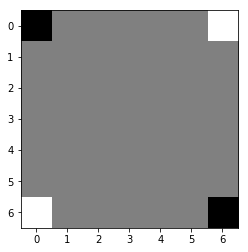

((6, 6), (6, 5)): n_v:   193 q_all:+0.001408 q:+0.025765 q_m:+0.000735 p:0.086930
((6, 6), (5, 6)): n_v:   191 q_all:+0.001712 q:+0.014693 q_m:+0.000735 p:0.086098
((6, 6), (5, 5)): n_v:   184 q_all:+0.002678 q:+0.019983 q_m:+0.000735 p:0.082083
((0, 0), (1, 1)): n_v:   184 q_all:+0.000483 q:+0.004937 q_m:+0.000735 p:0.083746
((0, 0), (0, 1)): n_v:   180 q_all:+0.000887 q:+0.005949 q_m:+0.000735 p:0.081695
((0, 0), (1, 0)): n_v:   179 q_all:+0.000492 q:-0.000797 q_m:+0.000735 p:0.081638
((6, 6), (6, 4)): n_v:   127 q_all:+0.000033 q:+0.011792 q_m:-0.000000 p:0.057869
((6, 6), (4, 6)): n_v:   123 q_all:+0.002930 q:+0.001872 q_m:-0.000000 p:0.054684
((0, 0), (0, 2)): n_v:   121 q_all:+0.000389 q:-0.005670 q_m:-0.000000 p:0.055116
((0, 0), (2, 0)): n_v:   113 q_all:-0.000354 q:-0.005948 q_m:-0.000000 p:0.051964
((6, 6), (5, 4)): n_v:   107 q_all:+0.000849 q:+0.011021 q_m:-0.000000 p:0.048725
((6, 6), (4, 5)): n_v:   105 q_all:+0.002583 q:+0.011597 q_m:-0.000000 p:0.046961
((0, 0), (1, 2))

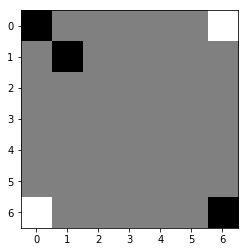

((6, 0), (5, 1)): n_v:   250 q_all:+0.000913 q:-0.019108 q_m:-0.000000 p:0.102178
((0, 6), (0, 5)): n_v:   241 q_all:-0.000974 q:+0.014816 q_m:-0.000000 p:0.100051
((6, 0), (6, 1)): n_v:   238 q_all:-0.000044 q:-0.001225 q_m:-0.000000 p:0.098188
((0, 6), (1, 5)): n_v:   236 q_all:-0.001906 q:+0.001596 q_m:-0.000000 p:0.099176
((6, 0), (5, 0)): n_v:   232 q_all:+0.002434 q:+0.001223 q_m:-0.000000 p:0.093269
((0, 6), (1, 6)): n_v:   218 q_all:-0.002018 q:+0.014816 q_m:-0.000000 p:0.091814
((0, 6), (2, 6)): n_v:   114 q_all:-0.001904 q:-0.002512 q_m:-0.000735 p:0.047890
((0, 6), (1, 4)): n_v:   106 q_all:-0.005077 q:-0.005001 q_m:-0.000735 p:0.046141
((6, 0), (4, 0)): n_v:   104 q_all:-0.002768 q:-0.004605 q_m:-0.000735 p:0.044261
((6, 0), (5, 2)): n_v:   102 q_all:-0.000385 q:-0.007529 q_m:-0.000735 p:0.042424
((6, 0), (6, 2)): n_v:   100 q_all:-0.000298 q:-0.005541 q_m:-0.000735 p:0.041636
((0, 6), (0, 4)): n_v:   100 q_all:-0.004543 q:-0.005371 q_m:-0.000735 p:0.043207
((0, 6), (2, 5))

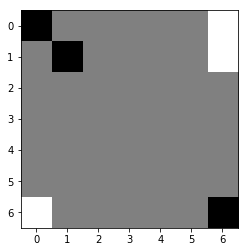

((1, 1), (0, 2)): n_v:   193 q_all:-0.001315 q:+0.016156 q_m:+0.000735 p:0.071696
((1, 1), (2, 0)): n_v:   166 q_all:-0.002320 q:+0.007730 q_m:+0.000735 p:0.062363
((1, 1), (1, 2)): n_v:   142 q_all:-0.001744 q:+0.006659 q_m:+0.000735 p:0.053192
((1, 1), (2, 1)): n_v:   134 q_all:-0.001520 q:+0.010212 q_m:+0.000735 p:0.050183
((6, 6), (5, 5)): n_v:   132 q_all:+0.000865 q:+0.019226 q_m:+0.000735 p:0.047989
((6, 6), (6, 5)): n_v:   125 q_all:-0.000462 q:+0.025451 q_m:+0.000735 p:0.046022
((6, 6), (5, 6)): n_v:   119 q_all:-0.000082 q:+0.012118 q_m:+0.000735 p:0.043924
((1, 1), (2, 2)): n_v:   118 q_all:-0.000740 q:+0.003244 q_m:+0.000735 p:0.043911
((0, 0), (0, 1)): n_v:   115 q_all:-0.000100 q:+0.007963 q_m:+0.000735 p:0.042207
((0, 0), (1, 0)): n_v:   111 q_all:-0.002037 q:-0.001476 q_m:+0.000735 p:0.041681
((1, 1), (1, 3)): n_v:    80 q_all:-0.002452 q:+0.009392 q_m:-0.000000 p:0.030378
((1, 1), (3, 1)): n_v:    79 q_all:-0.001576 q:-0.004000 q_m:-0.000000 p:0.029662
((6, 6), (6, 4))

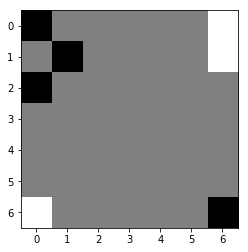

((1, 6), (2, 5)): n_v:   271 q_all:+0.000893 q:+0.018551 q_m:-0.000000 p:0.098071
((6, 0), (5, 0)): n_v:   207 q_all:+0.002736 q:+0.007429 q_m:-0.000000 p:0.073337
((1, 6), (2, 6)): n_v:   167 q_all:+0.001180 q:+0.018551 q_m:-0.000000 p:0.060225
((6, 0), (5, 1)): n_v:   153 q_all:+0.000367 q:-0.006891 q_m:-0.000000 p:0.055817
((0, 6), (0, 5)): n_v:   137 q_all:-0.002417 q:+0.018551 q_m:-0.000000 p:0.051547
((0, 6), (1, 5)): n_v:   137 q_all:-0.002135 q:+0.014156 q_m:-0.000000 p:0.051313
((1, 6), (3, 6)): n_v:   134 q_all:-0.000651 q:+0.017537 q_m:-0.000735 p:0.049233
((6, 0), (6, 1)): n_v:   132 q_all:-0.000333 q:+0.006281 q_m:-0.000000 p:0.048388
((1, 6), (3, 5)): n_v:    98 q_all:-0.002254 q:+0.014326 q_m:-0.000735 p:0.036904
((6, 0), (4, 1)): n_v:    95 q_all:-0.002797 q:+0.007364 q_m:-0.000735 p:0.035878
((0, 6), (2, 5)): n_v:    89 q_all:-0.000452 q:+0.018551 q_m:-0.000735 p:0.032767
((0, 6), (2, 6)): n_v:    81 q_all:-0.000044 q:+0.018551 q_m:-0.000735 p:0.029699
((6, 0), (6, 2))

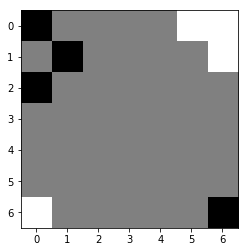

((1, 1), (0, 2)): n_v:   162 q_all:-0.003115 q:+0.015304 q_m:+0.000735 p:0.058742
((6, 6), (5, 5)): n_v:   123 q_all:+0.000312 q:+0.021672 q_m:+0.000735 p:0.043002
((0, 0), (1, 0)): n_v:   108 q_all:-0.002942 q:+0.006996 q_m:+0.000735 p:0.038994
((2, 0), (3, 1)): n_v:   106 q_all:-0.001976 q:+0.015753 q_m:+0.000735 p:0.038038
((6, 6), (5, 6)): n_v:   103 q_all:-0.000475 q:+0.015436 q_m:+0.000735 p:0.036174
((2, 0), (3, 0)): n_v:   103 q_all:-0.001048 q:+0.024844 q_m:+0.000735 p:0.036613
((1, 1), (1, 2)): n_v:   102 q_all:-0.003206 q:+0.011876 q_m:+0.000735 p:0.036896
((2, 0), (0, 2)): n_v:    94 q_all:-0.003486 q:+0.006799 q_m:-0.000000 p:0.034142
((1, 1), (2, 1)): n_v:    92 q_all:-0.002418 q:+0.012794 q_m:+0.000735 p:0.033036
((1, 1), (2, 2)): n_v:    91 q_all:-0.002465 q:+0.015686 q_m:+0.000735 p:0.032704
((6, 6), (6, 5)): n_v:    89 q_all:-0.002026 q:+0.028673 q_m:+0.000735 p:0.031792
((0, 0), (0, 1)): n_v:    80 q_all:-0.002636 q:+0.014849 q_m:+0.000735 p:0.028810
((2, 0), (4, 0))

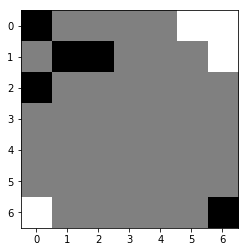

((6, 0), (5, 0)): n_v:   178 q_all:+0.001330 q:+0.008298 q_m:-0.000000 p:0.065045
((1, 6), (2, 5)): n_v:   162 q_all:-0.001295 q:+0.018104 q_m:-0.000000 p:0.060909
((6, 0), (5, 1)): n_v:   161 q_all:-0.001175 q:+0.001737 q_m:-0.000000 p:0.060656
((6, 0), (6, 1)): n_v:   156 q_all:-0.001841 q:+0.016536 q_m:-0.000000 p:0.059345
((0, 5), (1, 4)): n_v:   147 q_all:-0.004416 q:+0.015847 q_m:-0.000000 p:0.057348
((0, 5), (1, 5)): n_v:   140 q_all:-0.004328 q:+0.017462 q_m:-0.000000 p:0.054697
((0, 5), (0, 4)): n_v:   125 q_all:-0.004657 q:+0.021957 q_m:-0.000000 p:0.048861
((1, 6), (2, 6)): n_v:   107 q_all:-0.001449 q:+0.017462 q_m:-0.000000 p:0.040626
((0, 5), (1, 3)): n_v:    84 q_all:-0.010724 q:+0.029982 q_m:+0.000735 p:0.034944
((1, 6), (3, 6)): n_v:    75 q_all:-0.001412 q:+0.016623 q_m:-0.000735 p:0.028378
((1, 6), (3, 5)): n_v:    58 q_all:-0.003375 q:+0.013422 q_m:-0.000735 p:0.022447
((1, 6), (1, 4)): n_v:    58 q_all:-0.007240 q:+0.015847 q_m:-0.000735 p:0.023621
((6, 0), (4, 1))

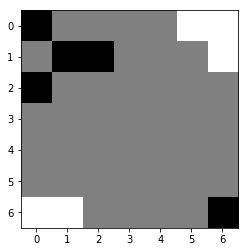

((1, 1), (0, 2)): n_v:   124 q_all:-0.004511 q:+0.010857 q_m:+0.000735 p:0.040200
((6, 6), (5, 5)): n_v:   119 q_all:-0.002535 q:+0.006963 q_m:+0.000735 p:0.037491
((1, 2), (0, 3)): n_v:    96 q_all:-0.004165 q:+0.005600 q_m:+0.000735 p:0.031060
((1, 2), (0, 4)): n_v:    92 q_all:-0.002569 q:+0.009884 q_m:+0.002939 p:0.029098
((1, 2), (1, 3)): n_v:    86 q_all:-0.005351 q:+0.008030 q_m:+0.000735 p:0.028308
((2, 0), (0, 2)): n_v:    85 q_all:-0.005375 q:+0.008693 q_m:-0.000000 p:0.027791
((1, 2), (2, 3)): n_v:    85 q_all:-0.004674 q:+0.021617 q_m:+0.000735 p:0.027757
((6, 6), (6, 5)): n_v:    84 q_all:-0.003558 q:+0.012858 q_m:+0.000735 p:0.026905
((0, 0), (1, 0)): n_v:    83 q_all:-0.004445 q:-0.000439 q_m:+0.000735 p:0.026864
((6, 6), (5, 6)): n_v:    80 q_all:-0.002459 q:+0.003818 q_m:+0.000735 p:0.025316
((2, 0), (3, 1)): n_v:    78 q_all:-0.003272 q:+0.002430 q_m:+0.000735 p:0.024964
((1, 1), (2, 1)): n_v:    76 q_all:-0.004094 q:+0.005241 q_m:+0.000735 p:0.024746
((0, 0), (0, 1))

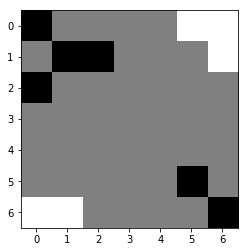

((0, 5), (0, 4)): n_v:   147 q_all:-0.004438 q:+0.018118 q_m:-0.000000 p:0.052529
((6, 0), (5, 0)): n_v:   144 q_all:-0.001233 q:+0.008110 q_m:-0.000000 p:0.049398
((6, 1), (6, 2)): n_v:   135 q_all:+0.001201 q:-0.002368 q_m:-0.000000 p:0.045149
((1, 6), (2, 5)): n_v:   130 q_all:-0.001409 q:+0.025770 q_m:-0.000000 p:0.044828
((0, 5), (1, 5)): n_v:   127 q_all:-0.003937 q:+0.017855 q_m:-0.000000 p:0.045045
((6, 0), (5, 1)): n_v:   122 q_all:-0.002905 q:+0.009709 q_m:-0.000000 p:0.042598
((6, 1), (5, 2)): n_v:   105 q_all:-0.002784 q:+0.001829 q_m:-0.000000 p:0.036904
((0, 5), (1, 4)): n_v:   102 q_all:-0.003527 q:+0.017855 q_m:-0.000000 p:0.036019
((1, 6), (2, 6)): n_v:    93 q_all:-0.000798 q:+0.017855 q_m:-0.000000 p:0.031750
((0, 5), (1, 3)): n_v:    76 q_all:-0.009602 q:+0.018340 q_m:+0.000735 p:0.028699
((6, 1), (5, 3)): n_v:    66 q_all:-0.010459 q:-0.007652 q_m:-0.000735 p:0.025407
((0, 5), (0, 3)): n_v:    57 q_all:-0.008039 q:+0.017855 q_m:+0.000735 p:0.021257
((6, 0), (4, 1))

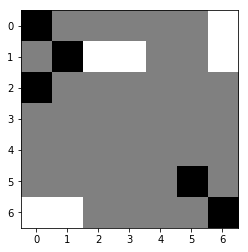

((1, 1), (0, 2)): n_v:   371 q_all:+0.004741 q:+0.050453 q_m:+0.011755 p:0.125592
((1, 1), (2, 2)): n_v:   177 q_all:+0.005155 q:+0.058698 q_m:+0.011755 p:0.059678
((2, 0), (0, 2)): n_v:   161 q_all:+0.001941 q:+0.042210 q_m:+0.006612 p:0.056451
((5, 5), (6, 4)): n_v:   142 q_all:-0.007818 q:+0.006609 q_m:-0.000000 p:0.055611
((5, 5), (5, 4)): n_v:   106 q_all:-0.003443 q:+0.003157 q_m:-0.000000 p:0.039541
((1, 1), (0, 3)): n_v:   105 q_all:+0.001379 q:+0.033414 q_m:+0.006612 p:0.037263
((2, 0), (0, 1)): n_v:   105 q_all:-0.005994 q:+0.014379 q_m:+0.000735 p:0.040322
((0, 0), (0, 1)): n_v:    96 q_all:-0.003763 q:+0.025286 q_m:+0.002939 p:0.036153
((5, 5), (6, 5)): n_v:    73 q_all:-0.006322 q:+0.014689 q_m:-0.000000 p:0.028337
((5, 5), (4, 4)): n_v:    66 q_all:-0.007956 q:+0.009004 q_m:-0.000000 p:0.026074
((0, 0), (0, 2)): n_v:    66 q_all:+0.001605 q:+0.036859 q_m:+0.006612 p:0.023271
((5, 5), (5, 3)): n_v:    55 q_all:-0.008278 q:+0.004560 q_m:-0.000735 p:0.021986
((0, 0), (1, 0))

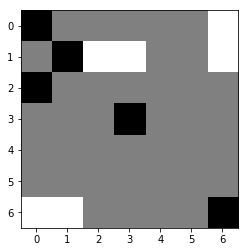

((1, 2), (2, 3)): n_v:   106 q_all:-0.017666 q:+0.042679 q_m:+0.011755 p:0.044882
((1, 2), (0, 1)): n_v:   104 q_all:+0.008193 q:+0.014830 q_m:+0.026449 p:0.032569
((6, 1), (5, 2)): n_v:    86 q_all:-0.003993 q:+0.019527 q_m:+0.002939 p:0.031404
((6, 0), (5, 1)): n_v:    85 q_all:-0.004861 q:+0.015651 q_m:+0.002939 p:0.031376
((1, 6), (2, 5)): n_v:    85 q_all:-0.000529 q:+0.014471 q_m:+0.002939 p:0.029868
((0, 6), (1, 5)): n_v:    84 q_all:-0.005416 q:+0.013517 q_m:+0.002939 p:0.031330
((1, 2), (2, 1)): n_v:    83 q_all:+0.009233 q:+0.021125 q_m:+0.026449 p:0.025515
((1, 2), (2, 2)): n_v:    78 q_all:+0.009197 q:+0.043496 q_m:+0.026449 p:0.023926
((1, 2), (1, 4)): n_v:    71 q_all:-0.006537 q:+0.018769 q_m:+0.000735 p:0.026567
((1, 3), (1, 4)): n_v:    63 q_all:-0.007741 q:+0.014471 q_m:+0.002939 p:0.024057
((1, 3), (2, 4)): n_v:    60 q_all:-0.005377 q:+0.030132 q_m:+0.011755 p:0.022426
((1, 6), (3, 4)): n_v:    60 q_all:-0.013795 q:+0.056169 q_m:+0.006612 p:0.024598
((1, 3), (0, 1))

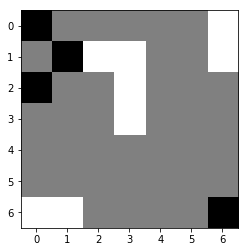

((1, 1), (2, 2)): n_v:  1035 q_all:+0.004256 q:+0.076558 q_m:+0.018367 p:0.366953
((0, 0), (2, 2)): n_v:   207 q_all:+0.001434 q:+0.070533 q_m:+0.011755 p:0.075777
((2, 0), (2, 2)): n_v:   186 q_all:+0.001115 q:+0.054097 q_m:+0.011755 p:0.068494
((1, 1), (0, 2)): n_v:    98 q_all:-0.013433 q:+0.021508 q_m:+0.000735 p:0.042302
((2, 0), (4, 2)): n_v:    95 q_all:-0.020689 q:-0.007871 q_m:-0.002939 p:0.043583
((6, 6), (4, 4)): n_v:    63 q_all:-0.018267 q:-0.002679 q_m:-0.002939 p:0.028551
((2, 0), (3, 2)): n_v:    62 q_all:-0.035429 q:+0.013031 q_m:-0.000000 p:0.032424
((6, 6), (5, 5)): n_v:    59 q_all:-0.024341 q:-0.005102 q_m:-0.006612 p:0.027852
((1, 1), (3, 2)): n_v:    58 q_all:-0.024527 q:+0.015727 q_m:-0.000000 p:0.027689
((1, 1), (2, 1)): n_v:    54 q_all:-0.016235 q:-0.009609 q_m:-0.000735 p:0.023984
((2, 0), (3, 1)): n_v:    51 q_all:-0.028907 q:-0.029344 q_m:-0.006612 p:0.025398
((0, 0), (0, 1)): n_v:    42 q_all:-0.015102 q:-0.006495 q_m:-0.000735 p:0.018329
((2, 0), (0, 1))

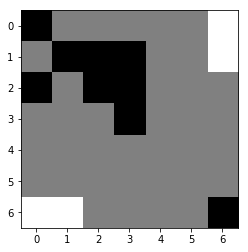

((1, 6), (3, 4)): n_v:   456 q_all:-0.019193 q:+0.039739 q_m:-0.000735 p:0.116773
((6, 1), (5, 2)): n_v:   272 q_all:-0.027439 q:+0.004608 q_m:-0.011755 p:0.077657
((1, 6), (2, 5)): n_v:   217 q_all:-0.031728 q:+0.010467 q_m:-0.011755 p:0.064869
((1, 6), (2, 4)): n_v:   214 q_all:-0.008249 q:+0.032032 q_m:+0.000735 p:0.046495
((0, 6), (2, 4)): n_v:   175 q_all:-0.011294 q:+0.017772 q_m:+0.000735 p:0.040076
((6, 1), (4, 2)): n_v:   155 q_all:-0.030377 q:+0.002700 q_m:-0.006612 p:0.045789
((6, 1), (6, 2)): n_v:   129 q_all:-0.027084 q:-0.000255 q_m:-0.011755 p:0.036746
((6, 1), (4, 3)): n_v:   126 q_all:-0.031376 q:+0.015585 q_m:-0.006612 p:0.037867
((1, 6), (3, 5)): n_v:   118 q_all:-0.028532 q:+0.016925 q_m:-0.018367 p:0.034061
((0, 6), (1, 4)): n_v:   116 q_all:-0.017135 q:+0.014471 q_m:-0.000735 p:0.029033
((1, 6), (1, 4)): n_v:   116 q_all:-0.015357 q:+0.014471 q_m:-0.000735 p:0.028229
((6, 0), (4, 2)): n_v:   107 q_all:-0.027688 q:+0.026576 q_m:-0.006612 p:0.030582
((6, 1), (5, 3))

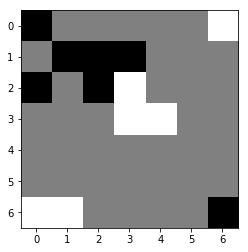

((1, 3), (2, 4)): n_v:   874 q_all:+0.025806 q:+0.066568 q_m:+0.047020 p:0.255192
((2, 2), (2, 4)): n_v:   176 q_all:+0.020133 q:+0.067146 q_m:+0.036000 p:0.055302
((6, 6), (4, 4)): n_v:   143 q_all:+0.001847 q:+0.048532 q_m:+0.018367 p:0.055236
((2, 2), (4, 4)): n_v:   138 q_all:-0.000857 q:+0.058440 q_m:+0.018367 p:0.054758
((2, 2), (3, 2)): n_v:   135 q_all:+0.008818 q:+0.075057 q_m:+0.026449 p:0.048529
((1, 2), (2, 4)): n_v:   123 q_all:+0.019975 q:+0.046522 q_m:+0.036000 p:0.038935
((2, 0), (4, 2)): n_v:   102 q_all:-0.007255 q:+0.022227 q_m:+0.006612 p:0.043176
((2, 0), (3, 1)): n_v:    63 q_all:-0.006141 q:+0.004254 q_m:+0.002939 p:0.026340
((1, 1), (3, 2)): n_v:    56 q_all:+0.006352 q:+0.062266 q_m:+0.018367 p:0.020823
((2, 2), (4, 2)): n_v:    50 q_all:-0.009990 q:+0.019130 q_m:+0.006612 p:0.021616
((2, 0), (3, 2)): n_v:    44 q_all:+0.005069 q:+0.054061 q_m:+0.018367 p:0.016703
((1, 1), (2, 1)): n_v:    39 q_all:-0.005943 q:+0.017453 q_m:+0.002939 p:0.016351
((2, 2), (4, 3))

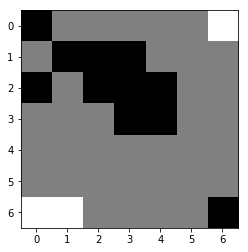

((0, 6), (1, 4)): n_v:   623 q_all:-0.014643 q:-0.005863 q_m:-0.002939 p:0.134027
((6, 1), (5, 2)): n_v:   516 q_all:-0.048546 q:-0.001271 q_m:-0.036000 p:0.174214
((6, 1), (6, 2)): n_v:   213 q_all:-0.048727 q:-0.008441 q_m:-0.036000 p:0.072115
((0, 6), (1, 5)): n_v:   200 q_all:-0.037446 q:-0.005941 q_m:-0.018367 p:0.059745
((6, 1), (4, 3)): n_v:   165 q_all:-0.044026 q:+0.012194 q_m:-0.011755 p:0.053308
((6, 0), (5, 1)): n_v:   144 q_all:-0.047527 q:-0.005801 q_m:-0.036000 p:0.048407
((6, 0), (5, 2)): n_v:   139 q_all:-0.056528 q:-0.002056 q_m:-0.047020 p:0.050958
((6, 1), (4, 2)): n_v:   134 q_all:-0.060328 q:-0.014387 q_m:-0.026449 p:0.051168
((0, 6), (2, 5)): n_v:   119 q_all:-0.032094 q:-0.002030 q_m:-0.011755 p:0.033277
((0, 6), (0, 5)): n_v:    99 q_all:-0.060310 q:-0.001895 q_m:-0.036000 p:0.037776
((6, 0), (4, 2)): n_v:    88 q_all:-0.060357 q:-0.003820 q_m:-0.026449 p:0.033686
((0, 6), (0, 4)): n_v:    86 q_all:-0.053412 q:-0.006374 q_m:-0.026449 p:0.030751
((6, 0), (4, 1))

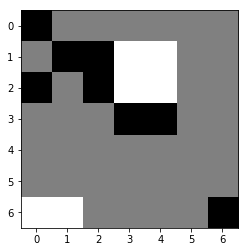

((1, 2), (0, 3)): n_v:   241 q_all:+0.015339 q:+0.062428 q_m:+0.036000 p:0.060083
((3, 4), (1, 5)): n_v:   174 q_all:+0.006263 q:+0.033438 q_m:+0.026449 p:0.049412
((3, 4), (5, 5)): n_v:   145 q_all:-0.003181 q:+0.018480 q_m:+0.002939 p:0.046515
((3, 3), (5, 1)): n_v:   115 q_all:+0.008037 q:+0.007938 q_m:+0.026449 p:0.031908
((1, 1), (0, 2)): n_v:   101 q_all:+0.006487 q:+0.034470 q_m:+0.018367 p:0.028798
((3, 3), (5, 5)): n_v:    90 q_all:-0.004334 q:+0.010471 q_m:+0.002939 p:0.029148
((3, 3), (1, 5)): n_v:    87 q_all:-0.001943 q:+0.019675 q_m:+0.026449 p:0.027433
((6, 6), (5, 5)): n_v:    84 q_all:-0.000719 q:+0.020532 q_m:+0.006612 p:0.026116
((2, 0), (0, 2)): n_v:    82 q_all:+0.001006 q:+0.010952 q_m:+0.011755 p:0.025153
((1, 1), (0, 3)): n_v:    70 q_all:+0.010903 q:+0.040112 q_m:+0.026449 p:0.018761
((3, 3), (4, 3)): n_v:    68 q_all:-0.007760 q:+0.012546 q_m:+0.006612 p:0.022971
((2, 2), (0, 4)): n_v:    68 q_all:+0.006573 q:+0.039404 q_m:+0.026449 p:0.019383
((1, 2), (0, 4))

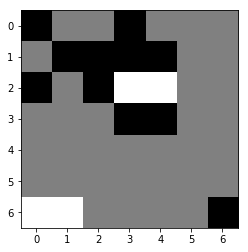

((2, 4), (0, 2)): n_v:   366 q_all:-0.010468 q:-0.019215 q_m:+0.000735 p:0.123537
((2, 3), (0, 2)): n_v:   189 q_all:-0.009558 q:-0.009181 q_m:+0.000735 p:0.063042
((2, 3), (0, 4)): n_v:   156 q_all:-0.029459 q:+0.011645 q_m:-0.000735 p:0.065385
((6, 1), (6, 2)): n_v:   145 q_all:-0.040878 q:-0.015587 q_m:-0.026449 p:0.067663
((2, 4), (0, 4)): n_v:   136 q_all:-0.024941 q:-0.005866 q_m:-0.000735 p:0.054161
((2, 3), (3, 2)): n_v:   118 q_all:-0.024263 q:+0.029663 q_m:-0.002939 p:0.046933
((2, 4), (2, 5)): n_v:   105 q_all:-0.021216 q:+0.022201 q_m:-0.002939 p:0.040282
((2, 4), (1, 5)): n_v:    85 q_all:-0.034986 q:-0.011638 q_m:-0.011755 p:0.037347
((6, 1), (5, 2)): n_v:    77 q_all:-0.044771 q:-0.008875 q_m:-0.026449 p:0.037203
((6, 0), (6, 2)): n_v:    64 q_all:-0.046909 q:-0.007200 q_m:-0.036000 p:0.031881
((6, 0), (5, 1)): n_v:    50 q_all:-0.039689 q:-0.010439 q_m:-0.026449 p:0.023208
((2, 3), (4, 3)): n_v:    48 q_all:-0.063731 q:+0.010063 q_m:-0.006612 p:0.027376
((2, 3), (4, 4))

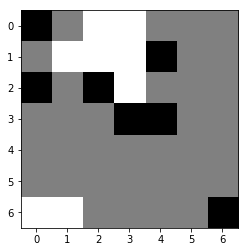

((1, 4), (2, 4)): n_v:   313 q_all:+0.002044 q:+0.017380 q_m:+0.011755 p:0.078779
((0, 0), (0, 1)): n_v:   281 q_all:+0.009147 q:+0.070886 q_m:+0.026449 p:0.063016
((2, 0), (0, 1)): n_v:   225 q_all:+0.004726 q:+0.042891 q_m:+0.018367 p:0.054422
((1, 4), (0, 4)): n_v:   206 q_all:-0.000815 q:+0.030989 q_m:+0.011755 p:0.054215
((3, 3), (4, 4)): n_v:   128 q_all:-0.012199 q:+0.009376 q_m:-0.000000 p:0.039534
((2, 0), (2, 1)): n_v:    87 q_all:-0.001443 q:+0.027886 q_m:+0.011755 p:0.023096
((3, 3), (4, 2)): n_v:    83 q_all:-0.019656 q:-0.004956 q_m:-0.000000 p:0.028134
((1, 4), (0, 5)): n_v:    75 q_all:-0.014737 q:-0.006994 q_m:-0.000000 p:0.023938
((6, 6), (6, 5)): n_v:    73 q_all:-0.010416 q:+0.012845 q_m:-0.000000 p:0.022247
((6, 6), (5, 5)): n_v:    67 q_all:-0.011940 q:+0.010453 q_m:-0.000000 p:0.020564
((3, 4), (1, 5)): n_v:    57 q_all:-0.015994 q:-0.008195 q_m:-0.000735 p:0.018360
((3, 4), (5, 5)): n_v:    54 q_all:-0.011443 q:-0.000931 q_m:-0.000735 p:0.016759
((1, 4), (1, 5))

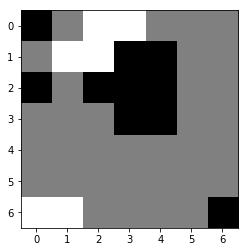

((1, 1), (3, 2)): n_v:   465 q_all:-0.005412 q:+0.025319 q_m:+0.002939 p:0.138343
((0, 3), (0, 4)): n_v:   307 q_all:-0.012885 q:-0.001283 q_m:+0.000735 p:0.100637
((1, 1), (2, 1)): n_v:   176 q_all:-0.002917 q:-0.010116 q_m:+0.000735 p:0.050814
((6, 1), (4, 3)): n_v:   176 q_all:-0.016795 q:+0.017605 q_m:-0.000000 p:0.060662
((6, 1), (5, 2)): n_v:   161 q_all:-0.029138 q:-0.004648 q_m:-0.006612 p:0.063451
((0, 3), (1, 5)): n_v:   116 q_all:-0.024510 q:-0.005922 q_m:-0.000000 p:0.043402
((1, 2), (3, 2)): n_v:    86 q_all:-0.035361 q:+0.004519 q_m:+0.002939 p:0.035998
((6, 0), (5, 1)): n_v:    84 q_all:-0.034141 q:-0.007218 q_m:-0.006612 p:0.034844
((0, 3), (2, 5)): n_v:    80 q_all:-0.008653 q:+0.015168 q_m:+0.002939 p:0.024937
((0, 3), (2, 1)): n_v:    76 q_all:-0.011196 q:-0.012244 q_m:-0.000000 p:0.024401
((1, 1), (3, 1)): n_v:    74 q_all:-0.020521 q:-0.002753 q_m:-0.000000 p:0.026515
((6, 1), (4, 2)): n_v:    72 q_all:-0.027456 q:-0.010837 q_m:-0.002939 p:0.027960
((0, 2), (0, 1))

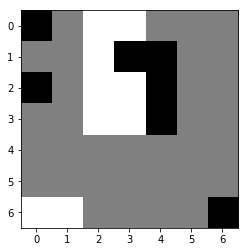

((3, 4), (4, 3)): n_v:   619 q_all:-0.004071 q:+0.036720 q_m:+0.006612 p:0.163950
((0, 0), (1, 1)): n_v:   448 q_all:-0.002499 q:+0.016350 q_m:+0.018367 p:0.116130
((1, 4), (1, 5)): n_v:   126 q_all:-0.026072 q:-0.015620 q_m:-0.000735 p:0.044259
((6, 6), (5, 5)): n_v:   121 q_all:-0.016529 q:+0.001604 q_m:-0.000735 p:0.038012
((3, 4), (4, 4)): n_v:    99 q_all:-0.017084 q:-0.001095 q_m:+0.000735 p:0.031348
((3, 4), (1, 5)): n_v:    82 q_all:-0.032095 q:-0.025104 q_m:-0.002939 p:0.030583
((2, 0), (2, 1)): n_v:    79 q_all:-0.001611 q:+0.035637 q_m:+0.018367 p:0.020226
((2, 0), (3, 1)): n_v:    72 q_all:-0.010771 q:+0.012215 q_m:+0.006612 p:0.020887
((1, 3), (0, 4)): n_v:    71 q_all:-0.006455 q:-0.004401 q_m:+0.000735 p:0.019683
((3, 4), (4, 2)): n_v:    66 q_all:-0.011168 q:+0.007868 q_m:+0.002939 p:0.019353
((0, 0), (0, 1)): n_v:    55 q_all:-0.016304 q:+0.011157 q_m:+0.006612 p:0.017360
((3, 4), (5, 5)): n_v:    51 q_all:-0.020723 q:+0.005538 q_m:-0.002939 p:0.017035
((3, 4), (5, 2))

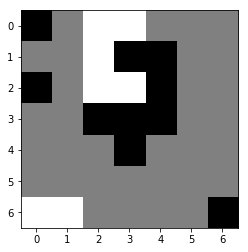

((6, 1), (4, 2)): n_v:   551 q_all:-0.002114 q:+0.021715 q_m:+0.006612 p:0.171420
((6, 0), (4, 2)): n_v:   447 q_all:-0.002013 q:+0.007729 q_m:+0.006612 p:0.138859
((2, 2), (4, 4)): n_v:   438 q_all:-0.004855 q:+0.015366 q_m:+0.006612 p:0.140624
((2, 3), (4, 4)): n_v:   254 q_all:-0.019792 q:+0.020669 q_m:+0.006612 p:0.096221
((2, 3), (4, 2)): n_v:   241 q_all:-0.022152 q:+0.035222 q_m:+0.006612 p:0.093347
((2, 2), (4, 2)): n_v:   182 q_all:-0.015411 q:+0.022939 q_m:+0.006612 p:0.065860
((2, 2), (3, 1)): n_v:    52 q_all:-0.016623 q:-0.005414 q_m:+0.002939 p:0.019136
((1, 2), (2, 1)): n_v:    50 q_all:-0.016252 q:-0.007766 q_m:+0.002939 p:0.018485
((6, 1), (5, 2)): n_v:    46 q_all:-0.016678 q:-0.015435 q_m:-0.000000 p:0.016990
((6, 0), (5, 1)): n_v:    34 q_all:-0.020783 q:-0.018711 q_m:-0.002939 p:0.013053
((0, 2), (1, 1)): n_v:    33 q_all:-0.007565 q:-0.014730 q_m:+0.002939 p:0.011154
((6, 1), (5, 3)): n_v:    30 q_all:-0.019647 q:+0.013653 q_m:-0.000735 p:0.011326
((0, 3), (2, 5))

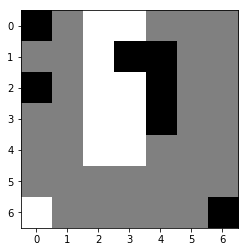

((3, 4), (4, 4)): n_v:   746 q_all:-0.000918 q:+0.019072 q_m:+0.002939 p:0.193046
((0, 0), (1, 1)): n_v:   285 q_all:-0.009618 q:+0.016756 q_m:+0.011755 p:0.083174
((6, 6), (4, 4)): n_v:   202 q_all:-0.003771 q:+0.009786 q_m:+0.000735 p:0.054544
((3, 4), (5, 2)): n_v:   131 q_all:-0.007636 q:+0.001286 q_m:+0.000735 p:0.037498
((2, 0), (3, 1)): n_v:   117 q_all:-0.009743 q:+0.030545 q_m:+0.011755 p:0.034293
((3, 4), (5, 3)): n_v:   116 q_all:-0.009934 q:+0.018313 q_m:+0.000735 p:0.033982
((2, 0), (2, 1)): n_v:    92 q_all:-0.014024 q:+0.032266 q_m:+0.011755 p:0.028574
((6, 6), (5, 5)): n_v:    88 q_all:-0.021773 q:+0.002159 q_m:-0.002939 p:0.029749
((1, 3), (0, 4)): n_v:    84 q_all:-0.012559 q:+0.002994 q_m:-0.000000 p:0.025697
((1, 4), (1, 5)): n_v:    73 q_all:-0.029369 q:-0.003023 q_m:-0.002939 p:0.026650
((2, 4), (4, 4)): n_v:    59 q_all:-0.035124 q:+0.015563 q_m:+0.000735 p:0.023208
((0, 0), (0, 1)): n_v:    52 q_all:-0.024472 q:+0.013456 q_m:+0.002939 p:0.018393
((2, 0), (4, 1))

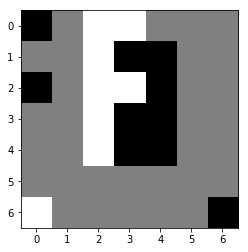

((4, 2), (5, 3)): n_v:   383 q_all:-0.003887 q:+0.008083 q_m:+0.006612 p:0.084457
((0, 3), (2, 5)): n_v:   195 q_all:-0.004969 q:+0.026290 q_m:+0.011755 p:0.043911
((4, 2), (5, 2)): n_v:   176 q_all:-0.025861 q:-0.034079 q_m:+0.000735 p:0.053292
((0, 2), (1, 1)): n_v:   136 q_all:-0.000859 q:+0.001882 q_m:+0.006612 p:0.028570
((4, 2), (5, 4)): n_v:   127 q_all:-0.000549 q:+0.046178 q_m:+0.002939 p:0.026454
((0, 3), (0, 4)): n_v:   118 q_all:-0.004156 q:+0.012392 q_m:+0.006612 p:0.026154
((3, 2), (5, 4)): n_v:   100 q_all:-0.021036 q:+0.032970 q_m:+0.002939 p:0.028447
((0, 3), (2, 1)): n_v:    96 q_all:-0.031515 q:-0.012840 q_m:-0.000000 p:0.031118
((6, 0), (5, 2)): n_v:    87 q_all:-0.029454 q:+0.006415 q_m:-0.000000 p:0.027562
((1, 2), (2, 1)): n_v:    86 q_all:-0.025289 q:-0.013123 q_m:+0.000735 p:0.026011
((2, 2), (3, 1)): n_v:    81 q_all:-0.024031 q:+0.001004 q_m:+0.000735 p:0.023900
((4, 2), (5, 1)): n_v:    79 q_all:-0.022720 q:-0.029946 q_m:-0.000735 p:0.022979
((0, 3), (1, 5))

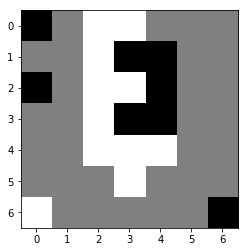

((3, 4), (5, 2)): n_v:   472 q_all:-0.006181 q:+0.015305 q_m:+0.006612 p:0.155278
((6, 6), (5, 4)): n_v:   401 q_all:-0.000099 q:+0.022050 q_m:+0.006612 p:0.122036
((3, 3), (5, 2)): n_v:   197 q_all:-0.019643 q:+0.005839 q_m:+0.006612 p:0.075779
((3, 3), (5, 4)): n_v:   187 q_all:-0.020904 q:+0.032393 q_m:+0.006612 p:0.073051
((0, 0), (1, 1)): n_v:   138 q_all:-0.007438 q:+0.008356 q_m:+0.011755 p:0.046264
((1, 3), (0, 4)): n_v:   106 q_all:-0.010325 q:-0.004955 q_m:-0.000000 p:0.036948
((2, 0), (3, 1)): n_v:    90 q_all:-0.009436 q:+0.019280 q_m:+0.011755 p:0.030890
((6, 6), (5, 5)): n_v:    70 q_all:-0.007948 q:+0.000422 q_m:-0.000000 p:0.023657
((2, 4), (3, 5)): n_v:    55 q_all:-0.016641 q:+0.007271 q_m:-0.000000 p:0.020684
((3, 3), (1, 1)): n_v:    51 q_all:-0.018371 q:-0.013031 q_m:+0.006612 p:0.019629
((1, 4), (1, 5)): n_v:    49 q_all:-0.027041 q:-0.015861 q_m:-0.002939 p:0.020345
((2, 0), (2, 1)): n_v:    46 q_all:-0.013062 q:+0.028507 q_m:+0.011755 p:0.016616
((0, 0), (0, 1))

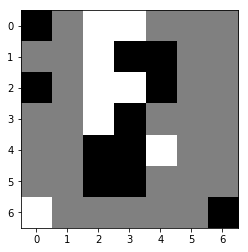

((2, 3), (3, 4)): n_v:  1646 q_all:+0.000797 q:+0.008611 q_m:+0.011755 p:0.359363
((4, 4), (5, 4)): n_v:   182 q_all:-0.004950 q:+0.032149 q_m:+0.002939 p:0.043999
((3, 2), (3, 4)): n_v:   117 q_all:-0.018015 q:+0.000869 q_m:+0.006612 p:0.034152
((2, 2), (3, 4)): n_v:    89 q_all:-0.020905 q:+0.002228 q_m:+0.006612 p:0.026892
((1, 2), (3, 4)): n_v:    75 q_all:-0.013591 q:+0.003455 q_m:+0.006612 p:0.020681
((6, 0), (5, 1)): n_v:    57 q_all:-0.011443 q:-0.014854 q_m:+0.002939 p:0.015102
((0, 3), (0, 4)): n_v:    56 q_all:-0.006151 q:+0.012150 q_m:+0.002939 p:0.013904
((3, 2), (5, 4)): n_v:    47 q_all:-0.017739 q:+0.030500 q_m:+0.000735 p:0.013831
((4, 4), (5, 5)): n_v:    29 q_all:-0.011153 q:+0.016966 q_m:-0.000000 p:0.007841
((0, 2), (1, 1)): n_v:    29 q_all:-0.008170 q:-0.010530 q_m:+0.002939 p:0.007428
((6, 0), (6, 2)): n_v:    24 q_all:-0.007876 q:+0.026545 q_m:+0.000735 p:0.006245
((0, 3), (1, 5)): n_v:    18 q_all:-0.020026 q:+0.002883 q_m:+0.000735 p:0.005395
((4, 4), (6, 2))

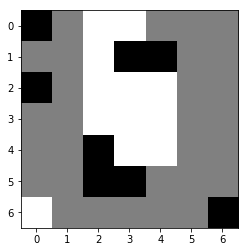

((2, 0), (3, 1)): n_v:   481 q_all:-0.015982 q:-0.003318 q_m:+0.000735 p:0.111922
((1, 4), (2, 5)): n_v:   377 q_all:-0.005860 q:+0.013744 q_m:+0.000735 p:0.075579
((5, 3), (5, 4)): n_v:   314 q_all:-0.003866 q:+0.015431 q_m:+0.000735 p:0.060867
((2, 0), (2, 1)): n_v:   246 q_all:-0.003495 q:+0.026900 q_m:+0.006612 p:0.047308
((1, 4), (1, 5)): n_v:   210 q_all:-0.015244 q:-0.004054 q_m:-0.000735 p:0.048398
((0, 0), (1, 1)): n_v:   185 q_all:-0.002808 q:+0.023630 q_m:+0.006612 p:0.035296
((1, 3), (3, 5)): n_v:   152 q_all:-0.005235 q:-0.004064 q_m:+0.002939 p:0.030170
((5, 3), (3, 5)): n_v:   148 q_all:-0.008843 q:-0.002234 q_m:+0.002939 p:0.031084
((1, 4), (3, 5)): n_v:   106 q_all:-0.003075 q:+0.009618 q_m:+0.002939 p:0.020323
((4, 2), (4, 1)): n_v:    95 q_all:-0.020694 q:-0.002457 q_m:-0.000735 p:0.023600
((1, 3), (3, 1)): n_v:    91 q_all:-0.014552 q:-0.000848 q_m:-0.000000 p:0.020741
((6, 6), (5, 5)): n_v:    91 q_all:-0.019041 q:-0.011952 q_m:-0.000735 p:0.022153
((0, 0), (2, 1))

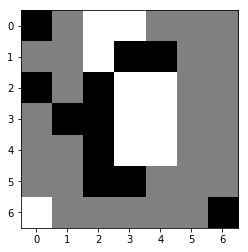

((1, 2), (2, 1)): n_v:   556 q_all:+0.013855 q:+0.019604 q_m:+0.047020 p:0.165285
((6, 0), (4, 1)): n_v:   416 q_all:+0.012687 q:+0.049055 q_m:+0.036000 p:0.125553
((0, 3), (2, 1)): n_v:   383 q_all:+0.008465 q:+0.015194 q_m:+0.036000 p:0.122097
((2, 4), (2, 5)): n_v:   165 q_all:-0.005551 q:+0.018822 q_m:+0.002939 p:0.061758
((0, 2), (2, 1)): n_v:   144 q_all:+0.009414 q:+0.014259 q_m:+0.036000 p:0.045575
((4, 3), (2, 1)): n_v:    71 q_all:+0.002602 q:+0.005470 q_m:+0.036000 p:0.024471
((3, 4), (4, 5)): n_v:    71 q_all:-0.020836 q:-0.011249 q_m:-0.000000 p:0.030925
((0, 3), (2, 5)): n_v:    67 q_all:-0.010892 q:+0.018927 q_m:+0.000735 p:0.026260
((2, 3), (4, 1)): n_v:    49 q_all:-0.002819 q:+0.035973 q_m:+0.036000 p:0.017708
((0, 3), (0, 4)): n_v:    46 q_all:+0.001857 q:+0.019075 q_m:+0.011755 p:0.016039
((0, 2), (1, 1)): n_v:    44 q_all:+0.003427 q:-0.005102 q_m:+0.026449 p:0.015130
((6, 0), (5, 1)): n_v:    41 q_all:+0.001446 q:+0.011066 q_m:+0.011755 p:0.014354
((4, 3), (5, 4))

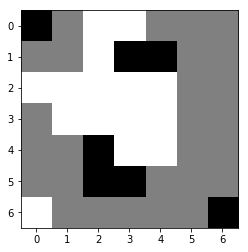

((0, 0), (1, 1)): n_v:   561 q_all:-0.008317 q:+0.025712 q_m:+0.006612 p:0.103949
((1, 4), (2, 5)): n_v:   340 q_all:-0.031808 q:-0.010276 q_m:-0.006612 p:0.093587
((1, 4), (1, 5)): n_v:   321 q_all:-0.052782 q:-0.017809 q_m:-0.018367 p:0.114102
((5, 3), (5, 4)): n_v:   285 q_all:-0.025685 q:-0.007327 q_m:-0.006612 p:0.071876
((4, 2), (4, 1)): n_v:   247 q_all:-0.031207 q:-0.019945 q_m:-0.006612 p:0.067347
((4, 2), (5, 1)): n_v:   152 q_all:-0.049551 q:-0.054767 q_m:-0.018367 p:0.052018
((6, 6), (5, 5)): n_v:   113 q_all:-0.054730 q:-0.035341 q_m:-0.018367 p:0.041031
((6, 6), (4, 5)): n_v:    76 q_all:-0.045040 q:-0.022658 q_m:-0.011755 p:0.024991
((1, 3), (3, 5)): n_v:    72 q_all:-0.030725 q:-0.014083 q_m:-0.002939 p:0.019527
((1, 4), (3, 5)): n_v:    62 q_all:-0.027628 q:-0.014994 q_m:-0.002939 p:0.016063
((5, 3), (3, 5)): n_v:    56 q_all:-0.041450 q:-0.034396 q_m:-0.002939 p:0.017694
((6, 6), (5, 4)): n_v:    42 q_all:-0.033920 q:-0.016135 q_m:-0.011755 p:0.012021
((1, 3), (1, 1))

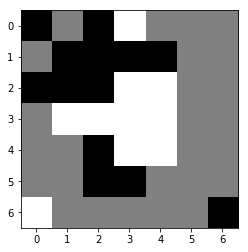

((0, 3), (0, 1)): n_v:   629 q_all:+0.002761 q:+0.023917 q_m:+0.018367 p:0.167453
((0, 3), (0, 4)): n_v:   345 q_all:-0.003928 q:+0.054917 q_m:+0.002939 p:0.100637
((6, 0), (6, 1)): n_v:   325 q_all:-0.018336 q:+0.019353 q_m:-0.000000 p:0.112571
((0, 3), (0, 5)): n_v:   212 q_all:-0.017481 q:+0.051229 q_m:-0.000735 p:0.072820
((4, 3), (5, 4)): n_v:   144 q_all:-0.012351 q:+0.030608 q_m:-0.000000 p:0.046729
((6, 0), (6, 2)): n_v:    95 q_all:-0.009006 q:+0.058814 q_m:+0.000735 p:0.029829
((2, 3), (0, 1)): n_v:    84 q_all:-0.023297 q:+0.017487 q_m:+0.018367 p:0.030885
((3, 1), (1, 0)): n_v:    64 q_all:-0.001437 q:+0.009331 q_m:+0.018367 p:0.018071
((6, 0), (5, 0)): n_v:    63 q_all:-0.033492 q:+0.011816 q_m:-0.002939 p:0.025450
((3, 1), (4, 1)): n_v:    49 q_all:-0.003540 q:+0.029192 q_m:+0.002939 p:0.014403
((2, 4), (1, 5)): n_v:    47 q_all:-0.015006 q:+0.043208 q_m:-0.000000 p:0.015849
((3, 1), (5, 0)): n_v:    45 q_all:-0.032828 q:+0.007055 q_m:-0.006612 p:0.018242
((4, 3), (6, 1))

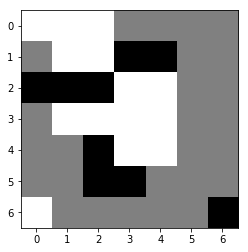

((5, 3), (5, 4)): n_v:   418 q_all:-0.011040 q:+0.026073 q_m:-0.000000 p:0.099365
((1, 4), (2, 5)): n_v:   327 q_all:-0.018964 q:+0.019438 q_m:-0.000000 p:0.087284
((4, 2), (4, 1)): n_v:   234 q_all:-0.013596 q:+0.012304 q_m:-0.000000 p:0.058003
((1, 3), (0, 3)): n_v:   189 q_all:-0.012855 q:-0.000356 q_m:-0.000000 p:0.046368
((2, 0), (4, 1)): n_v:   146 q_all:-0.018609 q:+0.004709 q_m:-0.000735 p:0.038939
((6, 6), (5, 4)): n_v:   113 q_all:-0.016130 q:+0.017823 q_m:-0.000735 p:0.029088
((6, 6), (4, 5)): n_v:   112 q_all:-0.024404 q:+0.019060 q_m:-0.000735 p:0.032472
((2, 0), (1, 0)): n_v:    93 q_all:-0.002927 q:+0.007951 q_m:+0.002939 p:0.019274
((1, 4), (1, 5)): n_v:    92 q_all:-0.023836 q:+0.011892 q_m:-0.002939 p:0.026440
((5, 2), (6, 3)): n_v:    87 q_all:-0.044460 q:-0.013065 q_m:-0.011755 p:0.031871
((1, 3), (3, 5)): n_v:    68 q_all:-0.020618 q:-0.006764 q_m:+0.000735 p:0.018537
((5, 3), (3, 5)): n_v:    68 q_all:-0.018880 q:+0.002192 q_m:+0.000735 p:0.018166
((1, 4), (3, 5))

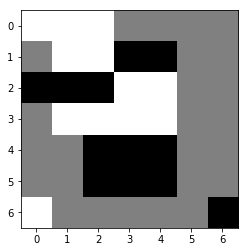

((0, 2), (0, 3)): n_v:   706 q_all:+0.008344 q:+0.029162 q_m:+0.018367 p:0.166266
((0, 1), (0, 3)): n_v:   172 q_all:+0.000951 q:-0.005163 q_m:+0.011755 p:0.045716
((6, 0), (6, 1)): n_v:   162 q_all:-0.003672 q:+0.001708 q_m:+0.006612 p:0.046204
((6, 0), (5, 1)): n_v:   158 q_all:-0.004253 q:+0.014283 q_m:+0.018367 p:0.045445
((3, 1), (4, 1)): n_v:   121 q_all:+0.002667 q:+0.003174 q_m:+0.018367 p:0.031453
((2, 4), (1, 5)): n_v:   119 q_all:-0.004669 q:+0.016421 q_m:+0.006612 p:0.034354
((1, 1), (0, 3)): n_v:   112 q_all:-0.007807 q:+0.015805 q_m:+0.011755 p:0.034021
((3, 4), (4, 5)): n_v:    76 q_all:+0.001669 q:+0.047915 q_m:+0.018367 p:0.020018
((2, 4), (3, 5)): n_v:    72 q_all:-0.013256 q:+0.022494 q_m:+0.006612 p:0.023399
((6, 0), (6, 2)): n_v:    60 q_all:-0.005414 q:+0.018050 q_m:+0.011755 p:0.017547
((0, 0), (1, 0)): n_v:    57 q_all:+0.001578 q:+0.005331 q_m:+0.018367 p:0.015139
((0, 2), (0, 4)): n_v:    56 q_all:+0.003683 q:+0.050777 q_m:+0.011755 p:0.014455
((2, 4), (2, 5))

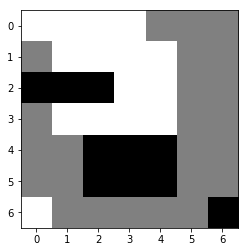

((4, 2), (4, 1)): n_v:   322 q_all:-0.014027 q:+0.007562 q_m:-0.000000 p:0.061443
((2, 2), (0, 4)): n_v:   224 q_all:-0.009239 q:-0.000122 q_m:+0.000735 p:0.038739
((5, 3), (6, 4)): n_v:   218 q_all:-0.033371 q:-0.014178 q_m:-0.011755 p:0.057290
((4, 4), (4, 5)): n_v:   198 q_all:-0.033561 q:+0.009737 q_m:-0.002939 p:0.052157
((5, 2), (6, 2)): n_v:   159 q_all:-0.038819 q:-0.028210 q_m:-0.011755 p:0.045050
((2, 0), (1, 0)): n_v:   151 q_all:-0.002264 q:+0.002973 q_m:+0.002939 p:0.022214
((6, 6), (4, 5)): n_v:   147 q_all:-0.040717 q:-0.005108 q_m:-0.006612 p:0.042786
((4, 4), (3, 5)): n_v:   139 q_all:-0.021326 q:+0.018180 q_m:-0.000000 p:0.030306
((2, 0), (4, 1)): n_v:   120 q_all:-0.021759 q:-0.004509 q_m:-0.000735 p:0.026308
((6, 6), (6, 4)): n_v:   116 q_all:-0.040245 q:-0.021146 q_m:-0.018367 p:0.033338
((4, 4), (2, 5)): n_v:   101 q_all:-0.025384 q:+0.022989 q_m:+0.000735 p:0.023591
((2, 2), (4, 1)): n_v:    83 q_all:-0.026881 q:+0.002795 q_m:-0.000735 p:0.019780
((2, 1), (4, 1))

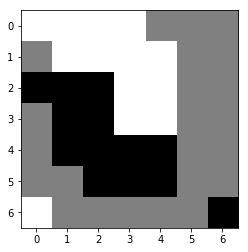

((6, 0), (5, 1)): n_v:  1029 q_all:+0.014644 q:+0.019183 q_m:+0.036000 p:0.251736
((2, 4), (3, 5)): n_v:   145 q_all:-0.015936 q:-0.008897 q_m:+0.006612 p:0.053161
((0, 0), (1, 0)): n_v:   123 q_all:+0.004980 q:-0.008102 q_m:+0.018367 p:0.034884
((6, 0), (5, 0)): n_v:   104 q_all:-0.001171 q:-0.001743 q_m:+0.006612 p:0.032116
((1, 4), (1, 5)): n_v:    96 q_all:-0.010964 q:+0.003641 q_m:+0.000735 p:0.033321
((0, 3), (0, 4)): n_v:    76 q_all:-0.006938 q:+0.005565 q_m:+0.000735 p:0.025150
((1, 1), (3, 0)): n_v:    71 q_all:-0.000058 q:+0.013364 q_m:+0.047020 p:0.021808
((3, 3), (5, 1)): n_v:    70 q_all:-0.004404 q:+0.014170 q_m:+0.026449 p:0.022702
((6, 0), (6, 1)): n_v:    68 q_all:-0.000569 q:-0.012410 q_m:+0.006612 p:0.020882
((3, 3), (5, 5)): n_v:    53 q_all:-0.003533 q:+0.024585 q_m:+0.026449 p:0.017087
((3, 4), (4, 5)): n_v:    52 q_all:+0.000048 q:+0.023980 q_m:+0.018367 p:0.015899
((1, 4), (2, 5)): n_v:    49 q_all:-0.028302 q:-0.009049 q_m:+0.000735 p:0.020596
((0, 3), (1, 5))

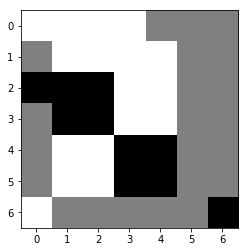

((5, 3), (6, 2)): n_v:   483 q_all:-0.027155 q:+0.008420 q_m:-0.002939 p:0.075924
((5, 3), (6, 4)): n_v:   319 q_all:-0.068244 q:-0.025905 q_m:-0.026449 p:0.096224
((5, 3), (6, 3)): n_v:   235 q_all:-0.048234 q:-0.021807 q_m:-0.011755 p:0.054482
((2, 0), (1, 0)): n_v:   226 q_all:-0.019538 q:-0.005587 q_m:-0.000000 p:0.029541
((4, 4), (4, 5)): n_v:   182 q_all:-0.054132 q:-0.021102 q_m:-0.011755 p:0.046019
((4, 4), (3, 5)): n_v:   143 q_all:-0.037229 q:+0.011704 q_m:-0.002939 p:0.027464
((6, 6), (6, 4)): n_v:   112 q_all:-0.080104 q:-0.041568 q_m:-0.036000 p:0.038785
((4, 4), (6, 2)): n_v:    98 q_all:-0.046484 q:-0.009146 q_m:-0.006612 p:0.022205
((3, 2), (5, 0)): n_v:    92 q_all:-0.056522 q:-0.022395 q_m:-0.000735 p:0.024217
((5, 4), (6, 2)): n_v:    91 q_all:-0.031013 q:-0.011512 q_m:-0.006612 p:0.015575
((2, 2), (0, 4)): n_v:    91 q_all:-0.052094 q:-0.026667 q_m:-0.000735 p:0.022403
((3, 1), (4, 0)): n_v:    73 q_all:-0.036378 q:+0.007336 q_m:-0.002939 p:0.013873
((3, 2), (1, 0))

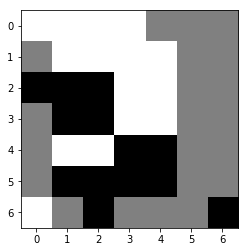

((6, 0), (6, 1)): n_v:   696 q_all:+0.026083 q:+0.012232 q_m:+0.059510 p:0.163359
((4, 1), (6, 3)): n_v:   267 q_all:+0.024675 q:+0.052705 q_m:+0.073469 p:0.064384
((4, 1), (3, 0)): n_v:   196 q_all:+0.022476 q:+0.035075 q_m:+0.059510 p:0.048909
((0, 0), (1, 0)): n_v:   139 q_all:+0.014195 q:-0.003017 q_m:+0.036000 p:0.039064
((4, 2), (6, 3)): n_v:   127 q_all:+0.012269 q:+0.041357 q_m:+0.073469 p:0.036792
((4, 1), (5, 0)): n_v:   109 q_all:+0.005608 q:+0.012158 q_m:+0.018367 p:0.034443
((4, 1), (4, 0)): n_v:   101 q_all:+0.005853 q:-0.012311 q_m:+0.036000 p:0.031734
((2, 4), (3, 5)): n_v:    91 q_all:-0.007808 q:-0.009754 q_m:+0.018367 p:0.033610
((1, 4), (1, 5)): n_v:    85 q_all:-0.003800 q:-0.010792 q_m:+0.006612 p:0.029893
((1, 4), (0, 5)): n_v:    82 q_all:+0.001045 q:-0.010544 q_m:+0.006612 p:0.027392
((3, 4), (4, 5)): n_v:    64 q_all:+0.007415 q:+0.009344 q_m:+0.036000 p:0.019746
((0, 3), (0, 4)): n_v:    62 q_all:-0.001919 q:+0.010295 q_m:+0.006612 p:0.021387
((0, 3), (0, 5))

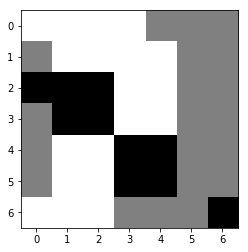

((5, 3), (6, 3)): n_v:  1417 q_all:-0.034336 q:-0.018159 q_m:-0.011755 p:0.216884
((2, 0), (1, 0)): n_v:   267 q_all:-0.029766 q:-0.021121 q_m:-0.002939 p:0.036372
((5, 3), (6, 4)): n_v:   250 q_all:-0.102092 q:-0.047577 q_m:-0.047020 p:0.101401
((3, 2), (5, 0)): n_v:    85 q_all:-0.062264 q:-0.034968 q_m:-0.000735 p:0.021791
((2, 2), (0, 4)): n_v:    85 q_all:-0.070588 q:-0.046831 q_m:-0.006612 p:0.024687
((4, 4), (3, 5)): n_v:    81 q_all:-0.059003 q:-0.011131 q_m:-0.011755 p:0.020044
((3, 1), (5, 0)): n_v:    73 q_all:-0.055875 q:-0.007309 q_m:-0.000735 p:0.017021
((6, 6), (6, 4)): n_v:    68 q_all:-0.117791 q:-0.069226 q_m:-0.059510 p:0.031905
((3, 2), (1, 0)): n_v:    52 q_all:-0.068128 q:-0.033367 q_m:-0.006612 p:0.014671
((3, 1), (1, 0)): n_v:    51 q_all:-0.066048 q:-0.021332 q_m:-0.006612 p:0.013982
((4, 4), (4, 5)): n_v:    47 q_all:-0.083225 q:-0.044532 q_m:-0.026449 p:0.015789
((6, 6), (5, 6)): n_v:    43 q_all:-0.093339 q:-0.050208 q_m:-0.047020 p:0.016273
((4, 4), (6, 3))

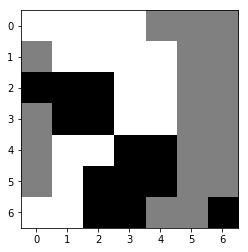

((4, 1), (3, 0)): n_v:   618 q_all:+0.052967 q:+0.094797 q_m:+0.088898 p:0.045503
((0, 3), (0, 4)): n_v:   403 q_all:+0.012385 q:+0.036072 q_m:+0.018367 p:0.084231
((0, 0), (1, 0)): n_v:   247 q_all:+0.037334 q:+0.010306 q_m:+0.059510 p:0.031110
((3, 4), (4, 5)): n_v:   219 q_all:+0.027210 q:+0.005965 q_m:+0.059510 p:0.035066
((1, 4), (1, 5)): n_v:   177 q_all:+0.008726 q:-0.014494 q_m:+0.018367 p:0.039266
((4, 2), (6, 4)): n_v:   170 q_all:+0.024477 q:+0.013735 q_m:+0.073469 p:0.028785
((4, 1), (5, 0)): n_v:   138 q_all:+0.011505 q:-0.003655 q_m:+0.018367 p:0.029300
((0, 2), (0, 4)): n_v:   129 q_all:-0.004668 q:+0.025570 q_m:+0.011755 p:0.034279
((1, 4), (2, 5)): n_v:    90 q_all:+0.002598 q:+0.000676 q_m:+0.018367 p:0.021909
((0, 3), (1, 5)): n_v:    89 q_all:+0.006276 q:+0.031897 q_m:+0.011755 p:0.020455
((2, 4), (3, 5)): n_v:    87 q_all:+0.008799 q:-0.006274 q_m:+0.036000 p:0.019212
((3, 3), (5, 5)): n_v:    86 q_all:+0.017763 q:-0.022074 q_m:+0.073469 p:0.016428
((1, 4), (0, 5))

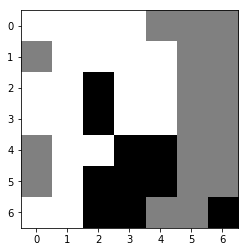

((3, 2), (1, 0)): n_v:   353 q_all:-0.035217 q:-0.043488 q_m:-0.000735 p:0.058504
((6, 2), (5, 0)): n_v:   335 q_all:-0.045896 q:-0.043908 q_m:-0.006612 p:0.069073
((3, 2), (5, 0)): n_v:   260 q_all:-0.053314 q:-0.021998 q_m:-0.006612 p:0.060912
((6, 2), (4, 0)): n_v:   210 q_all:-0.064389 q:-0.018517 q_m:-0.006612 p:0.057784
((2, 2), (4, 0)): n_v:   173 q_all:-0.034727 q:-0.004004 q_m:-0.006612 p:0.028478
((4, 4), (3, 5)): n_v:   165 q_all:-0.091724 q:-0.020550 q_m:-0.026449 p:0.062543
((4, 4), (4, 5)): n_v:   147 q_all:-0.099804 q:-0.046644 q_m:-0.047020 p:0.060210
((6, 6), (5, 6)): n_v:   122 q_all:-0.109519 q:-0.052339 q_m:-0.073469 p:0.054677
((5, 3), (6, 4)): n_v:   109 q_all:-0.103707 q:-0.064318 q_m:-0.073469 p:0.046402
((2, 2), (1, 0)): n_v:   103 q_all:-0.037385 q:-0.040965 q_m:-0.000735 p:0.017933
((6, 6), (4, 6)): n_v:    94 q_all:-0.121428 q:-0.054615 q_m:-0.088898 p:0.046571
((6, 6), (6, 4)): n_v:    78 q_all:-0.104070 q:-0.053585 q_m:-0.088898 p:0.033541
((6, 6), (4, 5))

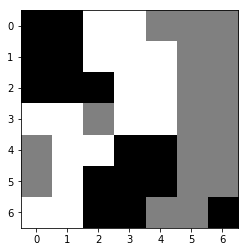

((2, 3), (3, 2)): n_v:  2236 q_all:+0.023616 q:+0.016007 q_m:+0.047020 p:0.196381
((3, 0), (3, 2)): n_v:    76 q_all:+0.012267 q:+0.005092 q_m:+0.036000 p:0.010171
((5, 1), (3, 2)): n_v:    67 q_all:+0.018746 q:+0.037769 q_m:+0.036000 p:0.007090
((1, 4), (3, 2)): n_v:    50 q_all:+0.014943 q:+0.013627 q_m:+0.036000 p:0.006222
((2, 4), (3, 2)): n_v:    43 q_all:+0.006913 q:-0.017932 q_m:+0.036000 p:0.006702
((3, 4), (3, 2)): n_v:    32 q_all:+0.008342 q:-0.011254 q_m:+0.036000 p:0.004789
((1, 2), (3, 2)): n_v:     6 q_all:-0.003171 q:+0.030776 q_m:+0.036000 p:0.001127
((1, 3), (3, 2)): n_v:     4 q_all:-0.009515 q:-0.009653 q_m:+0.036000 p:0.001083
((0, 3), (0, 4)): n_v:     2 q_all:-0.047871 q:-0.040684 q_m:+0.002939 p:0.000782
((1, 4), (1, 5)): n_v:     1 q_all:-0.039275 q:-0.047151 q_m:+0.002939 p:0.000246
((3, 4), (4, 5)): n_v:     1 q_all:-0.002275 q:+0.000174 q_m:+0.026449 p:0.000223
((2, 4), (0, 6)): n_v:     0 q_all:-0.009864 q:-0.041659 q_m:+0.000735 p:0.000003
((3, 3), (1, 5))

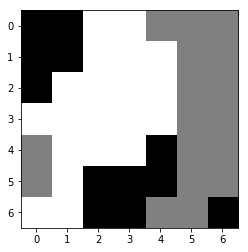

((2, 0), (4, 0)): n_v:   913 q_all:-0.022997 q:-0.004157 q_m:-0.000000 p:0.109620
((4, 4), (3, 5)): n_v:   806 q_all:-0.039133 q:-0.037526 q_m:-0.006612 p:0.135863
((4, 4), (4, 5)): n_v:   512 q_all:-0.043643 q:-0.051289 q_m:-0.018367 p:0.093319
((6, 2), (4, 0)): n_v:   324 q_all:-0.027923 q:-0.001342 q_m:-0.000000 p:0.043706
((6, 6), (4, 5)): n_v:   190 q_all:-0.054679 q:-0.077558 q_m:-0.026449 p:0.040990
((4, 4), (2, 5)): n_v:   180 q_all:-0.028744 q:-0.043287 q_m:-0.002939 p:0.024651
((5, 4), (3, 5)): n_v:   156 q_all:-0.047216 q:-0.064220 q_m:-0.011755 p:0.030073
((6, 2), (5, 0)): n_v:   150 q_all:-0.017593 q:-0.044223 q_m:-0.000000 p:0.015555
((6, 6), (4, 6)): n_v:   126 q_all:-0.072603 q:-0.087522 q_m:-0.047020 p:0.033969
((4, 4), (5, 5)): n_v:   121 q_all:-0.060273 q:-0.083859 q_m:-0.036000 p:0.027960
((5, 3), (6, 4)): n_v:   112 q_all:-0.057582 q:-0.088186 q_m:-0.036000 p:0.025106
((6, 3), (4, 5)): n_v:    81 q_all:-0.067999 q:-0.049254 q_m:-0.026449 p:0.020590
((6, 6), (5, 6))

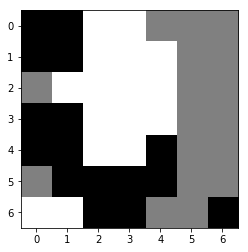

((2, 1), (2, 0)): n_v:  1955 q_all:+0.032219 q:-0.015668 q_m:+0.059510 p:0.578682
((6, 0), (5, 0)): n_v:   246 q_all:+0.035144 q:+0.105235 q_m:+0.036000 p:0.070271
((0, 2), (2, 0)): n_v:   220 q_all:+0.010829 q:-0.011628 q_m:+0.047020 p:0.082312
((4, 2), (2, 0)): n_v:    53 q_all:+0.002170 q:-0.032295 q_m:+0.047020 p:0.021383
((3, 4), (4, 5)): n_v:    43 q_all:+0.003295 q:+0.075633 q_m:+0.018367 p:0.017493
((3, 2), (2, 0)): n_v:    40 q_all:-0.018564 q:+0.017059 q_m:+0.047020 p:0.019225
((1, 4), (1, 5)): n_v:    21 q_all:-0.007260 q:+0.030797 q_m:+0.000735 p:0.009483
((1, 2), (2, 0)): n_v:    18 q_all:-0.011743 q:+0.001128 q_m:+0.047020 p:0.008130
((1, 4), (2, 5)): n_v:    18 q_all:-0.018299 q:+0.054801 q_m:+0.000735 p:0.009061
((2, 2), (2, 0)): n_v:    12 q_all:-0.020414 q:+0.056774 q_m:+0.047020 p:0.005892
((0, 3), (0, 4)): n_v:    11 q_all:-0.003677 q:+0.038953 q_m:+0.000735 p:0.004807
((1, 4), (0, 5)): n_v:     9 q_all:-0.001355 q:+0.031293 q_m:+0.000735 p:0.004024
((3, 4), (2, 6))

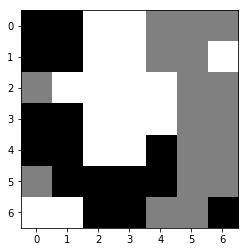

((4, 4), (3, 5)): n_v:   729 q_all:-0.009842 q:+0.034100 q_m:+0.018367 p:0.202659
((4, 4), (4, 5)): n_v:   277 q_all:-0.013602 q:+0.037381 q_m:+0.006612 p:0.081523
((5, 3), (6, 4)): n_v:   127 q_all:-0.022583 q:+0.020523 q_m:+0.000735 p:0.042475
((6, 6), (4, 5)): n_v:   115 q_all:-0.018534 q:+0.032317 q_m:+0.002939 p:0.036471
((5, 4), (3, 5)): n_v:    93 q_all:-0.014395 q:+0.034716 q_m:+0.011755 p:0.027906
((4, 4), (2, 5)): n_v:    85 q_all:-0.003179 q:+0.044068 q_m:+0.026449 p:0.021261
((1, 0), (2, 0)): n_v:    84 q_all:-0.012378 q:+0.036905 q_m:+0.006612 p:0.024244
((6, 3), (4, 5)): n_v:    78 q_all:-0.026198 q:+0.029065 q_m:+0.002939 p:0.027348
((4, 4), (5, 5)): n_v:    78 q_all:-0.025256 q:+0.012462 q_m:+0.000735 p:0.026939
((5, 3), (3, 5)): n_v:    75 q_all:-0.035098 q:+0.020724 q_m:+0.011755 p:0.028974
((4, 0), (5, 0)): n_v:    69 q_all:-0.003526 q:+0.021839 q_m:+0.018367 p:0.017489
((3, 0), (5, 0)): n_v:    44 q_all:+0.000803 q:+0.009719 q_m:+0.011755 p:0.010433
((0, 0), (2, 0))

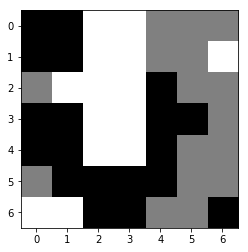

((1, 6), (2, 5)): n_v:  1830 q_all:-0.001541 q:+0.039471 q_m:+0.002939 p:0.537740
((0, 3), (2, 5)): n_v:   292 q_all:-0.004170 q:+0.043484 q_m:+0.000735 p:0.088580
((2, 1), (2, 0)): n_v:   174 q_all:+0.002130 q:-0.015367 q_m:+0.011755 p:0.048960
((1, 6), (2, 6)): n_v:   163 q_all:-0.027554 q:+0.002717 q_m:-0.002939 p:0.063503
((6, 0), (5, 0)): n_v:   141 q_all:+0.001560 q:+0.055613 q_m:+0.002939 p:0.040025
((1, 6), (1, 5)): n_v:    38 q_all:-0.037668 q:+0.020372 q_m:-0.002939 p:0.016498
((2, 3), (4, 5)): n_v:    37 q_all:-0.042442 q:+0.029305 q_m:+0.006612 p:0.016674
((0, 3), (1, 4)): n_v:    35 q_all:-0.019922 q:+0.019568 q_m:-0.002939 p:0.012747
((4, 3), (2, 5)): n_v:    35 q_all:-0.032797 q:+0.006558 q_m:+0.000735 p:0.014434
((0, 2), (2, 0)): n_v:    30 q_all:-0.015839 q:+0.005757 q_m:+0.006612 p:0.010457
((3, 3), (4, 5)): n_v:    22 q_all:-0.060433 q:+0.014402 q_m:+0.006612 p:0.011207
((3, 3), (2, 5)): n_v:    21 q_all:-0.069114 q:+0.039585 q_m:+0.000735 p:0.011553
((1, 3), (2, 5))

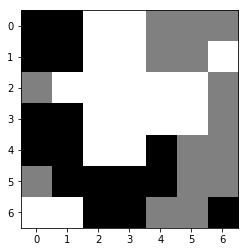

((4, 4), (4, 5)): n_v:  1177 q_all:-0.003275 q:+0.031223 q_m:+0.006612 p:0.147821
((1, 0), (2, 0)): n_v:   417 q_all:-0.010234 q:+0.015180 q_m:+0.000735 p:0.061792
((6, 6), (4, 5)): n_v:   324 q_all:-0.008436 q:+0.024445 q_m:+0.002939 p:0.046165
((4, 4), (5, 5)): n_v:   202 q_all:-0.025754 q:-0.011548 q_m:-0.000735 p:0.040127
((6, 3), (5, 5)): n_v:   161 q_all:-0.029149 q:-0.007412 q_m:-0.002939 p:0.033697
((6, 3), (4, 5)): n_v:   156 q_all:-0.008314 q:+0.031749 q_m:+0.002939 p:0.022243
((0, 0), (2, 0)): n_v:   140 q_all:-0.015547 q:+0.000895 q_m:-0.000000 p:0.023269
((4, 0), (5, 0)): n_v:   137 q_all:-0.005652 q:+0.001251 q_m:+0.006612 p:0.018393
((0, 1), (2, 0)): n_v:   105 q_all:-0.013659 q:+0.013656 q_m:-0.000000 p:0.016765
((6, 6), (5, 6)): n_v:    85 q_all:-0.024295 q:-0.003879 q_m:-0.000735 p:0.016504
((4, 0), (2, 0)): n_v:    68 q_all:-0.015784 q:-0.026007 q_m:-0.000000 p:0.011335
((6, 6), (4, 6)): n_v:    58 q_all:-0.023199 q:+0.008995 q_m:-0.000000 p:0.011166
((4, 4), (2, 6))

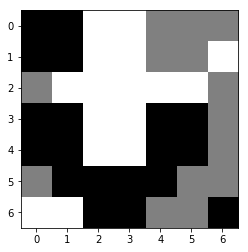

((2, 1), (2, 0)): n_v:   996 q_all:+0.011618 q:-0.020949 q_m:+0.026449 p:0.159685
((6, 0), (5, 0)): n_v:   586 q_all:+0.009315 q:+0.074718 q_m:+0.011755 p:0.098492
((1, 6), (2, 6)): n_v:   397 q_all:-0.014429 q:+0.043112 q_m:-0.000000 p:0.099241
((2, 5), (3, 6)): n_v:   189 q_all:-0.002727 q:+0.023062 q_m:+0.002939 p:0.039690
((0, 2), (2, 0)): n_v:   167 q_all:-0.005751 q:+0.006616 q_m:+0.018367 p:0.036787
((1, 6), (1, 5)): n_v:   137 q_all:-0.038404 q:+0.022715 q_m:-0.002939 p:0.045744
((0, 3), (1, 4)): n_v:    68 q_all:-0.017436 q:+0.019080 q_m:-0.002939 p:0.017797
((4, 2), (2, 0)): n_v:    43 q_all:-0.011061 q:-0.023657 q_m:+0.018367 p:0.010325
((0, 3), (0, 4)): n_v:    30 q_all:-0.042740 q:+0.002997 q_m:-0.002939 p:0.010707
((1, 6), (3, 6)): n_v:    30 q_all:-0.005906 q:+0.021336 q_m:+0.000735 p:0.006812
((1, 6), (0, 5)): n_v:    28 q_all:-0.038404 q:+0.022644 q_m:-0.002939 p:0.009133
((0, 3), (1, 5)): n_v:    21 q_all:-0.040131 q:+0.007542 q_m:-0.006612 p:0.007357
((3, 2), (2, 0))

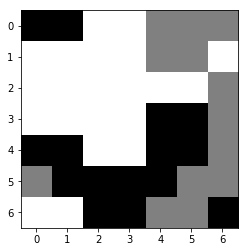

((3, 5), (1, 4)): n_v:   553 q_all:-0.005451 q:+0.035098 q_m:+0.011755 p:0.044045
((4, 0), (5, 0)): n_v:   452 q_all:-0.010471 q:-0.037585 q_m:-0.000735 p:0.043801
((3, 5), (3, 6)): n_v:   264 q_all:-0.036740 q:+0.000941 q_m:-0.006612 p:0.050189
((3, 5), (2, 6)): n_v:   223 q_all:-0.030255 q:+0.009444 q_m:-0.000735 p:0.037430
((4, 4), (5, 5)): n_v:   212 q_all:-0.050539 q:-0.033742 q_m:-0.018367 p:0.050714
((3, 5), (4, 6)): n_v:   166 q_all:-0.054224 q:-0.021109 q_m:-0.018367 p:0.041872
((4, 5), (5, 6)): n_v:   136 q_all:-0.049964 q:-0.033251 q_m:-0.018367 p:0.032378
((3, 4), (1, 5)): n_v:   126 q_all:-0.047881 q:+0.007335 q_m:-0.000000 p:0.028853
((6, 2), (5, 0)): n_v:   108 q_all:-0.024311 q:-0.031832 q_m:-0.002939 p:0.015913
((6, 3), (5, 5)): n_v:   105 q_all:-0.071337 q:-0.061743 q_m:-0.026449 p:0.033029
((3, 4), (1, 4)): n_v:    76 q_all:-0.034293 q:+0.006385 q_m:+0.011755 p:0.013920
((3, 4), (5, 6)): n_v:    66 q_all:-0.073250 q:-0.038744 q_m:-0.026449 p:0.021180
((3, 5), (1, 5))

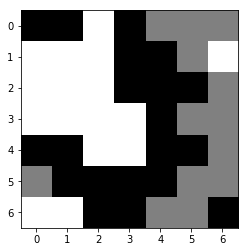

((1, 6), (3, 5)): n_v:   879 q_all:+0.009021 q:+0.029918 q_m:+0.026449 p:0.276371
((1, 6), (1, 5)): n_v:   656 q_all:+0.000972 q:-0.006968 q_m:+0.006612 p:0.226351
((1, 6), (0, 4)): n_v:   510 q_all:-0.000684 q:-0.021492 q_m:+0.002939 p:0.179105
((6, 0), (5, 0)): n_v:   180 q_all:+0.011176 q:+0.045883 q_m:+0.006612 p:0.055239
((0, 2), (0, 4)): n_v:   137 q_all:-0.032229 q:-0.051807 q_m:+0.002939 p:0.065010
((4, 3), (3, 5)): n_v:    59 q_all:-0.014150 q:-0.007645 q_m:+0.026449 p:0.024009
((3, 3), (1, 5)): n_v:    57 q_all:-0.052015 q:-0.017316 q_m:+0.002939 p:0.031547
((3, 0), (5, 0)): n_v:    36 q_all:-0.003435 q:-0.002009 q_m:+0.002939 p:0.013145
((1, 6), (0, 5)): n_v:    23 q_all:-0.020866 q:-0.025824 q_m:-0.000735 p:0.010040
((3, 3), (5, 5)): n_v:    20 q_all:-0.035730 q:+0.027879 q_m:+0.011755 p:0.010015
((2, 2), (0, 4)): n_v:    19 q_all:-0.084048 q:-0.009072 q_m:+0.002939 p:0.013246
((1, 2), (0, 4)): n_v:    18 q_all:-0.062138 q:+0.005192 q_m:+0.002939 p:0.010440
((4, 2), (6, 4))

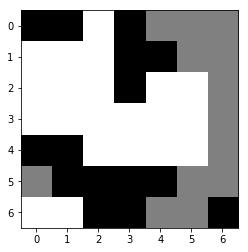

((5, 4), (5, 5)): n_v:   681 q_all:-0.030262 q:-0.009833 q_m:-0.000735 p:0.142205
((1, 4), (1, 5)): n_v:   423 q_all:-0.036871 q:+0.002221 q_m:-0.000735 p:0.098506
((4, 0), (5, 0)): n_v:   306 q_all:-0.034731 q:-0.036209 q_m:-0.000735 p:0.068853
((0, 3), (1, 5)): n_v:   303 q_all:-0.031120 q:-0.000294 q_m:-0.002939 p:0.064282
((6, 3), (5, 5)): n_v:   209 q_all:-0.044627 q:-0.031186 q_m:-0.002939 p:0.054420
((6, 6), (4, 6)): n_v:   192 q_all:-0.039292 q:-0.001538 q_m:-0.002939 p:0.046213
((6, 6), (5, 6)): n_v:   188 q_all:-0.049006 q:-0.033152 q_m:-0.006612 p:0.051763
((5, 4), (3, 6)): n_v:   148 q_all:-0.035455 q:+0.004058 q_m:-0.000000 p:0.033808
((1, 4), (3, 6)): n_v:   126 q_all:-0.036403 q:+0.016926 q_m:-0.000000 p:0.029073
((6, 2), (5, 0)): n_v:    94 q_all:-0.056015 q:-0.041940 q_m:-0.002939 p:0.028482
((2, 3), (1, 5)): n_v:    61 q_all:-0.044350 q:-0.019566 q_m:-0.002939 p:0.015853
((1, 3), (1, 5)): n_v:    31 q_all:-0.061550 q:-0.021744 q_m:-0.002939 p:0.009957
((5, 3), (5, 5))

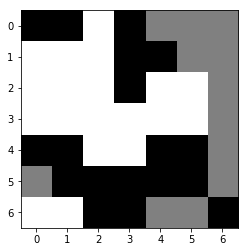

((0, 2), (0, 4)): n_v:   768 q_all:+0.005195 q:+0.045211 q_m:+0.036000 p:0.240842
((4, 2), (6, 4)): n_v:   421 q_all:+0.004312 q:+0.006207 q_m:+0.059510 p:0.133562
((2, 2), (0, 4)): n_v:   362 q_all:-0.027629 q:+0.048419 q_m:+0.036000 p:0.157774
((6, 0), (5, 0)): n_v:   327 q_all:+0.030844 q:+0.126786 q_m:+0.047020 p:0.071386
((2, 4), (1, 5)): n_v:   152 q_all:+0.004750 q:-0.010842 q_m:+0.011755 p:0.048037
((1, 2), (0, 4)): n_v:   145 q_all:-0.021487 q:-0.025149 q_m:+0.036000 p:0.060051
((4, 3), (6, 4)): n_v:   139 q_all:-0.005903 q:-0.004011 q_m:+0.059510 p:0.049234
((2, 5), (0, 4)): n_v:   122 q_all:+0.010529 q:-0.019718 q_m:+0.036000 p:0.035993
((3, 0), (5, 0)): n_v:    95 q_all:+0.017759 q:+0.067538 q_m:+0.036000 p:0.025417
((2, 4), (0, 4)): n_v:    60 q_all:-0.020909 q:+0.005086 q_m:+0.036000 p:0.025036
((2, 5), (1, 6)): n_v:    42 q_all:-0.010241 q:-0.024771 q_m:+0.002939 p:0.015539
((3, 5), (4, 6)): n_v:    12 q_all:+0.008051 q:+0.019650 q_m:+0.026449 p:0.003761
((2, 5), (3, 6))

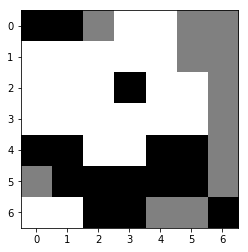

((0, 1), (0, 2)): n_v:  1125 q_all:-0.017898 q:+0.028593 q_m:+0.002939 p:0.313501
((0, 0), (0, 2)): n_v:  1064 q_all:-0.019609 q:+0.020517 q_m:+0.000735 p:0.303294
((2, 3), (0, 2)): n_v:   264 q_all:-0.012020 q:-0.008361 q_m:+0.000735 p:0.068020
((5, 3), (6, 4)): n_v:    70 q_all:-0.067866 q:-0.004868 q_m:-0.026449 p:0.032182
((4, 5), (3, 6)): n_v:    58 q_all:-0.037314 q:-0.014636 q_m:-0.002939 p:0.020186
((6, 6), (6, 4)): n_v:    56 q_all:-0.080612 q:-0.061110 q_m:-0.036000 p:0.028707
((4, 0), (5, 0)): n_v:    51 q_all:-0.022190 q:-0.026234 q_m:-0.002939 p:0.015248
((2, 3), (1, 5)): n_v:    46 q_all:-0.003296 q:-0.011825 q_m:+0.000735 p:0.010351
((4, 5), (4, 6)): n_v:    21 q_all:-0.077968 q:-0.080697 q_m:-0.011755 p:0.010453
((4, 5), (5, 6)): n_v:    12 q_all:-0.061558 q:-0.060445 q_m:-0.026449 p:0.005542
((6, 2), (6, 4)): n_v:    11 q_all:-0.109460 q:-0.042925 q_m:-0.036000 p:0.006744
((6, 2), (5, 0)): n_v:     8 q_all:-0.021283 q:-0.006520 q_m:-0.006612 p:0.002471
((5, 4), (6, 5))

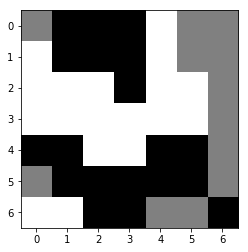

((6, 0), (5, 0)): n_v:   989 q_all:+0.017200 q:+0.106342 q_m:+0.026449 p:0.152819
((4, 2), (6, 4)): n_v:   484 q_all:-0.000256 q:+0.033304 q_m:+0.036000 p:0.104358
((3, 0), (5, 0)): n_v:   378 q_all:+0.004279 q:+0.072763 q_m:+0.018367 p:0.075606
((4, 3), (6, 4)): n_v:   228 q_all:-0.012130 q:+0.018566 q_m:+0.036000 p:0.058581
((1, 0), (0, 0)): n_v:   139 q_all:-0.006850 q:+0.005149 q_m:+0.011755 p:0.033164
((2, 5), (1, 6)): n_v:   130 q_all:-0.031214 q:-0.015993 q_m:-0.000000 p:0.042016
((0, 4), (0, 5)): n_v:   115 q_all:-0.036938 q:-0.015176 q_m:-0.000000 p:0.039751
((0, 4), (1, 5)): n_v:    79 q_all:-0.017205 q:-0.029882 q_m:-0.000000 p:0.021773
((2, 0), (0, 0)): n_v:    58 q_all:-0.018869 q:+0.003081 q_m:+0.006612 p:0.016392
((3, 5), (4, 6)): n_v:    57 q_all:-0.005698 q:+0.030769 q_m:+0.011755 p:0.013420
((2, 5), (2, 6)): n_v:    38 q_all:-0.033773 q:-0.024649 q_m:-0.000000 p:0.012688
((3, 2), (5, 0)): n_v:    37 q_all:-0.038648 q:+0.011834 q_m:+0.018367 p:0.013260
((3, 1), (5, 0))

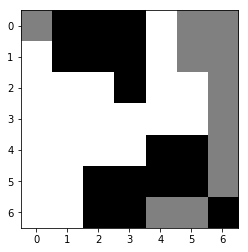

((0, 3), (1, 5)): n_v:   792 q_all:-0.030368 q:-0.008961 q_m:+0.002939 p:0.183194
((4, 5), (3, 6)): n_v:   684 q_all:-0.034677 q:-0.008535 q_m:-0.000735 p:0.168481
((2, 3), (1, 5)): n_v:   396 q_all:-0.033819 q:-0.043167 q_m:+0.002939 p:0.096364
((4, 5), (4, 6)): n_v:   201 q_all:-0.050632 q:-0.039519 q_m:-0.006612 p:0.060888
((5, 5), (3, 6)): n_v:   174 q_all:-0.039689 q:-0.050369 q_m:-0.002939 p:0.046197
((6, 6), (4, 6)): n_v:   139 q_all:-0.058838 q:-0.027374 q_m:-0.011755 p:0.046013
((1, 3), (1, 5)): n_v:   105 q_all:-0.073739 q:-0.042006 q_m:+0.002939 p:0.040556
((5, 4), (3, 6)): n_v:    65 q_all:-0.067592 q:+0.028633 q_m:-0.002939 p:0.023793
((4, 4), (2, 6)): n_v:    52 q_all:-0.085263 q:-0.044746 q_m:-0.002939 p:0.022171
((4, 5), (2, 6)): n_v:    52 q_all:-0.069453 q:-0.047289 q_m:-0.002939 p:0.019589
((4, 4), (3, 6)): n_v:    42 q_all:-0.086346 q:-0.053580 q_m:-0.002939 p:0.018073
((4, 5), (5, 6)): n_v:    30 q_all:-0.074880 q:-0.066607 q_m:-0.018367 p:0.011789
((5, 4), (4, 6))

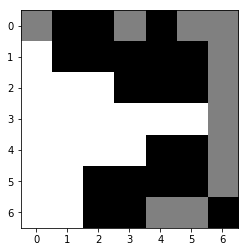

((2, 1), (0, 3)): n_v:  1358 q_all:-0.023936 q:+0.021282 q_m:+0.047020 p:0.515327
((2, 2), (0, 3)): n_v:   755 q_all:-0.006777 q:+0.081848 q_m:+0.047020 p:0.239099
((1, 0), (0, 0)): n_v:   174 q_all:+0.006046 q:+0.056891 q_m:+0.006612 p:0.047001
((4, 2), (6, 4)): n_v:   127 q_all:-0.037020 q:+0.011894 q_m:+0.026449 p:0.054287
((4, 3), (6, 5)): n_v:   119 q_all:-0.026610 q:-0.004464 q_m:+0.011755 p:0.046392
((4, 3), (6, 4)): n_v:    75 q_all:-0.025700 q:-0.006252 q_m:+0.026449 p:0.029062
((3, 5), (4, 6)): n_v:    37 q_all:-0.005937 q:+0.036398 q_m:+0.006612 p:0.011727
((3, 5), (5, 6)): n_v:    36 q_all:-0.000407 q:+0.010996 q_m:+0.011755 p:0.010603
((3, 5), (2, 6)): n_v:    31 q_all:-0.010723 q:+0.030642 q_m:+0.006612 p:0.010532
((3, 5), (3, 6)): n_v:    30 q_all:-0.004973 q:+0.027686 q_m:+0.006612 p:0.009490
((3, 5), (1, 6)): n_v:    29 q_all:-0.003577 q:+0.029133 q_m:+0.002939 p:0.008977
((2, 0), (0, 0)): n_v:    16 q_all:-0.017816 q:+0.007330 q_m:+0.002939 p:0.005907
((3, 4), (5, 6))

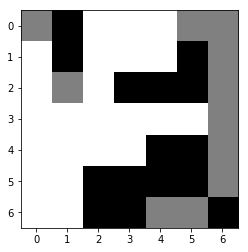

((1, 1), (2, 1)): n_v:  2941 q_all:+0.017026 q:+0.072293 q_m:+0.036000 p:0.890412
((0, 1), (2, 1)): n_v:   257 q_all:+0.012142 q:+0.063253 q_m:+0.026449 p:0.082078
((2, 3), (2, 1)): n_v:    26 q_all:-0.001516 q:+0.039825 q_m:+0.026449 p:0.009786
((1, 5), (0, 5)): n_v:     4 q_all:-0.027203 q:-0.046019 q_m:-0.006612 p:0.002002
((1, 5), (2, 6)): n_v:     2 q_all:-0.048362 q:-0.040657 q_m:-0.018367 p:0.001090
((2, 3), (0, 5)): n_v:     1 q_all:-0.038887 q:-0.081290 q_m:-0.011755 p:0.000878
((5, 4), (6, 5)): n_v:     1 q_all:-0.111618 q:-0.080779 q_m:-0.036000 p:0.001049
((6, 3), (6, 5)): n_v:     1 q_all:-0.113923 q:-0.067415 q_m:-0.047020 p:0.000622
((5, 3), (6, 4)): n_v:     1 q_all:-0.064733 q:-0.064429 q_m:-0.036000 p:0.000589
((4, 5), (4, 6)): n_v:     1 q_all:-0.046840 q:-0.050048 q_m:-0.018367 p:0.000518
((2, 4), (0, 6)): n_v:     0 q_all:-0.053705 q:-0.073757 q_m:-0.047020 p:0.000153
((4, 4), (6, 5)): n_v:     0 q_all:-0.053562 q:-0.073186 q_m:-0.047020 p:0.000130
((6, 6), (6, 4))

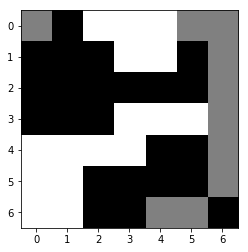

((3, 5), (2, 6)): n_v:   852 q_all:-0.034857 q:+0.007008 q_m:-0.002939 p:0.181761
((3, 5), (4, 6)): n_v:   579 q_all:-0.031973 q:+0.003906 q_m:-0.002939 p:0.118933
((0, 4), (0, 5)): n_v:   487 q_all:-0.030242 q:-0.032724 q_m:-0.011755 p:0.097577
((3, 5), (3, 6)): n_v:   395 q_all:-0.033488 q:+0.008175 q_m:-0.002939 p:0.082611
((4, 2), (6, 4)): n_v:   356 q_all:-0.036283 q:+0.006331 q_m:+0.000735 p:0.077474
((4, 3), (6, 4)): n_v:   265 q_all:-0.038587 q:-0.010166 q_m:+0.000735 p:0.059195
((0, 4), (2, 6)): n_v:   215 q_all:-0.041641 q:-0.009173 q_m:-0.006612 p:0.049981
((0, 4), (1, 6)): n_v:   171 q_all:-0.026072 q:-0.004799 q_m:-0.006612 p:0.032350
((0, 2), (0, 0)): n_v:   120 q_all:-0.034247 q:+0.001746 q_m:-0.000735 p:0.025469
((0, 4), (0, 6)): n_v:   107 q_all:-0.044468 q:-0.027312 q_m:-0.018367 p:0.025876
((4, 3), (6, 5)): n_v:    78 q_all:-0.032879 q:+0.046920 q_m:-0.000735 p:0.016145
((0, 3), (0, 5)): n_v:    76 q_all:-0.067250 q:-0.026149 q_m:-0.018367 p:0.023073
((3, 4), (5, 6))

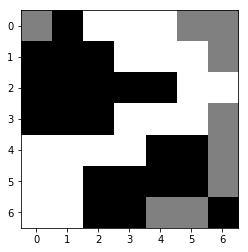

((4, 5), (3, 6)): n_v:  2080 q_all:+0.024208 q:+0.113037 q_m:+0.059510 p:0.660759
((5, 5), (3, 6)): n_v:   169 q_all:+0.009930 q:+0.083497 q_m:+0.047020 p:0.062361
((5, 4), (3, 6)): n_v:   116 q_all:+0.007589 q:+0.089897 q_m:+0.047020 p:0.043856
((4, 5), (4, 6)): n_v:    63 q_all:-0.000367 q:+0.047945 q_m:+0.018367 p:0.025923
((2, 4), (3, 6)): n_v:    56 q_all:+0.007873 q:+0.075724 q_m:+0.047020 p:0.021240
((4, 4), (3, 6)): n_v:    45 q_all:-0.007248 q:+0.058478 q_m:+0.047020 p:0.019846
((4, 5), (5, 6)): n_v:    24 q_all:-0.006514 q:+0.040273 q_m:+0.006612 p:0.010606
((5, 3), (6, 4)): n_v:    18 q_all:+0.004546 q:+0.053576 q_m:+0.006612 p:0.007310
((6, 6), (4, 6)): n_v:    17 q_all:-0.001974 q:+0.048766 q_m:+0.011755 p:0.007283
((5, 4), (6, 5)): n_v:    11 q_all:-0.021534 q:+0.038480 q_m:+0.006612 p:0.005535
((6, 6), (6, 4)): n_v:     6 q_all:+0.000850 q:+0.048920 q_m:+0.002939 p:0.002731
((0, 1), (0, 0)): n_v:     5 q_all:-0.001380 q:+0.038381 q_m:+0.006612 p:0.002164
((6, 2), (6, 4))

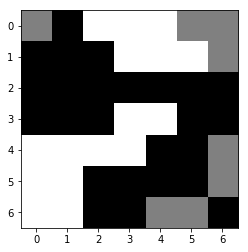

((1, 5), (1, 6)): n_v:  1783 q_all:-0.031958 q:-0.009969 q_m:-0.011755 p:0.314531
((3, 4), (4, 6)): n_v:   508 q_all:-0.038071 q:+0.019968 q_m:-0.000735 p:0.098961
((0, 4), (1, 6)): n_v:   420 q_all:-0.044479 q:-0.021772 q_m:-0.018367 p:0.090113
((0, 4), (0, 5)): n_v:   294 q_all:-0.063693 q:-0.032051 q_m:-0.047020 p:0.080517
((4, 3), (6, 4)): n_v:   145 q_all:-0.052343 q:-0.022418 q_m:-0.000735 p:0.034706
((4, 2), (6, 4)): n_v:   142 q_all:-0.051778 q:-0.014156 q_m:-0.000735 p:0.033766
((3, 4), (5, 6)): n_v:   137 q_all:-0.043635 q:+0.008884 q_m:-0.006612 p:0.029050
((0, 2), (0, 0)): n_v:   120 q_all:-0.050039 q:-0.006977 q_m:-0.006612 p:0.027808
((0, 4), (0, 6)): n_v:   115 q_all:-0.093805 q:-0.039086 q_m:-0.059510 p:0.042083
((3, 4), (1, 6)): n_v:    78 q_all:-0.062808 q:-0.014852 q_m:-0.018367 p:0.021382
((1, 5), (0, 6)): n_v:    53 q_all:-0.077875 q:-0.028200 q_m:-0.047020 p:0.017097
((0, 3), (0, 5)): n_v:    49 q_all:-0.112096 q:-0.035612 q_m:-0.059510 p:0.020404
((4, 3), (6, 5))

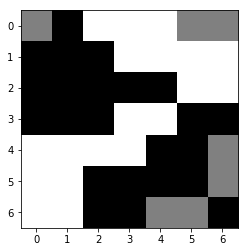

((3, 5), (4, 6)): n_v:   926 q_all:+0.007529 q:+0.064013 q_m:+0.018367 p:0.108429
((2, 3), (0, 5)): n_v:   521 q_all:+0.032221 q:+0.062084 q_m:+0.105796 p:0.020251
((5, 4), (6, 5)): n_v:   405 q_all:-0.003635 q:+0.041161 q_m:+0.018367 p:0.061808
((2, 4), (0, 5)): n_v:   291 q_all:+0.033663 q:+0.062309 q_m:+0.105796 p:0.009960
((5, 3), (6, 4)): n_v:   213 q_all:+0.002742 q:+0.080312 q_m:+0.018367 p:0.028241
((6, 6), (4, 6)): n_v:   193 q_all:+0.003708 q:+0.058288 q_m:+0.011755 p:0.024996
((6, 3), (6, 5)): n_v:   170 q_all:-0.009630 q:+0.038007 q_m:+0.011755 p:0.029257
((4, 5), (5, 6)): n_v:   160 q_all:-0.008662 q:+0.068332 q_m:+0.018367 p:0.027099
((6, 6), (6, 4)): n_v:    80 q_all:-0.004063 q:+0.071115 q_m:+0.011755 p:0.012288
((3, 6), (5, 6)): n_v:    57 q_all:-0.002584 q:+0.039516 q_m:+0.011755 p:0.008538
((6, 2), (6, 4)): n_v:    52 q_all:-0.006474 q:+0.035629 q_m:+0.011755 p:0.008371
((0, 1), (0, 0)): n_v:    35 q_all:-0.001309 q:+0.063806 q_m:+0.018367 p:0.005059
((5, 3), (6, 5))

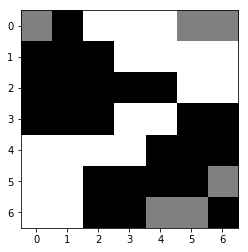

((0, 4), (0, 5)): n_v:   875 q_all:-0.022403 q:+0.004484 q_m:-0.011755 p:0.136690
((3, 4), (5, 6)): n_v:   681 q_all:-0.030984 q:+0.083740 q_m:+0.006612 p:0.127352
((4, 3), (6, 4)): n_v:   240 q_all:-0.039591 q:+0.014917 q_m:+0.006612 p:0.052256
((0, 4), (0, 6)): n_v:   206 q_all:-0.050920 q:-0.035678 q_m:-0.018367 p:0.053340
((4, 2), (6, 4)): n_v:   203 q_all:-0.038912 q:+0.033796 q_m:+0.006612 p:0.043879
((0, 2), (0, 0)): n_v:   160 q_all:-0.032676 q:+0.030801 q_m:+0.000735 p:0.030894
((2, 6), (0, 6)): n_v:   145 q_all:-0.078979 q:-0.023621 q_m:-0.018367 p:0.052093
((2, 6), (0, 5)): n_v:    96 q_all:-0.079121 q:-0.032164 q_m:-0.018367 p:0.034470
((0, 3), (0, 5)): n_v:    84 q_all:-0.092545 q:-0.032878 q_m:-0.018367 p:0.034339
((4, 3), (6, 5)): n_v:    64 q_all:-0.043690 q:+0.031073 q_m:+0.000735 p:0.014873
((1, 5), (0, 6)): n_v:    52 q_all:-0.042852 q:-0.013686 q_m:-0.011755 p:0.012063
((1, 3), (0, 5)): n_v:    24 q_all:-0.092678 q:-0.023905 q_m:-0.018367 p:0.009643
((2, 5), (0, 6))

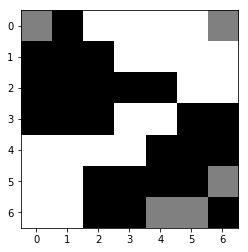

((5, 3), (6, 4)): n_v:  1127 q_all:+0.002661 q:+0.066888 q_m:+0.018367 p:0.126494
((4, 5), (5, 6)): n_v:   349 q_all:+0.007473 q:+0.043923 q_m:+0.018367 p:0.033167
((6, 6), (6, 4)): n_v:   289 q_all:+0.002771 q:+0.065255 q_m:+0.011755 p:0.032248
((5, 4), (6, 5)): n_v:   230 q_all:-0.004821 q:+0.046451 q_m:+0.018367 p:0.032085
((4, 6), (6, 4)): n_v:   148 q_all:-0.010027 q:+0.053995 q_m:+0.011755 p:0.023509
((6, 2), (6, 4)): n_v:   141 q_all:-0.007013 q:+0.007429 q_m:+0.011755 p:0.020824
((2, 4), (0, 6)): n_v:   115 q_all:+0.023909 q:+0.044524 q_m:+0.073469 p:0.004096
((0, 1), (0, 0)): n_v:   111 q_all:+0.003628 q:+0.054164 q_m:+0.018367 p:0.012038
((3, 6), (5, 6)): n_v:    85 q_all:-0.006296 q:+0.018222 q_m:+0.011755 p:0.012349
((2, 0), (0, 0)): n_v:    74 q_all:-0.013949 q:+0.006829 q_m:+0.011755 p:0.012761
((5, 2), (6, 4)): n_v:    68 q_all:-0.008972 q:-0.020631 q_m:+0.011755 p:0.010571
((6, 3), (6, 5)): n_v:    64 q_all:-0.014733 q:+0.025423 q_m:+0.011755 p:0.011166
((4, 6), (6, 5))

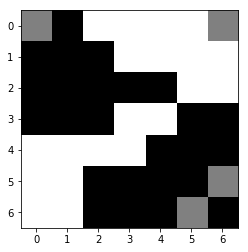

((4, 3), (6, 5)): n_v:  1765 q_all:-0.030066 q:+0.025703 q_m:+0.006612 p:0.441827
((3, 4), (5, 6)): n_v:   720 q_all:-0.047660 q:+0.037866 q_m:+0.006612 p:0.224118
((0, 5), (0, 6)): n_v:   252 q_all:-0.030322 q:-0.023081 q_m:-0.011755 p:0.063288
((2, 6), (0, 6)): n_v:   174 q_all:-0.085202 q:-0.047378 q_m:-0.018367 p:0.077147
((0, 2), (0, 0)): n_v:    74 q_all:-0.036371 q:+0.034864 q_m:+0.000735 p:0.020128
((0, 4), (0, 6)): n_v:    36 q_all:-0.099524 q:-0.023219 q_m:-0.018367 p:0.017884
((2, 5), (0, 6)): n_v:    14 q_all:-0.116869 q:-0.014179 q_m:-0.018367 p:0.007932
((1, 4), (0, 6)): n_v:     8 q_all:-0.121754 q:-0.033194 q_m:-0.018367 p:0.004757
-1 's turn


This is a random move


one move takes time(s):  0.11533021926879883
no. of data collected:  8


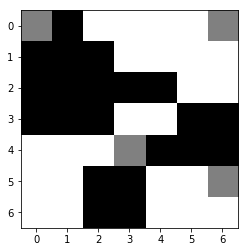

((3, 2), (4, 3)): n_v:  3305 q_all:+0.026881 q:+0.102567 q_m:+0.026449 p:0.300550
((6, 2), (4, 3)): n_v:    95 q_all:+0.008057 q:+0.055008 q_m:+0.018367 p:0.014390
((6, 3), (4, 3)): n_v:    34 q_all:+0.013247 q:+0.108668 q_m:+0.018367 p:0.004650
((2, 1), (4, 3)): n_v:    18 q_all:-0.019923 q:+0.036903 q_m:+0.018367 p:0.004481
((2, 3), (4, 3)): n_v:    17 q_all:-0.007739 q:+0.065036 q_m:+0.018367 p:0.003243
((2, 4), (4, 3)): n_v:    14 q_all:+0.008120 q:+0.057900 q_m:+0.018367 p:0.002153
((2, 2), (4, 3)): n_v:    11 q_all:-0.003703 q:+0.076482 q_m:+0.018367 p:0.002199
((4, 5), (4, 3)): n_v:     9 q_all:-0.004728 q:+0.057253 q_m:+0.018367 p:0.001770
((3, 1), (4, 3)): n_v:     7 q_all:-0.003362 q:+0.046834 q_m:+0.018367 p:0.001471
((3, 5), (4, 3)): n_v:     6 q_all:-0.005503 q:+0.054024 q_m:+0.018367 p:0.001287
((4, 5), (5, 6)): n_v:     1 q_all:+0.004825 q:+0.121828 q_m:+0.011755 p:0.000169
((2, 4), (0, 6)): n_v:     0 q_all:-0.000400 q:-0.021438 q_m:+0.006612 p:0.000002
((3, 5), (5, 6))

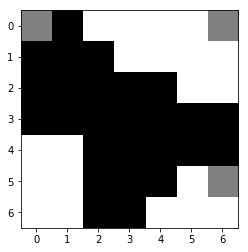

((5, 5), (5, 6)): n_v:  2762 q_all:+0.008180 q:-0.040684 q_m:-0.000735 p:0.228627
((6, 4), (5, 6)): n_v:   463 q_all:-0.028415 q:-0.039622 q_m:-0.002939 p:0.084070
((0, 2), (0, 0)): n_v:   430 q_all:-0.016675 q:+0.014776 q_m:-0.000000 p:0.064444
((0, 4), (0, 6)): n_v:   309 q_all:-0.068142 q:-0.098830 q_m:-0.026449 p:0.089212
((2, 6), (0, 6)): n_v:   232 q_all:-0.068170 q:-0.096032 q_m:-0.026449 p:0.066745
((1, 4), (0, 6)): n_v:    40 q_all:-0.057866 q:-0.025018 q_m:-0.026449 p:0.010668
((2, 5), (0, 6)): n_v:    34 q_all:-0.058629 q:-0.028676 q_m:-0.026449 p:0.008658
((0, 5), (0, 6)): n_v:    25 q_all:-0.047965 q:-0.038995 q_m:-0.018367 p:0.005801
-1 's turn


This is a random move


one move takes time(s):  0.06789994239807129
no. of data collected:  8


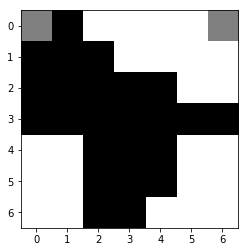

((0, 1), (0, 0)): n_v:  2499 q_all:+0.012744 q:-0.272021 q_m:+0.002939 p:0.279537
((2, 0), (0, 0)): n_v:  1017 q_all:-0.013050 q:+0.000655 q_m:+0.000735 p:0.188392
((2, 4), (0, 6)): n_v:   402 q_all:+0.022131 q:+0.017178 q_m:+0.036000 p:0.034264
((1, 2), (0, 0)): n_v:    67 q_all:-0.007691 q:+0.024048 q_m:+0.000735 p:0.011506
((2, 2), (0, 0)): n_v:    38 q_all:-0.136123 q:-0.433018 q_m:+0.000735 p:0.020374
((2, 1), (0, 0)): n_v:    14 q_all:-0.174111 q:-0.623742 q_m:+0.000735 p:0.008880
1 's turn
one move takes time(s):  0.051397085189819336
no. of data collected:  8


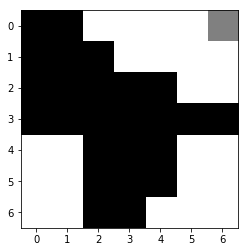

((0, 4), (0, 6)): n_v:  2545 q_all:-0.104713 q:-0.145223 q_m:-0.002939 p:0.268575
((2, 6), (0, 6)): n_v:  1025 q_all:-0.185494 q:-0.108798 q_m:-0.002939 p:0.349617
((2, 5), (0, 6)): n_v:   300 q_all:-0.161669 q:-0.017361 q_m:-0.002939 p:0.079812
((1, 4), (0, 6)): n_v:   215 q_all:-0.163712 q:-0.039542 q_m:-0.002939 p:0.059958
((0, 5), (0, 6)): n_v:    29 q_all:-1.000000 q:+5.000000 q_m:-0.000735 p:0.081382
-1 's turn
one move takes time(s):  0.0467829704284668
no. of data collected:  8


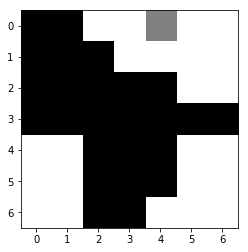

((2, 2), (0, 4)): n_v:  2322 q_all:+0.030578 q:+0.152791 q_m:+0.105796 p:0.460232
((2, 3), (0, 4)): n_v:   939 q_all:+0.039833 q:+0.263366 q_m:+0.105796 p:0.160758
((1, 2), (0, 4)): n_v:   734 q_all:-0.043917 q:+0.208994 q_m:+0.105796 p:0.304355
((2, 4), (0, 4)): n_v:   144 q_all:-0.080461 q:+0.021471 q_m:+0.105796 p:0.073709
1 's turn
one move takes time(s):  0.048835039138793945
no. of data collected:  8


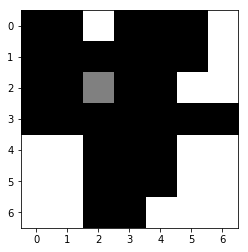

((4, 0), (2, 2)): n_v:  1500 q_all:-0.545597 q:+0.021840 q_m:+0.011755 p:0.424661
((0, 2), (2, 2)): n_v:  1340 q_all:-0.531235 q:+0.095243 q_m:+0.011755 p:0.322201
((4, 1), (2, 2)): n_v:   840 q_all:-0.551601 q:-0.008423 q_m:+0.011755 p:0.253124
-1 's turn
one move takes time(s):  0.040502071380615234
no. of data collected:  8


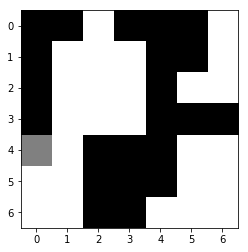

((3, 0), (4, 0)): n_v:  3003 q_all:+1.000000 q:+5.000000 q_m:+0.018367 p:0.619939
((2, 0), (4, 0)): n_v:    43 q_all:-0.236855 q:+0.012453 q_m:+0.011755 p:0.186313
((6, 2), (4, 0)): n_v:    38 q_all:-0.256312 q:-0.147949 q_m:+0.011755 p:0.168033
((5, 2), (4, 0)): n_v:     3 q_all:-0.225734 q:+0.094154 q_m:+0.011755 p:0.015690
((4, 2), (4, 0)): n_v:     2 q_all:-0.330705 q:-0.019497 q_m:+0.011755 p:0.009975
this self play has 67 steps, time elapsed 61.499319314956665
winner is -1.0
episode 1 finished
episode 2 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.16378355026245117
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.19078516960144043
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2645697593688965
no. of data collected:  8
1 's turn
one move takes time(s):  0.29225802421569824
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s): 

one move takes time(s):  0.5413336753845215
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7201962471008301
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7013530731201172
no. of data collected:  8
1 's turn
one move takes time(s):  0.8186960220336914
no. of data collected:  8
-1 's turn
one move takes time(s):  0.809929609298706
no. of data collected:  8
1 's turn
one move takes time(s):  1.0053114891052246
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0671055316925049
no. of data collected:  8
1 's turn
one move takes time(s):  1.2478761672973633
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0242373943328857
no. of data collected:  8
1 's turn
one move takes time(s):  1.0110692977905273
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1739511489868164
no. of data collected:  8
1 's turn
one move takes time(s):  1.0301661491394043
no. of data collected:  8
-1 's turn
one move 

due to time lim, final rollout times:  49 time elapsed:  6.30626106262207
one move takes time(s):  6.3074562549591064
no. of data collected:  8
1 's turn
one move takes time(s):  0.871401309967041
no. of data collected:  8
-1 's turn
one move takes time(s):  1.132906198501587
no. of data collected:  8
1 's turn
one move takes time(s):  1.03861403465271
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0107753276824951
no. of data collected:  8
1 's turn
one move takes time(s):  1.0890822410583496
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9507269859313965
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.8992946147918701
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8871974945068359
no. of data collected:  8
1 's turn
one move takes time(s):  0.6956441402435303
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6858534812927246
no. of data collected:  8
1 's turn
one move takes time

one move takes time(s):  0.20695829391479492
no. of data collected:  8
1 's turn
one move takes time(s):  0.15358281135559082
no. of data collected:  8
-1 's turn
one move takes time(s):  0.18247342109680176
no. of data collected:  8
1 's turn
one move takes time(s):  0.09145569801330566
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.09479570388793945
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.0751183032989502
no. of data collected:  8
-1 's turn
one move takes time(s):  0.061044931411743164
no. of data collected:  8
1 's turn
one move takes time(s):  0.06900572776794434
no. of data collected:  8
-1 's turn
one move takes time(s):  0.05865645408630371
no. of data collected:  8
1 's turn
one move takes time(s):  0.05271029472351074
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.04210782051086426
no. of data collected:  8
this self play has 69 steps, time el

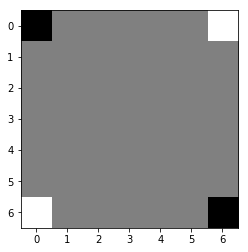

((6, 6), (6, 5)): n_v:   193 q_all:+0.001408 q:+0.025765 q_m:+0.000735 p:0.086930
((6, 6), (5, 6)): n_v:   191 q_all:+0.001712 q:+0.014693 q_m:+0.000735 p:0.086098
((6, 6), (5, 5)): n_v:   184 q_all:+0.002678 q:+0.019983 q_m:+0.000735 p:0.082083
((0, 0), (1, 1)): n_v:   184 q_all:+0.000483 q:+0.004937 q_m:+0.000735 p:0.083746
((0, 0), (0, 1)): n_v:   180 q_all:+0.000887 q:+0.005949 q_m:+0.000735 p:0.081695
((0, 0), (1, 0)): n_v:   179 q_all:+0.000492 q:-0.000797 q_m:+0.000735 p:0.081638
((6, 6), (6, 4)): n_v:   127 q_all:+0.000033 q:+0.011792 q_m:-0.000000 p:0.057869
((6, 6), (4, 6)): n_v:   123 q_all:+0.002930 q:+0.001872 q_m:-0.000000 p:0.054684
((0, 0), (0, 2)): n_v:   121 q_all:+0.000389 q:-0.005670 q_m:-0.000000 p:0.055116
((0, 0), (2, 0)): n_v:   113 q_all:-0.000354 q:-0.005948 q_m:-0.000000 p:0.051964
((6, 6), (5, 4)): n_v:   107 q_all:+0.000849 q:+0.011021 q_m:-0.000000 p:0.048725
((6, 6), (4, 5)): n_v:   105 q_all:+0.002583 q:+0.011597 q_m:-0.000000 p:0.046961
((0, 0), (1, 2))

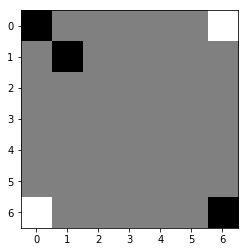

((6, 0), (5, 1)): n_v:   250 q_all:+0.000913 q:-0.019108 q_m:-0.000000 p:0.102178
((0, 6), (0, 5)): n_v:   241 q_all:-0.000974 q:+0.014816 q_m:-0.000000 p:0.100051
((6, 0), (6, 1)): n_v:   238 q_all:-0.000044 q:-0.001225 q_m:-0.000000 p:0.098188
((0, 6), (1, 5)): n_v:   236 q_all:-0.001906 q:+0.001596 q_m:-0.000000 p:0.099176
((6, 0), (5, 0)): n_v:   232 q_all:+0.002434 q:+0.001223 q_m:-0.000000 p:0.093269
((0, 6), (1, 6)): n_v:   218 q_all:-0.002018 q:+0.014816 q_m:-0.000000 p:0.091814
((0, 6), (2, 6)): n_v:   114 q_all:-0.001904 q:-0.002512 q_m:-0.000735 p:0.047890
((0, 6), (1, 4)): n_v:   106 q_all:-0.005077 q:-0.005001 q_m:-0.000735 p:0.046141
((6, 0), (4, 0)): n_v:   104 q_all:-0.002768 q:-0.004605 q_m:-0.000735 p:0.044261
((6, 0), (5, 2)): n_v:   102 q_all:-0.000385 q:-0.007529 q_m:-0.000735 p:0.042424
((6, 0), (6, 2)): n_v:   100 q_all:-0.000298 q:-0.005541 q_m:-0.000735 p:0.041636
((0, 6), (0, 4)): n_v:   100 q_all:-0.004543 q:-0.005371 q_m:-0.000735 p:0.043207
((0, 6), (2, 5))

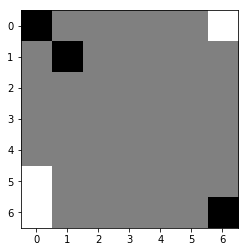

((1, 1), (2, 0)): n_v:   182 q_all:-0.000593 q:-0.008943 q_m:+0.000735 p:0.066390
((1, 1), (0, 2)): n_v:   167 q_all:-0.000282 q:-0.006615 q_m:+0.000735 p:0.060699
((6, 6), (5, 5)): n_v:   140 q_all:+0.000662 q:-0.000800 q_m:+0.000735 p:0.050651
((1, 1), (1, 2)): n_v:   137 q_all:-0.000676 q:-0.010523 q_m:+0.000735 p:0.050124
((1, 1), (2, 1)): n_v:   137 q_all:-0.001485 q:-0.010152 q_m:+0.000735 p:0.050548
((6, 6), (6, 5)): n_v:   133 q_all:-0.000824 q:+0.004346 q_m:+0.000735 p:0.048974
((6, 6), (5, 6)): n_v:   131 q_all:+0.001093 q:-0.004179 q_m:+0.000735 p:0.047091
((0, 0), (0, 1)): n_v:   131 q_all:-0.000710 q:-0.022076 q_m:+0.000735 p:0.048029
((0, 0), (1, 0)): n_v:   124 q_all:-0.000865 q:-0.020869 q_m:+0.000735 p:0.045539
((1, 1), (2, 2)): n_v:   107 q_all:-0.000163 q:-0.016122 q_m:+0.000735 p:0.038884
((1, 1), (3, 1)): n_v:    82 q_all:-0.002865 q:-0.023431 q_m:-0.000000 p:0.030922
((1, 1), (1, 3)): n_v:    80 q_all:-0.001577 q:-0.018168 q_m:-0.000000 p:0.029671
((0, 0), (0, 2))

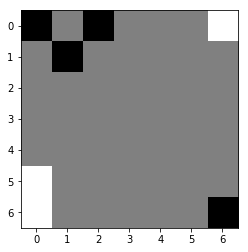

((5, 0), (6, 1)): n_v:   255 q_all:+0.001677 q:+0.003957 q_m:-0.000000 p:0.090209
((0, 6), (0, 5)): n_v:   250 q_all:+0.002210 q:+0.008888 q_m:-0.000000 p:0.087907
((5, 0), (5, 1)): n_v:   193 q_all:+0.001447 q:-0.014217 q_m:-0.000000 p:0.068651
((0, 6), (1, 5)): n_v:   177 q_all:+0.001603 q:+0.000941 q_m:-0.000000 p:0.062794
((0, 6), (1, 6)): n_v:   175 q_all:+0.001181 q:+0.010029 q_m:-0.000000 p:0.062411
((5, 0), (4, 0)): n_v:   144 q_all:+0.001070 q:+0.009653 q_m:-0.000000 p:0.051269
((5, 0), (4, 1)): n_v:   117 q_all:+0.002319 q:+0.006367 q_m:-0.000000 p:0.041309
((0, 6), (1, 4)): n_v:    97 q_all:-0.004972 q:-0.002485 q_m:-0.000735 p:0.037135
((0, 6), (2, 6)): n_v:    81 q_all:+0.001404 q:-0.000345 q_m:-0.000735 p:0.028745
((5, 0), (5, 2)): n_v:    81 q_all:-0.003327 q:-0.013255 q_m:-0.000735 p:0.030298
((6, 0), (5, 2)): n_v:    78 q_all:-0.000434 q:+0.009945 q_m:-0.000735 p:0.028393
((0, 6), (0, 4)): n_v:    70 q_all:-0.003354 q:-0.003120 q_m:-0.000735 p:0.026376
((6, 0), (4, 0))

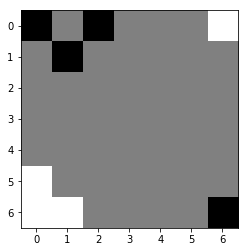

((0, 2), (1, 3)): n_v:   131 q_all:-0.001882 q:-0.011868 q_m:+0.000735 p:0.044414
((6, 6), (5, 5)): n_v:   127 q_all:-0.000353 q:+0.001870 q_m:+0.000735 p:0.042265
((1, 1), (2, 0)): n_v:   121 q_all:-0.001227 q:+0.006997 q_m:+0.000735 p:0.040807
((6, 6), (5, 6)): n_v:   114 q_all:-0.000282 q:+0.001322 q_m:+0.000735 p:0.037848
((1, 1), (2, 1)): n_v:   110 q_all:-0.001795 q:+0.002874 q_m:+0.000735 p:0.037272
((0, 2), (0, 3)): n_v:   110 q_all:+0.000408 q:-0.007114 q_m:+0.000735 p:0.036432
((6, 6), (6, 5)): n_v:   109 q_all:-0.002137 q:+0.008240 q_m:+0.000735 p:0.036984
((0, 0), (1, 0)): n_v:   104 q_all:-0.001628 q:-0.004795 q_m:+0.000735 p:0.035051
((0, 0), (0, 1)): n_v:   101 q_all:-0.000618 q:-0.004093 q_m:+0.000735 p:0.033731
((0, 2), (1, 2)): n_v:    95 q_all:-0.001550 q:-0.001202 q_m:+0.000735 p:0.032279
((1, 1), (2, 2)): n_v:    89 q_all:-0.001229 q:-0.000403 q_m:+0.000735 p:0.029933
((0, 2), (1, 0)): n_v:    86 q_all:-0.002919 q:-0.036571 q_m:-0.000000 p:0.029627
((0, 2), (0, 4))

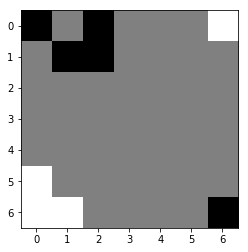

((0, 6), (0, 5)): n_v:   309 q_all:+0.000760 q:+0.012444 q_m:-0.000000 p:0.115611
((6, 1), (5, 2)): n_v:   202 q_all:+0.000629 q:+0.016819 q_m:-0.000000 p:0.075873
((5, 0), (5, 1)): n_v:   161 q_all:-0.000300 q:+0.012575 q_m:-0.000000 p:0.061103
((0, 6), (1, 5)): n_v:   142 q_all:-0.000116 q:+0.006111 q_m:-0.000000 p:0.053666
((0, 6), (1, 6)): n_v:   134 q_all:-0.000315 q:+0.012444 q_m:-0.000000 p:0.050996
((6, 1), (5, 3)): n_v:   121 q_all:-0.001161 q:-0.005607 q_m:-0.000735 p:0.046508
((5, 0), (4, 1)): n_v:   118 q_all:+0.000635 q:-0.000752 q_m:-0.000000 p:0.044196
((5, 0), (4, 0)): n_v:   107 q_all:-0.001639 q:+0.008441 q_m:-0.000000 p:0.041292
((6, 1), (6, 2)): n_v:   105 q_all:+0.001692 q:+0.007408 q_m:-0.000000 p:0.038821
((6, 1), (6, 3)): n_v:    89 q_all:-0.001739 q:-0.021741 q_m:-0.000735 p:0.034224
((5, 0), (5, 2)): n_v:    78 q_all:-0.004441 q:+0.020660 q_m:-0.000735 p:0.031136
((0, 6), (1, 4)): n_v:    61 q_all:-0.008446 q:+0.003701 q_m:-0.000735 p:0.025398
((6, 0), (5, 2))

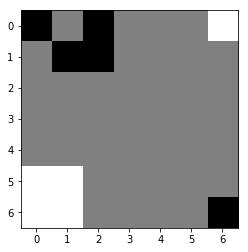

((1, 1), (2, 0)): n_v:   125 q_all:-0.003994 q:+0.013208 q_m:+0.000735 p:0.039160
((1, 1), (2, 1)): n_v:    97 q_all:-0.003975 q:+0.014718 q_m:+0.000735 p:0.030558
((6, 6), (6, 5)): n_v:    91 q_all:-0.005993 q:+0.019368 q_m:+0.000735 p:0.029498
((0, 0), (0, 1)): n_v:    89 q_all:-0.002934 q:+0.011799 q_m:+0.000735 p:0.027530
((1, 2), (2, 3)): n_v:    84 q_all:-0.004319 q:+0.008437 q_m:+0.000735 p:0.026510
((0, 2), (1, 3)): n_v:    83 q_all:-0.003733 q:+0.003463 q_m:+0.000735 p:0.025927
((6, 6), (5, 6)): n_v:    83 q_all:-0.004574 q:+0.004511 q_m:+0.000735 p:0.026392
((0, 0), (1, 0)): n_v:    79 q_all:-0.004292 q:-0.004987 q_m:+0.000735 p:0.024983
((6, 6), (5, 5)): n_v:    76 q_all:-0.002794 q:+0.003864 q_m:+0.000735 p:0.023708
((0, 2), (0, 3)): n_v:    75 q_all:-0.003303 q:+0.005508 q_m:+0.000735 p:0.023342
((1, 2), (0, 4)): n_v:    75 q_all:-0.005302 q:-0.001148 q_m:-0.000000 p:0.024117
((1, 2), (1, 4)): n_v:    73 q_all:-0.005252 q:+0.009243 q_m:-0.000000 p:0.023468
((1, 1), (2, 2))

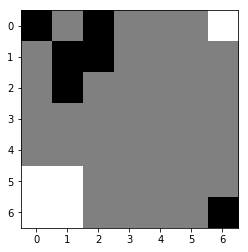

((0, 6), (0, 5)): n_v:    22 q_all:+0.005521 q:+0.037414 q_m:-0.000000 p:0.122217
((0, 6), (1, 6)): n_v:     9 q_all:+0.004298 q:+0.035294 q_m:-0.000000 p:0.053359
((0, 6), (1, 5)): n_v:     9 q_all:+0.002741 q:+0.025454 q_m:-0.000000 p:0.051413
((5, 1), (4, 2)): n_v:     7 q_all:+0.001187 q:+0.038844 q_m:-0.000000 p:0.040598
((5, 1), (5, 2)): n_v:     6 q_all:+0.001352 q:+0.038028 q_m:-0.000000 p:0.035550
((5, 1), (6, 2)): n_v:     5 q_all:-0.001221 q:+0.000266 q_m:-0.000000 p:0.031611
((5, 0), (4, 0)): n_v:     5 q_all:-0.006082 q:+0.012788 q_m:-0.000000 p:0.028301
((6, 1), (5, 3)): n_v:     4 q_all:+0.000837 q:+0.010981 q_m:-0.000735 p:0.026255
((5, 0), (3, 1)): n_v:     4 q_all:-0.002358 q:+0.009078 q_m:+0.000735 p:0.025080
((5, 1), (6, 3)): n_v:     4 q_all:-0.004008 q:-0.012601 q_m:-0.000735 p:0.027412
((5, 1), (3, 1)): n_v:     4 q_all:-0.006433 q:+0.006662 q_m:+0.000735 p:0.023951
((5, 0), (4, 1)): n_v:     4 q_all:+0.002914 q:+0.019167 q_m:-0.000000 p:0.025221
((5, 0), (3, 0))

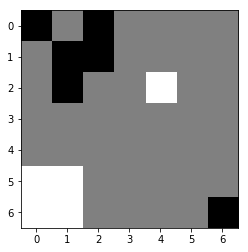

((0, 2), (1, 3)): n_v:   147 q_all:+0.005657 q:+0.032736 q_m:+0.011755 p:0.044870
((1, 2), (2, 3)): n_v:   106 q_all:+0.007056 q:+0.040638 q_m:+0.011755 p:0.031902
((2, 1), (3, 2)): n_v:   103 q_all:-0.005060 q:+0.004073 q_m:+0.002939 p:0.036084
((0, 2), (0, 3)): n_v:    96 q_all:-0.002772 q:+0.010956 q_m:+0.002939 p:0.032973
((1, 2), (1, 4)): n_v:    76 q_all:+0.002240 q:+0.027714 q_m:+0.006612 p:0.024440
((0, 2), (1, 4)): n_v:    67 q_all:+0.003665 q:+0.025718 q_m:+0.006612 p:0.020964
((1, 1), (1, 3)): n_v:    64 q_all:+0.003257 q:+0.033605 q_m:+0.006612 p:0.020351
((6, 6), (6, 5)): n_v:    57 q_all:-0.005222 q:+0.031274 q_m:+0.002939 p:0.020248
((1, 2), (0, 4)): n_v:    56 q_all:-0.007047 q:-0.004123 q_m:+0.000735 p:0.020390
((2, 1), (4, 1)): n_v:    56 q_all:+0.005378 q:+0.041921 q_m:+0.018367 p:0.017072
((6, 6), (5, 6)): n_v:    54 q_all:-0.004422 q:+0.023306 q_m:+0.002939 p:0.018727
((0, 0), (0, 1)): n_v:    54 q_all:-0.002434 q:+0.011653 q_m:+0.002939 p:0.018393
((2, 1), (1, 3))

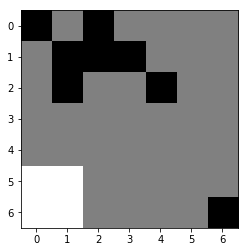

((5, 1), (5, 2)): n_v:   344 q_all:-0.015228 q:+0.029215 q_m:-0.006612 p:0.112209
((5, 1), (4, 2)): n_v:   307 q_all:-0.017979 q:+0.017833 q_m:-0.006612 p:0.103441
((5, 1), (6, 2)): n_v:   205 q_all:-0.013597 q:-0.009664 q_m:-0.006612 p:0.065657
((5, 1), (6, 3)): n_v:   124 q_all:-0.018820 q:-0.016133 q_m:-0.011755 p:0.042555
((6, 1), (6, 3)): n_v:   104 q_all:-0.021824 q:-0.028952 q_m:-0.011755 p:0.036803
((5, 1), (4, 3)): n_v:   104 q_all:-0.025908 q:-0.004793 q_m:-0.011755 p:0.038469
((6, 1), (4, 3)): n_v:    97 q_all:-0.027982 q:-0.009095 q_m:-0.011755 p:0.036910
((5, 0), (4, 2)): n_v:    89 q_all:-0.023589 q:+0.007218 q_m:-0.011755 p:0.032243
((5, 0), (3, 1)): n_v:    89 q_all:-0.015999 q:+0.005127 q_m:-0.002939 p:0.029331
((5, 0), (5, 2)): n_v:    78 q_all:-0.021189 q:+0.010884 q_m:-0.011755 p:0.027519
((6, 1), (4, 2)): n_v:    73 q_all:-0.027355 q:-0.025337 q_m:-0.011755 p:0.027618
((5, 0), (4, 1)): n_v:    68 q_all:-0.018787 q:-0.005054 q_m:-0.006612 p:0.023217
((6, 1), (5, 3))

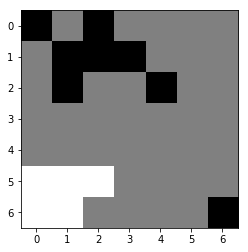

((2, 1), (4, 1)): n_v:    74 q_all:+0.020865 q:+0.097611 q_m:+0.059510 p:0.017512
((1, 3), (0, 4)): n_v:    72 q_all:+0.004994 q:+0.036357 q_m:+0.011755 p:0.021763
((2, 4), (1, 5)): n_v:    66 q_all:+0.004184 q:+0.037065 q_m:+0.011755 p:0.020150
((1, 3), (0, 5)): n_v:    66 q_all:+0.000438 q:+0.027263 q_m:+0.006612 p:0.021181
((1, 2), (0, 4)): n_v:    64 q_all:+0.002828 q:+0.026150 q_m:+0.006612 p:0.019812
((1, 3), (0, 1)): n_v:    61 q_all:+0.000848 q:+0.028270 q_m:+0.006612 p:0.019439
((0, 2), (0, 3)): n_v:    59 q_all:+0.003093 q:+0.027196 q_m:+0.011755 p:0.018399
((6, 6), (6, 5)): n_v:    56 q_all:+0.005176 q:+0.053309 q_m:+0.011755 p:0.016803
((1, 2), (2, 3)): n_v:    55 q_all:+0.003199 q:+0.033105 q_m:+0.011755 p:0.017065
((0, 0), (0, 1)): n_v:    51 q_all:+0.004277 q:+0.033715 q_m:+0.011755 p:0.015407
((1, 3), (1, 4)): n_v:    50 q_all:+0.005995 q:+0.053735 q_m:+0.011755 p:0.014946
((2, 4), (0, 6)): n_v:    49 q_all:+0.000805 q:+0.033811 q_m:+0.006612 p:0.015598
((2, 4), (3, 4))

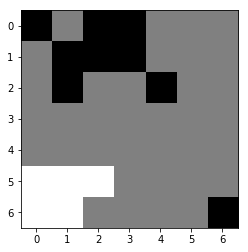

((5, 1), (6, 2)): n_v:   255 q_all:-0.015411 q:+0.013780 q_m:-0.006612 p:0.077169
((5, 2), (4, 3)): n_v:   180 q_all:-0.021638 q:+0.055399 q_m:-0.006612 p:0.059259
((5, 1), (4, 2)): n_v:   160 q_all:-0.022588 q:+0.036499 q_m:-0.006612 p:0.052885
((5, 2), (6, 3)): n_v:   160 q_all:-0.018503 q:+0.006572 q_m:-0.006612 p:0.050367
((5, 2), (5, 4)): n_v:   153 q_all:-0.024376 q:+0.036357 q_m:-0.011755 p:0.052150
((5, 2), (5, 3)): n_v:   121 q_all:-0.016405 q:+0.022856 q_m:-0.006612 p:0.037012
((5, 1), (6, 3)): n_v:    75 q_all:-0.020363 q:-0.000877 q_m:-0.011755 p:0.024339
((6, 1), (6, 3)): n_v:    71 q_all:-0.025653 q:+0.000299 q_m:-0.011755 p:0.024711
((5, 0), (4, 1)): n_v:    71 q_all:-0.018317 q:+0.025253 q_m:-0.006612 p:0.022300
((5, 2), (6, 4)): n_v:    60 q_all:-0.022240 q:+0.004517 q_m:-0.011755 p:0.019946
((5, 0), (6, 2)): n_v:    58 q_all:-0.020896 q:-0.003579 q_m:-0.011755 p:0.018730
((5, 2), (4, 4)): n_v:    58 q_all:-0.022410 q:+0.018967 q_m:-0.011755 p:0.019385
((5, 0), (3, 1))

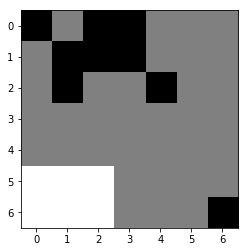

((0, 3), (0, 5)): n_v:    97 q_all:+0.000113 q:+0.023162 q_m:+0.006612 p:0.031511
((0, 3), (0, 1)): n_v:    85 q_all:+0.000299 q:+0.019860 q_m:+0.006612 p:0.027347
((2, 1), (4, 1)): n_v:    74 q_all:+0.024029 q:+0.126457 q_m:+0.059510 p:0.016887
((0, 3), (0, 4)): n_v:    63 q_all:+0.003872 q:+0.029914 q_m:+0.011755 p:0.019392
((1, 3), (0, 5)): n_v:    61 q_all:+0.002422 q:+0.028797 q_m:+0.006612 p:0.019346
((1, 3), (0, 1)): n_v:    59 q_all:-0.000611 q:+0.028236 q_m:+0.006612 p:0.019195
((2, 4), (0, 5)): n_v:    54 q_all:+0.000202 q:+0.020268 q_m:+0.006612 p:0.017356
((6, 6), (6, 5)): n_v:    52 q_all:+0.004190 q:+0.057784 q_m:+0.011755 p:0.016015
((2, 4), (1, 5)): n_v:    51 q_all:+0.004035 q:+0.036307 q_m:+0.011755 p:0.015740
((0, 3), (1, 4)): n_v:    48 q_all:+0.004773 q:+0.042342 q_m:+0.011755 p:0.014748
((2, 4), (1, 6)): n_v:    47 q_all:+0.000965 q:+0.037570 q_m:+0.006612 p:0.015179
((1, 2), (2, 3)): n_v:    47 q_all:+0.003830 q:+0.041242 q_m:+0.011755 p:0.014611
((0, 0), (0, 1))

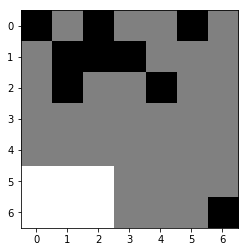

((5, 2), (6, 3)): n_v:   327 q_all:-0.012005 q:+0.016186 q_m:-0.002939 p:0.102407
((5, 2), (4, 3)): n_v:   142 q_all:-0.015006 q:+0.052107 q_m:-0.002939 p:0.046494
((5, 2), (5, 3)): n_v:   136 q_all:-0.008895 q:+0.027436 q_m:-0.002939 p:0.040790
((5, 1), (6, 3)): n_v:   133 q_all:-0.011382 q:-0.010274 q_m:-0.006612 p:0.041462
((6, 1), (6, 3)): n_v:   113 q_all:-0.020243 q:+0.016763 q_m:-0.006612 p:0.039562
((6, 2), (5, 4)): n_v:    99 q_all:-0.018775 q:+0.034133 q_m:-0.006612 p:0.033861
((5, 2), (5, 4)): n_v:    98 q_all:-0.017575 q:-0.000980 q_m:-0.006612 p:0.033230
((5, 1), (4, 2)): n_v:    92 q_all:-0.016897 q:+0.019533 q_m:-0.002939 p:0.030510
((5, 2), (6, 4)): n_v:    81 q_all:-0.014668 q:-0.010456 q_m:-0.006612 p:0.026239
((6, 2), (6, 4)): n_v:    69 q_all:-0.016690 q:+0.018376 q_m:-0.006612 p:0.022935
((5, 0), (3, 1)): n_v:    54 q_all:-0.012026 q:+0.023156 q_m:-0.000735 p:0.017185
((6, 2), (4, 4)): n_v:    48 q_all:-0.019407 q:+0.019956 q_m:-0.006612 p:0.016476
((5, 2), (4, 4))

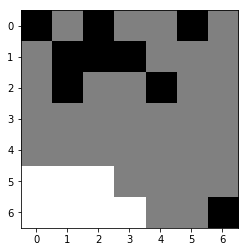

((2, 1), (4, 1)): n_v:    89 q_all:+0.023654 q:+0.125026 q_m:+0.047020 p:0.017161
((1, 2), (2, 3)): n_v:    73 q_all:+0.001327 q:+0.033127 q_m:+0.006612 p:0.020524
((0, 5), (0, 6)): n_v:    70 q_all:-0.000038 q:+0.013600 q_m:+0.006612 p:0.020123
((6, 6), (6, 5)): n_v:    69 q_all:+0.000079 q:+0.045171 q_m:+0.006612 p:0.019798
((0, 2), (0, 3)): n_v:    69 q_all:+0.001534 q:+0.030923 q_m:+0.006612 p:0.019482
((0, 0), (0, 1)): n_v:    66 q_all:+0.001313 q:+0.028673 q_m:+0.006612 p:0.018517
((2, 4), (2, 5)): n_v:    57 q_all:+0.003658 q:+0.064897 q_m:+0.006612 p:0.015670
((1, 3), (0, 1)): n_v:    57 q_all:+0.001035 q:+0.029727 q_m:+0.002939 p:0.016072
((0, 5), (0, 4)): n_v:    56 q_all:-0.002113 q:+0.012718 q_m:+0.006612 p:0.016580
((0, 5), (1, 4)): n_v:    51 q_all:-0.000782 q:+0.018494 q_m:+0.006612 p:0.014958
((2, 4), (3, 4)): n_v:    47 q_all:+0.001444 q:+0.035970 q_m:+0.006612 p:0.013367
((1, 2), (0, 4)): n_v:    47 q_all:-0.002986 q:+0.028115 q_m:+0.002939 p:0.014196
((2, 1), (0, 1))

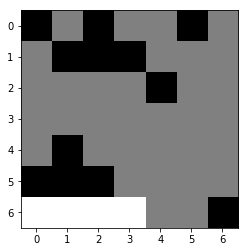

((6, 2), (5, 3)): n_v:   372 q_all:-0.034024 q:-0.024491 q_m:-0.018367 p:0.125857
((6, 1), (4, 2)): n_v:   199 q_all:-0.032798 q:+0.022734 q_m:-0.002939 p:0.066621
((6, 2), (4, 2)): n_v:   195 q_all:-0.018033 q:+0.001588 q_m:-0.002939 p:0.052866
((6, 3), (6, 5)): n_v:   171 q_all:-0.044414 q:-0.007248 q_m:-0.026449 p:0.065575
((6, 3), (4, 2)): n_v:   164 q_all:-0.012380 q:+0.019405 q_m:-0.002939 p:0.040874
((6, 3), (5, 4)): n_v:   151 q_all:-0.075583 q:-0.013619 q_m:-0.036000 p:0.077359
((6, 3), (5, 5)): n_v:   149 q_all:-0.042049 q:-0.022670 q_m:-0.026449 p:0.055469
((6, 2), (4, 0)): n_v:   139 q_all:-0.016568 q:-0.010862 q_m:-0.002939 p:0.037059
((6, 0), (4, 2)): n_v:   119 q_all:-0.013778 q:+0.009264 q_m:-0.002939 p:0.030298
((6, 0), (4, 0)): n_v:   104 q_all:-0.009274 q:+0.017755 q_m:-0.002939 p:0.024474
((6, 1), (5, 3)): n_v:   102 q_all:-0.063238 q:-0.007139 q_m:-0.026449 p:0.047166
((6, 1), (4, 0)): n_v:    86 q_all:-0.018410 q:+0.004632 q_m:-0.002939 p:0.023679
((6, 2), (4, 4))

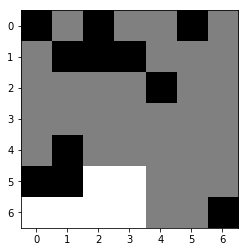

((0, 2), (0, 3)): n_v:   128 q_all:+0.014519 q:+0.045879 q_m:+0.026449 p:0.030699
((0, 5), (1, 4)): n_v:   122 q_all:+0.011170 q:+0.052616 q_m:+0.026449 p:0.030657
((4, 1), (4, 2)): n_v:   121 q_all:+0.029989 q:+0.057265 q_m:+0.073469 p:0.021337
((0, 5), (0, 4)): n_v:   102 q_all:+0.007999 q:+0.033023 q_m:+0.026449 p:0.027154
((1, 2), (2, 3)): n_v:    93 q_all:+0.011412 q:+0.094332 q_m:+0.026449 p:0.023371
((6, 6), (5, 4)): n_v:    75 q_all:+0.013592 q:+0.051272 q_m:+0.059510 p:0.018133
((2, 4), (0, 3)): n_v:    61 q_all:+0.005187 q:+0.042048 q_m:+0.018367 p:0.016818
((1, 1), (2, 2)): n_v:    61 q_all:+0.009661 q:+0.029422 q_m:+0.026449 p:0.015693
((6, 6), (6, 5)): n_v:    59 q_all:+0.007942 q:+0.037129 q_m:+0.026449 p:0.015580
((6, 6), (6, 4)): n_v:    56 q_all:+0.015833 q:+0.037626 q_m:+0.059510 p:0.013249
((0, 0), (0, 1)): n_v:    54 q_all:+0.011635 q:+0.041007 q_m:+0.026449 p:0.013687
((4, 1), (4, 3)): n_v:    52 q_all:+0.014740 q:+0.055177 q_m:+0.059510 p:0.012567
((2, 4), (0, 4))

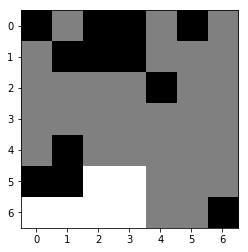

((5, 2), (4, 2)): n_v:   314 q_all:-0.008862 q:+0.026322 q_m:-0.000735 p:0.064153
((5, 3), (5, 4)): n_v:   226 q_all:-0.039909 q:+0.002611 q_m:-0.018367 p:0.075459
((6, 3), (6, 5)): n_v:   175 q_all:-0.038192 q:-0.008894 q_m:-0.011755 p:0.057067
((5, 3), (4, 4)): n_v:   140 q_all:-0.040424 q:-0.005076 q_m:-0.018367 p:0.047012
((5, 2), (4, 3)): n_v:   127 q_all:-0.043212 q:+0.011901 q_m:-0.018367 p:0.043911
((6, 2), (4, 0)): n_v:   115 q_all:-0.002656 q:+0.006591 q_m:-0.000000 p:0.020649
((6, 3), (5, 5)): n_v:    97 q_all:-0.040048 q:-0.015983 q_m:-0.011755 p:0.032650
((6, 3), (4, 2)): n_v:    87 q_all:-0.012951 q:+0.012851 q_m:-0.002939 p:0.019364
((6, 1), (4, 2)): n_v:    78 q_all:-0.028626 q:+0.010378 q_m:-0.002939 p:0.022346
((5, 3), (6, 4)): n_v:    71 q_all:-0.037012 q:-0.007264 q_m:-0.018367 p:0.022785
((5, 2), (4, 0)): n_v:    70 q_all:-0.002260 q:+0.003097 q_m:-0.000000 p:0.012474
((5, 3), (5, 5)): n_v:    68 q_all:-0.032822 q:-0.009265 q_m:-0.011755 p:0.020692
((5, 3), (6, 5))

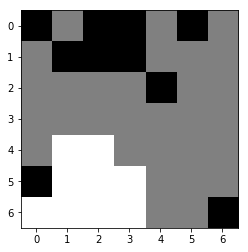

((1, 2), (2, 3)): n_v:   142 q_all:-0.007282 q:+0.023556 q_m:+0.002939 p:0.038981
((0, 3), (1, 4)): n_v:   135 q_all:-0.004957 q:+0.036369 q_m:+0.002939 p:0.035926
((2, 4), (3, 4)): n_v:    94 q_all:-0.005191 q:+0.005051 q_m:+0.002939 p:0.025232
((2, 4), (4, 3)): n_v:    85 q_all:+0.009588 q:+0.062237 q_m:+0.036000 p:0.017717
((0, 3), (0, 4)): n_v:    65 q_all:-0.008094 q:+0.017681 q_m:+0.002939 p:0.018211
((6, 6), (6, 5)): n_v:    63 q_all:-0.004142 q:+0.013630 q_m:+0.002939 p:0.016742
((0, 5), (2, 3)): n_v:    59 q_all:-0.009405 q:+0.012594 q_m:+0.000735 p:0.016919
((2, 4), (3, 3)): n_v:    57 q_all:-0.002518 q:+0.030733 q_m:+0.011755 p:0.014668
((0, 0), (0, 1)): n_v:    54 q_all:-0.003107 q:+0.010744 q_m:+0.002939 p:0.014152
((2, 4), (3, 2)): n_v:    51 q_all:+0.000682 q:+0.010941 q_m:+0.018367 p:0.012587
((1, 2), (1, 4)): n_v:    49 q_all:-0.004348 q:+0.017389 q_m:+0.000735 p:0.012917
((5, 0), (3, 2)): n_v:    48 q_all:+0.002281 q:+0.019581 q_m:+0.018367 p:0.011469
((0, 2), (1, 4))

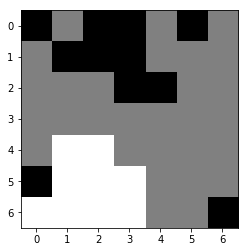

((5, 3), (5, 4)): n_v:   355 q_all:-0.015475 q:+0.046858 q_m:-0.000735 p:0.109218
((4, 2), (2, 2)): n_v:   191 q_all:+0.007224 q:+0.024152 q_m:+0.026449 p:0.040944
((4, 1), (3, 2)): n_v:   165 q_all:-0.020278 q:+0.020771 q_m:+0.000735 p:0.053979
((4, 2), (3, 3)): n_v:   159 q_all:-0.012270 q:+0.050915 q_m:+0.006612 p:0.046926
((5, 3), (6, 4)): n_v:   102 q_all:-0.010813 q:+0.012137 q_m:-0.000735 p:0.029515
((4, 1), (2, 2)): n_v:    92 q_all:+0.004220 q:+0.034599 q_m:+0.026449 p:0.020952
((5, 3), (4, 4)): n_v:    80 q_all:-0.025538 q:+0.049023 q_m:-0.000735 p:0.028035
((4, 2), (5, 4)): n_v:    70 q_all:-0.026648 q:+0.035710 q_m:-0.002939 p:0.025024
((6, 2), (5, 4)): n_v:    69 q_all:-0.041806 q:+0.028314 q_m:-0.002939 p:0.028966
((4, 2), (3, 4)): n_v:    60 q_all:-0.009965 q:+0.016556 q_m:+0.002939 p:0.017271
((6, 3), (6, 5)): n_v:    55 q_all:-0.012760 q:+0.022234 q_m:-0.000000 p:0.016192
((4, 2), (6, 4)): n_v:    48 q_all:-0.022554 q:+0.012965 q_m:-0.002939 p:0.015951
((4, 1), (3, 3))

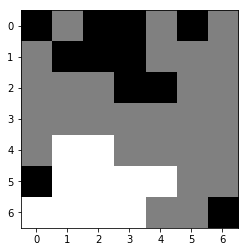

((2, 3), (4, 3)): n_v:   205 q_all:+0.018886 q:+0.071532 q_m:+0.059510 p:0.036891
((0, 3), (0, 4)): n_v:   137 q_all:-0.011082 q:+0.026956 q_m:+0.002939 p:0.040984
((2, 4), (4, 3)): n_v:   105 q_all:+0.015486 q:+0.068875 q_m:+0.059510 p:0.020328
((6, 6), (5, 5)): n_v:   102 q_all:-0.007943 q:+0.003652 q_m:+0.011755 p:0.029405
((2, 3), (1, 5)): n_v:   100 q_all:-0.010292 q:+0.012719 q_m:+0.000735 p:0.029642
((6, 6), (6, 4)): n_v:    96 q_all:+0.005425 q:+0.045483 q_m:+0.036000 p:0.022550
((2, 3), (0, 4)): n_v:    84 q_all:-0.011325 q:+0.027138 q_m:+0.000735 p:0.025428
((2, 4), (0, 4)): n_v:    83 q_all:-0.011555 q:+0.020518 q_m:+0.000735 p:0.025049
((0, 2), (0, 4)): n_v:    81 q_all:-0.013927 q:+0.018748 q_m:+0.000735 p:0.025242
((0, 3), (1, 4)): n_v:    76 q_all:-0.006796 q:+0.037726 q_m:+0.002939 p:0.021584
((6, 6), (6, 5)): n_v:    66 q_all:-0.005614 q:+0.023928 q_m:+0.011755 p:0.018455
((0, 5), (1, 5)): n_v:    63 q_all:-0.007221 q:+0.019522 q_m:+0.002939 p:0.018079
((2, 3), (4, 4))

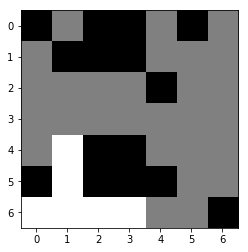

((6, 3), (6, 4)): n_v:   571 q_all:-0.029176 q:-0.038481 q_m:-0.011755 p:0.193444
((6, 3), (4, 4)): n_v:   387 q_all:-0.037400 q:+0.008078 q_m:-0.006612 p:0.143906
((6, 2), (4, 4)): n_v:   327 q_all:-0.060756 q:-0.031397 q_m:-0.006612 p:0.152964
((4, 1), (3, 2)): n_v:   219 q_all:-0.064613 q:-0.001624 q_m:-0.011755 p:0.106109
((4, 1), (2, 3)): n_v:   188 q_all:-0.045131 q:-0.007019 q_m:-0.006612 p:0.076200
((4, 1), (3, 3)): n_v:   152 q_all:-0.050106 q:+0.002141 q_m:-0.006612 p:0.064698
((6, 3), (5, 5)): n_v:   115 q_all:-0.049541 q:-0.015626 q_m:-0.018367 p:0.048694
((5, 1), (3, 3)): n_v:    70 q_all:-0.061847 q:+0.012348 q_m:-0.006612 p:0.033289
((6, 2), (6, 4)): n_v:    68 q_all:-0.096976 q:-0.032848 q_m:-0.018367 p:0.042406
((4, 1), (2, 2)): n_v:    67 q_all:-0.039062 q:-0.009854 q_m:-0.006612 p:0.025473
((6, 3), (6, 5)): n_v:    56 q_all:-0.054747 q:-0.031593 q_m:-0.018367 p:0.025229
((6, 3), (4, 5)): n_v:    41 q_all:-0.068528 q:-0.027174 q_m:-0.036000 p:0.020753
((4, 1), (3, 1))

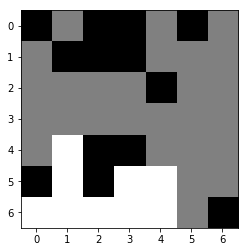

((4, 3), (5, 5)): n_v:   269 q_all:+0.011106 q:+0.009689 q_m:+0.047020 p:0.066052
((6, 6), (6, 5)): n_v:   239 q_all:+0.020599 q:+0.044409 q_m:+0.059510 p:0.050206
((4, 3), (6, 5)): n_v:   176 q_all:+0.012605 q:+0.031760 q_m:+0.047020 p:0.042373
((6, 6), (5, 5)): n_v:   124 q_all:+0.015386 q:+0.019588 q_m:+0.059510 p:0.028489
((4, 3), (4, 4)): n_v:   104 q_all:+0.019811 q:+0.038727 q_m:+0.059510 p:0.022096
((0, 0), (0, 1)): n_v:    89 q_all:+0.005866 q:+0.016780 q_m:+0.018367 p:0.023757
((0, 3), (1, 4)): n_v:    75 q_all:+0.003819 q:+0.031515 q_m:+0.018367 p:0.020515
((5, 0), (4, 0)): n_v:    59 q_all:+0.027333 q:+0.027765 q_m:+0.059510 p:0.010939
((0, 3), (0, 4)): n_v:    54 q_all:+0.002485 q:+0.027544 q_m:+0.018367 p:0.015065
((0, 5), (1, 5)): n_v:    54 q_all:+0.002768 q:-0.002762 q_m:+0.018367 p:0.015103
((4, 2), (4, 4)): n_v:    47 q_all:+0.014092 q:+0.038341 q_m:+0.047020 p:0.011172
((0, 3), (0, 1)): n_v:    45 q_all:+0.002033 q:+0.018315 q_m:+0.011755 p:0.012775
((1, 1), (2, 0))

one move takes time(s):  0.793276309967041
no. of data collected:  8


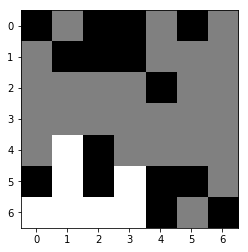

((5, 3), (4, 3)): n_v:  1746 q_all:-0.016115 q:-0.010427 q_m:-0.000735 p:0.662525
((6, 1), (4, 3)): n_v:   135 q_all:-0.030871 q:-0.010293 q_m:-0.002939 p:0.059663
((4, 1), (4, 3)): n_v:   125 q_all:-0.023657 q:+0.001281 q_m:-0.002939 p:0.051336
((6, 2), (4, 3)): n_v:    81 q_all:-0.047896 q:-0.013682 q_m:-0.002939 p:0.041436
((5, 1), (4, 3)): n_v:    65 q_all:-0.072457 q:+0.006304 q_m:-0.002939 p:0.039681
((6, 3), (6, 5)): n_v:    41 q_all:-0.041442 q:-0.010014 q_m:-0.000000 p:0.019688
((5, 3), (4, 4)): n_v:    33 q_all:-0.035928 q:-0.012181 q_m:-0.006612 p:0.015240
((6, 3), (4, 3)): n_v:    32 q_all:-0.060124 q:-0.005398 q_m:-0.002939 p:0.017826
((4, 1), (2, 3)): n_v:    32 q_all:-0.043341 q:-0.014143 q_m:-0.002939 p:0.015929
((6, 2), (4, 4)): n_v:    29 q_all:-0.082633 q:-0.038977 q_m:-0.011755 p:0.019409
((6, 3), (4, 4)): n_v:    17 q_all:-0.064683 q:-0.021543 q_m:-0.011755 p:0.010206
((6, 3), (4, 5)): n_v:    14 q_all:-0.065393 q:-0.032659 q_m:-0.011755 p:0.008663
((5, 3), (6, 5))

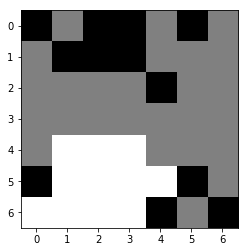

((2, 4), (3, 3)): n_v:   412 q_all:+0.010928 q:+0.023783 q_m:+0.026449 p:0.078333
((2, 4), (4, 4)): n_v:   229 q_all:+0.015700 q:+0.024741 q_m:+0.036000 p:0.039958
((2, 4), (3, 2)): n_v:   227 q_all:+0.014089 q:+0.020456 q_m:+0.036000 p:0.040804
((5, 5), (4, 4)): n_v:   189 q_all:+0.019112 q:+0.011865 q_m:+0.047020 p:0.030980
((2, 4), (3, 4)): n_v:   172 q_all:-0.003069 q:-0.016015 q_m:+0.011755 p:0.040413
((5, 5), (3, 3)): n_v:   143 q_all:+0.003232 q:+0.006977 q_m:+0.018367 p:0.030810
((1, 1), (3, 3)): n_v:   143 q_all:+0.007512 q:+0.026715 q_m:+0.018367 p:0.028779
((1, 2), (3, 3)): n_v:   138 q_all:+0.005949 q:+0.013187 q_m:+0.018367 p:0.028390
((6, 4), (4, 4)): n_v:   115 q_all:+0.014625 q:+0.018187 q_m:+0.036000 p:0.020414
((5, 0), (3, 2)): n_v:   108 q_all:+0.015760 q:+0.033118 q_m:+0.036000 p:0.018875
((1, 3), (3, 3)): n_v:    99 q_all:+0.008113 q:+0.023011 q_m:+0.018367 p:0.019767
((1, 3), (3, 2)): n_v:    97 q_all:+0.016669 q:+0.035253 q_m:+0.036000 p:0.016713
((1, 1), (3, 2))

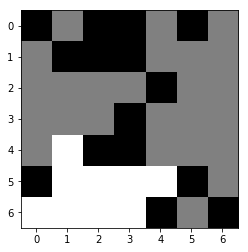

((4, 1), (3, 2)): n_v:  1129 q_all:-0.011280 q:-0.021571 q_m:+0.000735 p:0.317947
((5, 3), (4, 4)): n_v:   532 q_all:-0.012996 q:+0.035750 q_m:+0.000735 p:0.153263
((6, 2), (4, 4)): n_v:   126 q_all:-0.032185 q:-0.022206 q_m:-0.000000 p:0.045676
((6, 3), (4, 4)): n_v:   114 q_all:-0.036113 q:+0.022250 q_m:-0.000000 p:0.043356
((5, 4), (3, 2)): n_v:   102 q_all:-0.014655 q:-0.013170 q_m:-0.000000 p:0.030160
((5, 1), (3, 2)): n_v:    97 q_all:-0.044991 q:+0.010096 q_m:-0.000000 p:0.040491
((5, 2), (3, 4)): n_v:    54 q_all:-0.071011 q:-0.011395 q_m:-0.000000 p:0.028063
((4, 1), (2, 3)): n_v:    43 q_all:-0.020008 q:+0.031504 q_m:+0.002939 p:0.013877
((4, 1), (2, 2)): n_v:    42 q_all:-0.018367 q:+0.007110 q_m:+0.002939 p:0.013164
((5, 2), (4, 4)): n_v:    38 q_all:-0.080957 q:-0.024648 q_m:-0.000000 p:0.021432
((5, 4), (3, 4)): n_v:    34 q_all:-0.030880 q:-0.008386 q_m:-0.000000 p:0.012331
((5, 4), (6, 5)): n_v:    30 q_all:-0.006167 q:-0.001861 q_m:+0.000735 p:0.007933
((5, 2), (3, 2))

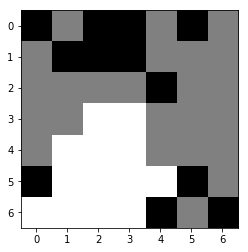

((1, 2), (2, 3)): n_v:   425 q_all:-0.007652 q:+0.003481 q_m:+0.011755 p:0.098447
((5, 5), (4, 4)): n_v:   329 q_all:+0.012534 q:+0.010080 q_m:+0.047020 p:0.052388
((0, 2), (2, 3)): n_v:   204 q_all:-0.013064 q:-0.007313 q_m:+0.006612 p:0.051005
((2, 4), (3, 4)): n_v:   174 q_all:-0.014650 q:-0.017696 q_m:+0.011755 p:0.044621
((2, 4), (4, 4)): n_v:   160 q_all:+0.011072 q:+0.018058 q_m:+0.036000 p:0.026318
((1, 1), (2, 3)): n_v:   143 q_all:-0.007269 q:-0.005425 q_m:+0.006612 p:0.033008
((0, 3), (2, 3)): n_v:   136 q_all:-0.011994 q:+0.001077 q_m:+0.006612 p:0.033736
((6, 4), (4, 4)): n_v:   131 q_all:+0.006758 q:+0.006685 q_m:+0.036000 p:0.023713
((0, 5), (2, 3)): n_v:   127 q_all:-0.011720 q:-0.001092 q_m:+0.006612 p:0.031484
((1, 1), (2, 2)): n_v:   125 q_all:-0.010804 q:+0.014839 q_m:+0.011755 p:0.030323
((6, 6), (4, 4)): n_v:   121 q_all:+0.007465 q:+0.003431 q_m:+0.036000 p:0.021642
((5, 0), (3, 1)): n_v:   101 q_all:+0.004884 q:+0.020526 q_m:+0.018367 p:0.018901
((0, 3), (2, 2))

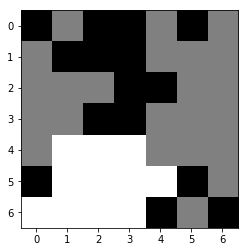

((4, 3), (4, 4)): n_v:   558 q_all:-0.013525 q:+0.014282 q_m:+0.000735 p:0.146206
((4, 3), (2, 2)): n_v:   423 q_all:-0.005949 q:+0.010728 q_m:+0.047020 p:0.098110
((4, 1), (2, 2)): n_v:   313 q_all:+0.009721 q:+0.068436 q_m:+0.047020 p:0.053536
((4, 2), (2, 2)): n_v:   301 q_all:-0.008257 q:+0.001234 q_m:+0.047020 p:0.072741
((4, 3), (3, 4)): n_v:   176 q_all:-0.028641 q:-0.013817 q_m:+0.006612 p:0.056571
((6, 2), (4, 4)): n_v:   147 q_all:-0.036009 q:-0.018981 q_m:-0.000000 p:0.051441
((6, 3), (4, 4)): n_v:   111 q_all:-0.044098 q:-0.021392 q_m:-0.000000 p:0.042566
((5, 4), (6, 5)): n_v:   110 q_all:-0.001651 q:+0.053207 q_m:+0.006612 p:0.023773
((4, 3), (6, 5)): n_v:    67 q_all:-0.031888 q:+0.016220 q_m:+0.002939 p:0.022390
((5, 2), (4, 4)): n_v:    39 q_all:-0.073288 q:-0.013415 q_m:-0.000000 p:0.018955
((4, 2), (3, 4)): n_v:    37 q_all:-0.049503 q:-0.036612 q_m:+0.002939 p:0.015092
((4, 2), (4, 4)): n_v:    33 q_all:-0.069947 q:+0.032514 q_m:-0.000000 p:0.016231
((5, 2), (3, 4))

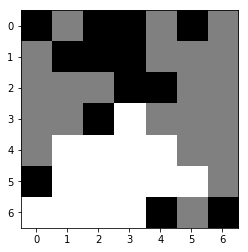

((2, 3), (3, 4)): n_v:  1058 q_all:-0.012762 q:+0.018398 q_m:+0.026449 p:0.221484
((3, 2), (3, 4)): n_v:   388 q_all:-0.004946 q:+0.008895 q_m:+0.018367 p:0.069558
((1, 2), (3, 4)): n_v:   215 q_all:-0.006891 q:+0.004549 q_m:+0.018367 p:0.040309
((1, 3), (3, 4)): n_v:   108 q_all:-0.006585 q:+0.005467 q_m:+0.018367 p:0.020142
((1, 1), (2, 2)): n_v:    70 q_all:-0.017095 q:-0.009546 q_m:+0.002939 p:0.015978
((3, 2), (3, 1)): n_v:    56 q_all:-0.029155 q:+0.015935 q_m:+0.011755 p:0.015449
((2, 3), (4, 5)): n_v:    53 q_all:-0.007839 q:+0.038325 q_m:+0.018367 p:0.010150
((6, 4), (4, 5)): n_v:    47 q_all:-0.007195 q:+0.034950 q_m:+0.018367 p:0.008951
((2, 4), (3, 5)): n_v:    44 q_all:-0.028060 q:-0.003552 q_m:+0.002939 p:0.011840
((2, 4), (4, 5)): n_v:    43 q_all:-0.007902 q:+0.035030 q_m:+0.018367 p:0.008155
((0, 3), (2, 2)): n_v:    39 q_all:-0.022190 q:-0.012963 q_m:+0.000735 p:0.009593
((5, 0), (3, 1)): n_v:    33 q_all:-0.040459 q:+0.014382 q_m:+0.006612 p:0.010564
((6, 4), (6, 5))

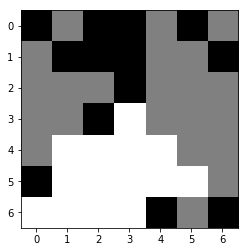

((3, 3), (2, 2)): n_v:  1132 q_all:+0.036631 q:+0.045122 q_m:+0.105796 p:0.378866
((3, 3), (2, 4)): n_v:   455 q_all:-0.004736 q:+0.033934 q_m:+0.026449 p:0.232741
((5, 4), (6, 5)): n_v:    82 q_all:+0.007691 q:+0.074688 q_m:+0.026449 p:0.037627
((4, 4), (2, 2)): n_v:    80 q_all:+0.020090 q:+0.028088 q_m:+0.088898 p:0.032765
((4, 2), (2, 4)): n_v:    50 q_all:-0.023237 q:+0.044505 q_m:+0.018367 p:0.029733
((4, 3), (2, 2)): n_v:    44 q_all:-0.006699 q:+0.050171 q_m:+0.088898 p:0.023121
((4, 2), (2, 2)): n_v:    40 q_all:+0.002027 q:+0.039002 q_m:+0.088898 p:0.019630
((4, 1), (2, 2)): n_v:    36 q_all:+0.021875 q:+0.146602 q_m:+0.088898 p:0.014603
((4, 3), (6, 5)): n_v:    29 q_all:-0.041790 q:+0.050000 q_m:+0.018367 p:0.020016
((3, 3), (1, 4)): n_v:    27 q_all:+0.006027 q:+0.044746 q_m:+0.059510 p:0.012567
((4, 3), (2, 4)): n_v:    24 q_all:-0.038491 q:+0.045118 q_m:+0.018367 p:0.015960
((4, 4), (2, 4)): n_v:    21 q_all:-0.005611 q:+0.020767 q_m:+0.018367 p:0.011316
((6, 3), (6, 5))

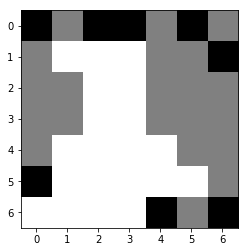

((0, 3), (2, 4)): n_v:   371 q_all:-0.072064 q:-0.067923 q_m:-0.026449 p:0.093033
((0, 2), (2, 4)): n_v:   328 q_all:-0.078909 q:-0.034373 q_m:-0.026449 p:0.090249
((1, 6), (3, 4)): n_v:   320 q_all:-0.053434 q:-0.032206 q_m:-0.011755 p:0.059729
((0, 3), (1, 4)): n_v:   310 q_all:-0.085378 q:-0.026381 q_m:-0.036000 p:0.092303
((0, 5), (2, 4)): n_v:   297 q_all:-0.074884 q:-0.040686 q_m:-0.026449 p:0.077536
((0, 3), (2, 1)): n_v:   258 q_all:-0.047726 q:-0.046488 q_m:-0.011755 p:0.043240
((0, 0), (2, 1)): n_v:   241 q_all:-0.045458 q:-0.044650 q_m:-0.011755 p:0.038378
((1, 6), (2, 5)): n_v:   186 q_all:-0.130351 q:-0.086542 q_m:-0.088898 p:0.084484
((1, 6), (2, 4)): n_v:   181 q_all:-0.089477 q:-0.037996 q_m:-0.026449 p:0.056652
((0, 2), (2, 1)): n_v:   144 q_all:-0.050191 q:-0.046587 q_m:-0.011755 p:0.025403
((5, 0), (3, 1)): n_v:   108 q_all:-0.043782 q:-0.030386 q_m:-0.011755 p:0.016536
((0, 2), (1, 4)): n_v:   103 q_all:-0.091742 q:-0.025160 q_m:-0.047020 p:0.033118
((6, 4), (4, 5))

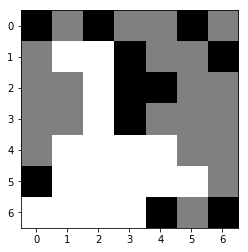

((1, 2), (0, 3)): n_v:   923 q_all:+0.035681 q:+0.015448 q_m:+0.088898 p:0.310830
((4, 3), (3, 4)): n_v:   382 q_all:+0.049219 q:+0.046364 q_m:+0.124163 p:0.108183
((3, 2), (1, 4)): n_v:   202 q_all:+0.037677 q:+0.078036 q_m:+0.144000 p:0.066401
((2, 2), (1, 4)): n_v:   123 q_all:+0.036436 q:+0.104002 q_m:+0.144000 p:0.041323
((1, 1), (0, 3)): n_v:    84 q_all:+0.029204 q:+0.016761 q_m:+0.073469 p:0.030417
((1, 2), (1, 4)): n_v:    69 q_all:+0.039528 q:+0.053796 q_m:+0.144000 p:0.022466
((1, 1), (0, 1)): n_v:    67 q_all:+0.040347 q:+0.015229 q_m:+0.088898 p:0.021632
((5, 5), (3, 4)): n_v:    51 q_all:+0.042939 q:+0.110850 q_m:+0.105796 p:0.015968
((2, 2), (0, 3)): n_v:    47 q_all:+0.017886 q:+0.043166 q_m:+0.073469 p:0.019335
((1, 2), (3, 4)): n_v:    45 q_all:+0.039104 q:+0.043818 q_m:+0.105796 p:0.014586
((5, 4), (6, 5)): n_v:    44 q_all:+0.040947 q:+0.088499 q_m:+0.088898 p:0.014151
((2, 2), (3, 4)): n_v:    43 q_all:+0.025550 q:+0.086576 q_m:+0.105796 p:0.016329
((3, 2), (3, 4))

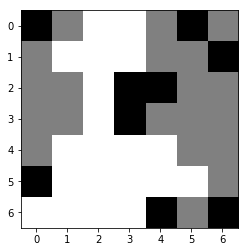

((0, 5), (1, 4)): n_v:   546 q_all:-0.081904 q:-0.047794 q_m:-0.026449 p:0.121445
((0, 0), (0, 1)): n_v:   441 q_all:-0.052267 q:-0.020427 q_m:-0.011755 p:0.051271
((0, 0), (2, 1)): n_v:   349 q_all:-0.047973 q:-0.043303 q_m:-0.006612 p:0.035060
((2, 3), (3, 4)): n_v:   319 q_all:-0.069289 q:-0.041284 q_m:-0.026449 p:0.056557
((0, 5), (0, 4)): n_v:   123 q_all:-0.111337 q:-0.037610 q_m:-0.026449 p:0.040271
((1, 6), (2, 5)): n_v:   122 q_all:-0.142741 q:-0.052328 q_m:-0.073469 p:0.053667
((5, 0), (3, 1)): n_v:   106 q_all:-0.047568 q:-0.019582 q_m:-0.006612 p:0.010591
((1, 6), (1, 4)): n_v:   101 q_all:-0.094651 q:-0.053876 q_m:-0.036000 p:0.027305
((2, 3), (0, 1)): n_v:    98 q_all:-0.075422 q:-0.028722 q_m:-0.018367 p:0.019406
((6, 4), (6, 5)): n_v:    88 q_all:-0.068185 q:-0.016326 q_m:-0.026449 p:0.015193
((3, 3), (1, 4)): n_v:    87 q_all:-0.094102 q:-0.056365 q_m:-0.036000 p:0.023061
((3, 3), (2, 1)): n_v:    59 q_all:-0.070174 q:-0.046262 q_m:-0.006612 p:0.010745
((1, 6), (3, 4))

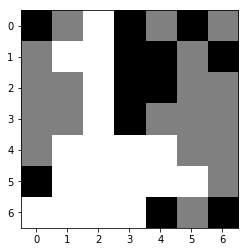

((2, 2), (0, 4)): n_v:   672 q_all:+0.048301 q:+0.062227 q_m:+0.144000 p:0.173652
((4, 3), (3, 4)): n_v:   351 q_all:+0.047856 q:+0.039511 q_m:+0.124163 p:0.091542
((0, 2), (0, 4)): n_v:   343 q_all:+0.055023 q:+0.061069 q_m:+0.144000 p:0.079887
((1, 2), (0, 4)): n_v:   269 q_all:+0.040391 q:+0.046427 q_m:+0.144000 p:0.077717
((5, 4), (6, 5)): n_v:   101 q_all:+0.041805 q:+0.084524 q_m:+0.088898 p:0.028807
((2, 2), (3, 4)): n_v:    68 q_all:+0.030722 q:+0.087987 q_m:+0.105796 p:0.022458
((4, 2), (3, 4)): n_v:    63 q_all:+0.014792 q:+0.050611 q_m:+0.105796 p:0.024635
((0, 2), (0, 1)): n_v:    59 q_all:+0.030592 q:+0.015854 q_m:+0.059510 p:0.019356
((5, 5), (3, 4)): n_v:    56 q_all:+0.043589 q:+0.104442 q_m:+0.105796 p:0.015523
((3, 2), (3, 4)): n_v:    55 q_all:+0.023820 q:+0.054001 q_m:+0.105796 p:0.019456
((1, 2), (3, 4)): n_v:    51 q_all:+0.029431 q:+0.038650 q_m:+0.105796 p:0.016900
((4, 3), (6, 5)): n_v:    40 q_all:+0.016258 q:+0.102321 q_m:+0.073469 p:0.015298
((6, 3), (6, 5))

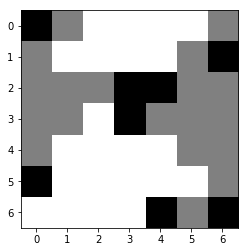

((2, 3), (2, 2)): n_v:  2065 q_all:-0.079034 q:-0.068718 q_m:-0.018367 p:0.378500
((0, 0), (2, 2)): n_v:   275 q_all:-0.089202 q:-0.075280 q_m:-0.026449 p:0.060766
((2, 4), (2, 2)): n_v:   179 q_all:-0.086832 q:-0.070760 q_m:-0.026449 p:0.038160
((1, 6), (1, 5)): n_v:    58 q_all:-0.083417 q:-0.049182 q_m:-0.036000 p:0.011490
((2, 3), (3, 4)): n_v:    48 q_all:-0.105772 q:-0.074338 q_m:-0.059510 p:0.013634
((0, 0), (0, 1)): n_v:    28 q_all:-0.114987 q:-0.054534 q_m:-0.036000 p:0.008855
((3, 3), (1, 5)): n_v:    20 q_all:-0.092534 q:-0.057553 q_m:-0.047020 p:0.004787
((6, 4), (6, 5)): n_v:    13 q_all:-0.109107 q:-0.046566 q_m:-0.059510 p:0.003989
((1, 6), (2, 5)): n_v:    11 q_all:-0.170280 q:-0.095500 q_m:-0.088898 p:0.005892
((2, 3), (0, 1)): n_v:     9 q_all:-0.119631 q:-0.074499 q_m:-0.047020 p:0.003260
((1, 6), (3, 4)): n_v:     9 q_all:-0.114944 q:-0.076434 q_m:-0.073469 p:0.002849
((2, 3), (1, 5)): n_v:     7 q_all:-0.108750 q:-0.048760 q_m:-0.047020 p:0.002116
((0, 0), (2, 1))

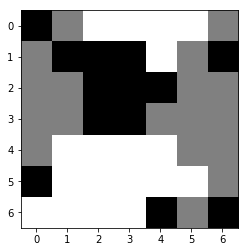

((4, 3), (3, 4)): n_v:  1813 q_all:+0.061647 q:+0.078851 q_m:+0.105796 p:0.248540
((0, 3), (2, 1)): n_v:   188 q_all:+0.061906 q:+0.060513 q_m:+0.124163 p:0.025697
((5, 5), (3, 4)): n_v:   167 q_all:+0.057009 q:+0.122417 q_m:+0.088898 p:0.025426
((1, 4), (2, 5)): n_v:   162 q_all:+0.036385 q:+0.055872 q_m:+0.073469 p:0.034775
((4, 1), (2, 1)): n_v:   157 q_all:+0.070028 q:+0.099663 q_m:+0.124163 p:0.017539
((0, 4), (1, 5)): n_v:   154 q_all:+0.040098 q:+0.029444 q_m:+0.073469 p:0.031269
((0, 2), (0, 1)): n_v:   150 q_all:+0.064122 q:+0.069666 q_m:+0.105796 p:0.019542
((0, 2), (2, 1)): n_v:   115 q_all:+0.065271 q:+0.050285 q_m:+0.124163 p:0.014408
((5, 2), (3, 4)): n_v:    90 q_all:+0.038239 q:+0.081838 q_m:+0.088898 p:0.018815
((4, 2), (3, 4)): n_v:    77 q_all:+0.046524 q:+0.101040 q_m:+0.088898 p:0.014199
((0, 3), (2, 5)): n_v:    72 q_all:+0.029589 q:+0.049809 q_m:+0.059510 p:0.017051
((4, 1), (3, 1)): n_v:    67 q_all:+0.051000 q:+0.114830 q_m:+0.073469 p:0.011317
((5, 4), (6, 5))

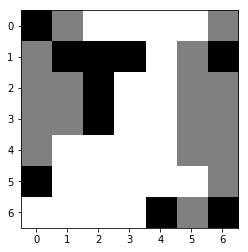

((1, 6), (1, 5)): n_v:   903 q_all:-0.059620 q:-0.045009 q_m:-0.006612 p:0.142382
((1, 6), (2, 5)): n_v:   360 q_all:-0.079014 q:-0.034088 q_m:-0.018367 p:0.078878
((2, 2), (3, 1)): n_v:   252 q_all:-0.098560 q:-0.071264 q_m:-0.036000 p:0.070608
((6, 6), (4, 5)): n_v:   240 q_all:-0.053841 q:-0.016541 q_m:-0.011755 p:0.033408
((6, 4), (4, 5)): n_v:   236 q_all:-0.055577 q:-0.013919 q_m:-0.011755 p:0.034234
((1, 6), (3, 5)): n_v:   212 q_all:-0.086967 q:-0.044793 q_m:-0.026449 p:0.051719
((5, 0), (3, 1)): n_v:   190 q_all:-0.108831 q:-0.046235 q_m:-0.047020 p:0.059733
((1, 1), (2, 1)): n_v:   119 q_all:-0.133746 q:-0.063423 q_m:-0.088898 p:0.047000
((6, 4), (6, 5)): n_v:   116 q_all:-0.084130 q:-0.038503 q_m:-0.036000 p:0.027307
((1, 1), (3, 1)): n_v:   109 q_all:-0.094539 q:-0.065941 q_m:-0.047020 p:0.029271
((1, 3), (3, 5)): n_v:    98 q_all:-0.094776 q:-0.059885 q_m:-0.026449 p:0.026557
((1, 3), (3, 1)): n_v:    70 q_all:-0.098141 q:-0.085147 q_m:-0.047020 p:0.019539
((1, 3), (1, 5))

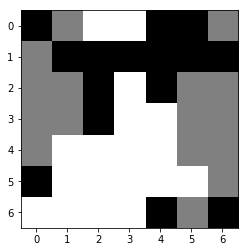

((0, 3), (2, 1)): n_v:   612 q_all:+0.044084 q:+0.041964 q_m:+0.088898 p:0.173339
((3, 4), (2, 5)): n_v:   594 q_all:+0.059109 q:+0.088029 q_m:+0.105796 p:0.136360
((0, 3), (2, 5)): n_v:   323 q_all:+0.047558 q:+0.098625 q_m:+0.088898 p:0.087589
((0, 2), (0, 1)): n_v:   184 q_all:+0.040093 q:+0.066531 q_m:+0.073469 p:0.054736
((4, 1), (2, 1)): n_v:   137 q_all:+0.040557 q:+0.079754 q_m:+0.088898 p:0.040828
((0, 2), (2, 1)): n_v:   122 q_all:+0.043113 q:+0.040066 q_m:+0.088898 p:0.034967
((0, 3), (0, 1)): n_v:   104 q_all:+0.034066 q:+0.060174 q_m:+0.059510 p:0.033308
((4, 3), (2, 1)): n_v:    86 q_all:+0.012815 q:+0.024150 q_m:+0.088898 p:0.034211
((3, 3), (2, 1)): n_v:    83 q_all:+0.013997 q:+0.020310 q_m:+0.088898 p:0.032531
((5, 4), (6, 5)): n_v:    79 q_all:+0.030530 q:+0.065098 q_m:+0.047020 p:0.026537
((3, 4), (4, 5)): n_v:    78 q_all:+0.007974 q:+0.049830 q_m:+0.011755 p:0.032502
((6, 3), (4, 5)): n_v:    67 q_all:-0.013408 q:+0.006069 q_m:+0.006612 p:0.033262
((3, 3), (2, 5))

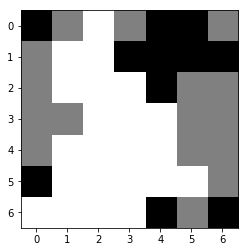

((5, 0), (3, 1)): n_v:  1010 q_all:-0.028601 q:-0.029379 q_m:-0.000735 p:0.102260
((0, 4), (0, 3)): n_v:   568 q_all:-0.081475 q:-0.085038 q_m:-0.026449 p:0.170686
((2, 4), (3, 5)): n_v:   381 q_all:-0.091349 q:-0.106693 q_m:-0.026449 p:0.128314
((0, 5), (0, 3)): n_v:   124 q_all:-0.096548 q:-0.067273 q_m:-0.036000 p:0.044569
((1, 3), (3, 1)): n_v:   111 q_all:-0.063467 q:-0.042318 q_m:-0.000735 p:0.025914
((1, 6), (3, 5)): n_v:   108 q_all:-0.097149 q:-0.091266 q_m:-0.036000 p:0.039092
((1, 5), (0, 3)): n_v:    50 q_all:-0.115034 q:-0.052114 q_m:-0.036000 p:0.021548
((0, 0), (0, 1)): n_v:    44 q_all:-0.088186 q:-0.063349 q_m:-0.011755 p:0.014240
((1, 3), (3, 5)): n_v:    44 q_all:-0.101035 q:-0.070703 q_m:-0.036000 p:0.016554
((6, 6), (4, 5)): n_v:    42 q_all:-0.050469 q:-0.030732 q_m:-0.006612 p:0.007770
((2, 4), (0, 3)): n_v:    28 q_all:-0.099177 q:-0.090896 q_m:-0.036000 p:0.010255
((1, 4), (2, 5)): n_v:    27 q_all:-0.107134 q:-0.089834 q_m:-0.047020 p:0.010978
((1, 5), (3, 5))

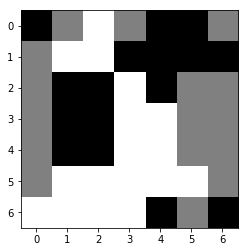

((0, 2), (0, 3)): n_v:  1482 q_all:+0.018751 q:-0.005599 q_m:+0.047020 p:0.258151
((3, 4), (2, 5)): n_v:   236 q_all:+0.031300 q:+0.047281 q_m:+0.073469 p:0.030641
((5, 1), (5, 0)): n_v:   130 q_all:+0.009964 q:+0.038319 q_m:+0.011755 p:0.026800
((1, 1), (0, 3)): n_v:   125 q_all:+0.013676 q:-0.003588 q_m:+0.036000 p:0.024010
((5, 4), (6, 5)): n_v:   123 q_all:+0.014384 q:+0.023059 q_m:+0.026449 p:0.023416
((1, 1), (1, 0)): n_v:   110 q_all:+0.014390 q:+0.022334 q_m:+0.026449 p:0.021021
((5, 5), (5, 6)): n_v:    99 q_all:+0.006874 q:+0.031417 q_m:+0.011755 p:0.021551
((3, 4), (4, 5)): n_v:    89 q_all:-0.000665 q:+0.014561 q_m:+0.002939 p:0.021801
((0, 2), (0, 1)): n_v:    84 q_all:+0.005930 q:+0.008099 q_m:+0.011755 p:0.018583
((1, 1), (2, 0)): n_v:    78 q_all:+0.015857 q:+0.024226 q_m:+0.026449 p:0.014400
((6, 3), (6, 5)): n_v:    74 q_all:+0.008790 q:+0.049586 q_m:+0.018367 p:0.015644
((5, 1), (4, 0)): n_v:    67 q_all:+0.012008 q:+0.003543 q_m:+0.026449 p:0.013325
((6, 3), (4, 5))

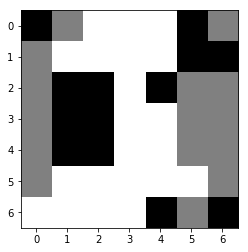

((0, 0), (0, 1)): n_v:   626 q_all:-0.017003 q:-0.029439 q_m:-0.000735 p:0.097232
((1, 5), (2, 5)): n_v:   619 q_all:-0.033067 q:-0.055117 q_m:-0.006612 p:0.129174
((6, 6), (4, 5)): n_v:   447 q_all:-0.021409 q:-0.010254 q_m:-0.000000 p:0.076136
((6, 4), (6, 5)): n_v:   441 q_all:-0.031505 q:-0.044085 q_m:-0.006612 p:0.089724
((6, 4), (4, 5)): n_v:   259 q_all:-0.020158 q:-0.003454 q_m:-0.000000 p:0.042918
((4, 1), (5, 0)): n_v:   207 q_all:-0.018140 q:-0.039969 q_m:-0.000735 p:0.033019
((2, 4), (4, 5)): n_v:   151 q_all:-0.011496 q:-0.013343 q_m:-0.000000 p:0.020861
((0, 5), (2, 5)): n_v:   144 q_all:-0.040447 q:-0.044164 q_m:-0.011755 p:0.033740
((0, 0), (1, 0)): n_v:    44 q_all:-0.050575 q:-0.062912 q_m:-0.018367 p:0.011868
((2, 2), (0, 1)): n_v:    36 q_all:-0.058963 q:-0.035701 q_m:-0.002939 p:0.010710
((6, 6), (5, 6)): n_v:    35 q_all:-0.053669 q:-0.054784 q_m:-0.018367 p:0.009597
((2, 1), (0, 1)): n_v:    31 q_all:-0.049170 q:-0.049682 q_m:-0.002939 p:0.007956
((3, 2), (5, 0))

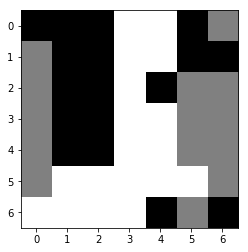

((1, 4), (2, 5)): n_v:   308 q_all:+0.017835 q:+0.052488 q_m:+0.047020 p:0.053554
((5, 1), (4, 0)): n_v:   264 q_all:+0.007917 q:+0.015698 q_m:+0.026449 p:0.055879
((5, 4), (6, 5)): n_v:   235 q_all:+0.007555 q:+0.013271 q_m:+0.026449 p:0.049981
((0, 3), (2, 5)): n_v:   189 q_all:+0.004253 q:+0.011260 q_m:+0.036000 p:0.042687
((3, 4), (4, 5)): n_v:   172 q_all:-0.008471 q:+0.013736 q_m:+0.002939 p:0.047080
((5, 1), (5, 0)): n_v:   156 q_all:+0.002186 q:+0.026538 q_m:+0.011755 p:0.036355
((5, 5), (5, 6)): n_v:   151 q_all:-0.004490 q:-0.003386 q_m:+0.011755 p:0.039123
((6, 0), (4, 0)): n_v:   130 q_all:+0.004906 q:+0.007981 q_m:+0.018367 p:0.029101
((5, 5), (4, 6)): n_v:   125 q_all:-0.019312 q:+0.000989 q_m:+0.002939 p:0.039365
((0, 4), (2, 6)): n_v:    86 q_all:-0.005029 q:+0.028081 q_m:+0.018367 p:0.022589
((0, 4), (2, 5)): n_v:    80 q_all:+0.006635 q:+0.051366 q_m:+0.036000 p:0.017344
((6, 1), (4, 0)): n_v:    79 q_all:+0.002534 q:+0.000779 q_m:+0.018367 p:0.018333
((6, 3), (6, 5))

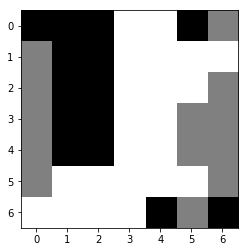

((6, 4), (6, 5)): n_v:   762 q_all:-0.032447 q:-0.027899 q_m:-0.006612 p:0.195723
((6, 6), (4, 5)): n_v:   478 q_all:-0.029627 q:+0.012106 q_m:-0.000000 p:0.117482
((6, 4), (4, 5)): n_v:   320 q_all:-0.031713 q:+0.011067 q_m:-0.000000 p:0.081184
((4, 1), (5, 0)): n_v:   290 q_all:-0.016294 q:-0.012129 q_m:-0.000735 p:0.055738
((6, 6), (5, 6)): n_v:   129 q_all:-0.071641 q:-0.057338 q_m:-0.018367 p:0.053243
((0, 0), (1, 0)): n_v:    81 q_all:-0.070199 q:-0.049416 q_m:-0.036000 p:0.033234
((3, 2), (5, 0)): n_v:    49 q_all:-0.105766 q:-0.040254 q_m:-0.002939 p:0.027178
((6, 6), (4, 6)): n_v:    47 q_all:-0.067621 q:-0.041911 q_m:-0.026449 p:0.019037
((6, 4), (5, 6)): n_v:    46 q_all:-0.065114 q:-0.049661 q_m:-0.026449 p:0.018099
((0, 0), (2, 0)): n_v:    43 q_all:-0.078205 q:-0.051640 q_m:-0.047020 p:0.019226
((3, 1), (5, 0)): n_v:    40 q_all:-0.042397 q:-0.016990 q_m:-0.002939 p:0.012012
((0, 5), (2, 6)): n_v:    23 q_all:-0.025478 q:-0.031635 q_m:-0.002939 p:0.005348
((3, 1), (4, 0))

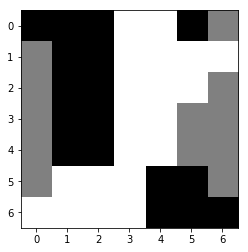

((3, 4), (4, 5)): n_v:   785 q_all:+0.024691 q:+0.026995 q_m:+0.047020 p:0.119716
((5, 1), (5, 0)): n_v:   593 q_all:+0.018534 q:+0.041760 q_m:+0.026449 p:0.103930
((5, 1), (4, 0)): n_v:   417 q_all:+0.024611 q:+0.042020 q_m:+0.047020 p:0.063766
((6, 3), (4, 5)): n_v:   231 q_all:+0.006161 q:+0.025590 q_m:+0.036000 p:0.050915
((1, 5), (2, 6)): n_v:   154 q_all:+0.000649 q:+0.027402 q_m:+0.011755 p:0.037301
((6, 0), (4, 0)): n_v:   117 q_all:+0.018718 q:+0.040661 q_m:+0.036000 p:0.020384
((6, 1), (4, 0)): n_v:    75 q_all:+0.018633 q:+0.049935 q_m:+0.036000 p:0.013059
((1, 5), (0, 6)): n_v:    64 q_all:+0.012538 q:+0.013860 q_m:+0.026449 p:0.012783
((2, 5), (3, 6)): n_v:    42 q_all:-0.003005 q:+0.004611 q_m:+0.011755 p:0.010629
((2, 5), (4, 5)): n_v:    41 q_all:+0.010065 q:+0.033383 q_m:+0.036000 p:0.008403
((6, 2), (5, 0)): n_v:    34 q_all:-0.005848 q:+0.035113 q_m:+0.018367 p:0.009055
((2, 4), (3, 5)): n_v:    33 q_all:-0.001071 q:+0.035107 q_m:+0.011755 p:0.008257
((3, 4), (5, 6))

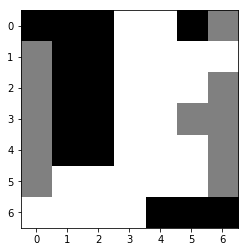

((6, 5), (5, 6)): n_v:   575 q_all:-0.029134 q:-0.029004 q_m:-0.006612 p:0.108373
((4, 1), (5, 0)): n_v:   534 q_all:-0.019081 q:-0.010215 q_m:-0.000735 p:0.080858
((6, 6), (4, 6)): n_v:   375 q_all:-0.045725 q:-0.029066 q_m:-0.011755 p:0.093621
((6, 4), (5, 6)): n_v:   305 q_all:-0.039999 q:-0.043858 q_m:-0.011755 p:0.069609
((0, 0), (1, 0)): n_v:   131 q_all:-0.069348 q:-0.046736 q_m:-0.036000 p:0.043949
((0, 0), (2, 0)): n_v:   115 q_all:-0.079353 q:-0.048419 q_m:-0.047020 p:0.043123
((6, 5), (4, 6)): n_v:   113 q_all:-0.051752 q:-0.031517 q_m:-0.011755 p:0.030706
((0, 5), (2, 6)): n_v:   100 q_all:-0.026255 q:-0.025174 q_m:-0.002939 p:0.017877
((6, 4), (4, 6)): n_v:    87 q_all:-0.045369 q:-0.051577 q_m:-0.011755 p:0.021610
((3, 2), (5, 0)): n_v:    84 q_all:-0.090505 q:-0.037025 q_m:-0.002939 p:0.034732
((3, 1), (5, 0)): n_v:    76 q_all:-0.039754 q:-0.013884 q_m:-0.002939 p:0.017184
((3, 1), (4, 0)): n_v:    63 q_all:-0.068183 q:-0.018200 q_m:-0.018367 p:0.021036
((3, 2), (1, 0))

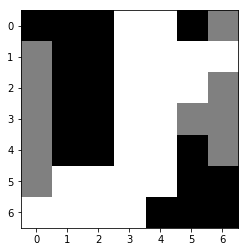

((5, 1), (4, 0)): n_v:   822 q_all:+0.013075 q:+0.022403 q_m:+0.047020 p:0.150996
((1, 5), (2, 6)): n_v:   299 q_all:-0.020710 q:+0.041110 q_m:+0.011755 p:0.093378
((6, 0), (4, 0)): n_v:   262 q_all:+0.011160 q:+0.048198 q_m:+0.036000 p:0.050178
((2, 4), (3, 5)): n_v:   261 q_all:+0.014780 q:+0.051138 q_m:+0.026449 p:0.046302
((6, 1), (4, 0)): n_v:   198 q_all:+0.012449 q:+0.068630 q_m:+0.036000 p:0.036872
((5, 1), (5, 0)): n_v:   146 q_all:+0.003855 q:+0.010809 q_m:+0.026449 p:0.031952
((6, 2), (4, 0)): n_v:    98 q_all:+0.003707 q:+0.027641 q_m:+0.036000 p:0.021634
((2, 5), (3, 6)): n_v:    79 q_all:-0.007936 q:-0.004876 q_m:+0.026449 p:0.020903
((1, 6), (3, 5)): n_v:    78 q_all:+0.007320 q:+0.004323 q_m:+0.018367 p:0.016149
((1, 5), (0, 6)): n_v:    76 q_all:+0.001674 q:+0.030258 q_m:+0.026449 p:0.017419
((0, 4), (2, 6)): n_v:    57 q_all:-0.017820 q:+0.037778 q_m:+0.006612 p:0.017161
((2, 5), (4, 6)): n_v:    48 q_all:+0.017800 q:+0.124829 q_m:+0.059510 p:0.008102
((1, 5), (3, 5))

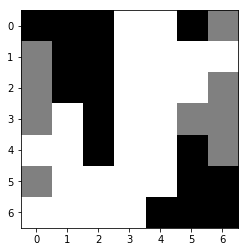

((4, 5), (3, 5)): n_v:  1155 q_all:-0.009605 q:+0.009207 q_m:+0.000735 p:0.276388
((5, 6), (3, 5)): n_v:   565 q_all:-0.012286 q:+0.003634 q_m:-0.000000 p:0.140692
((2, 1), (3, 0)): n_v:   277 q_all:-0.009579 q:+0.025413 q_m:-0.000735 p:0.066439
((5, 5), (3, 5)): n_v:   158 q_all:-0.069072 q:-0.052382 q_m:-0.000000 p:0.072413
((0, 0), (1, 0)): n_v:   112 q_all:-0.069453 q:-0.047263 q_m:-0.036000 p:0.051291
((3, 2), (5, 0)): n_v:    92 q_all:-0.040936 q:+0.029768 q_m:+0.002939 p:0.032665
((0, 2), (1, 0)): n_v:    76 q_all:-0.101613 q:-0.041359 q_m:-0.047020 p:0.044184
((4, 5), (3, 6)): n_v:    75 q_all:-0.068062 q:-0.044263 q_m:-0.018367 p:0.034291
((0, 0), (2, 0)): n_v:    61 q_all:-0.054700 q:-0.019813 q_m:-0.026449 p:0.024912
((3, 2), (1, 0)): n_v:    50 q_all:-0.119967 q:-0.029774 q_m:-0.047020 p:0.032298
((4, 2), (3, 0)): n_v:    31 q_all:-0.043374 q:-0.011267 q_m:-0.002939 p:0.011534
((6, 6), (4, 6)): n_v:    25 q_all:-0.086812 q:-0.025957 q_m:-0.047020 p:0.013343
((2, 2), (3, 0))

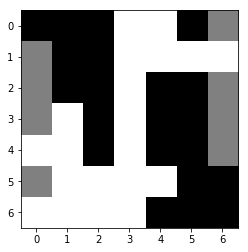

((1, 5), (2, 6)): n_v:  1241 q_all:-0.001490 q:+0.037818 q_m:+0.011755 p:0.208367
((0, 4), (2, 6)): n_v:   459 q_all:-0.012191 q:+0.017017 q_m:+0.006612 p:0.093964
((3, 1), (2, 0)): n_v:   419 q_all:-0.004171 q:-0.002965 q_m:+0.011755 p:0.074242
((3, 1), (3, 0)): n_v:   266 q_all:-0.013310 q:-0.018045 q_m:+0.002939 p:0.055634
((4, 0), (2, 0)): n_v:   135 q_all:-0.002258 q:+0.006712 q_m:+0.006612 p:0.023056
((1, 6), (3, 6)): n_v:   102 q_all:+0.006429 q:+0.027283 q_m:+0.018367 p:0.014408
((4, 0), (5, 0)): n_v:   100 q_all:-0.010986 q:-0.009991 q_m:-0.000000 p:0.020143
((5, 4), (4, 6)): n_v:    77 q_all:+0.001662 q:+0.014062 q_m:+0.036000 p:0.012243
((1, 5), (3, 6)): n_v:    66 q_all:+0.004787 q:+0.029767 q_m:+0.018367 p:0.009792
((5, 4), (3, 6)): n_v:    45 q_all:+0.008600 q:+0.062046 q_m:+0.018367 p:0.006078
((1, 4), (2, 6)): n_v:    40 q_all:-0.034015 q:+0.042303 q_m:+0.006612 p:0.011128
((1, 5), (0, 6)): n_v:    39 q_all:-0.003594 q:+0.025101 q_m:+0.002939 p:0.006969
((1, 4), (3, 6))

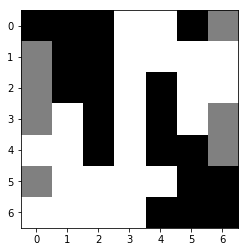

((4, 5), (3, 6)): n_v:  1239 q_all:-0.001194 q:+0.028900 q_m:+0.006612 p:0.311851
((2, 1), (3, 0)): n_v:   715 q_all:-0.005640 q:+0.064695 q_m:+0.006612 p:0.190765
((5, 6), (3, 6)): n_v:   217 q_all:-0.002540 q:+0.017073 q_m:+0.002939 p:0.055703
((0, 0), (1, 0)): n_v:   124 q_all:-0.042564 q:-0.045170 q_m:-0.006612 p:0.048673
((3, 2), (5, 0)): n_v:    81 q_all:-0.014989 q:+0.044634 q_m:+0.026449 p:0.024242
((0, 2), (1, 0)): n_v:    67 q_all:-0.057188 q:-0.042635 q_m:-0.011755 p:0.029944
((1, 2), (3, 0)): n_v:    67 q_all:-0.044637 q:+0.049010 q_m:+0.002939 p:0.026860
((2, 4), (3, 6)): n_v:    64 q_all:-0.010786 q:+0.023193 q_m:+0.002939 p:0.018324
((4, 4), (3, 6)): n_v:    58 q_all:-0.026810 q:+0.000854 q_m:+0.002939 p:0.019634
((4, 2), (3, 0)): n_v:    53 q_all:-0.020038 q:-0.001407 q_m:+0.002939 p:0.016837
((5, 5), (3, 6)): n_v:    53 q_all:-0.051213 q:-0.062165 q_m:+0.002939 p:0.022336
((1, 1), (3, 0)): n_v:    46 q_all:-0.036203 q:+0.022371 q_m:+0.002939 p:0.017170
((2, 2), (3, 0))

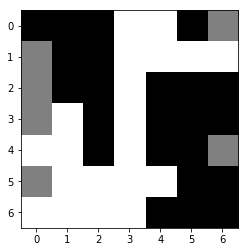

((3, 1), (2, 0)): n_v:  1052 q_all:-0.022413 q:+0.004595 q_m:+0.002939 p:0.197727
((5, 4), (4, 6)): n_v:   529 q_all:-0.004554 q:+0.012630 q_m:+0.036000 p:0.067231
((3, 1), (3, 0)): n_v:   375 q_all:-0.023200 q:-0.001228 q_m:-0.000000 p:0.071573
((4, 0), (2, 0)): n_v:   359 q_all:-0.015848 q:-0.002770 q_m:+0.000735 p:0.059430
((4, 0), (5, 0)): n_v:   266 q_all:-0.028257 q:-0.007184 q_m:-0.002939 p:0.055412
((1, 5), (0, 6)): n_v:   137 q_all:-0.021675 q:+0.005411 q_m:-0.000000 p:0.025189
((3, 1), (1, 0)): n_v:   105 q_all:+0.002375 q:+0.019552 q_m:+0.018367 p:0.010858
((0, 4), (0, 6)): n_v:    89 q_all:-0.047936 q:+0.009505 q_m:-0.000735 p:0.024540
((4, 1), (2, 0)): n_v:    88 q_all:-0.033262 q:-0.004170 q_m:+0.000735 p:0.019970
((6, 2), (5, 0)): n_v:    50 q_all:-0.059329 q:+0.018708 q_m:-0.006612 p:0.015658
((3, 1), (5, 0)): n_v:    44 q_all:-0.035252 q:-0.006075 q_m:-0.006612 p:0.010389
((5, 1), (3, 0)): n_v:    12 q_all:-0.071447 q:+0.004952 q_m:-0.000735 p:0.004205
((1, 4), (0, 6))

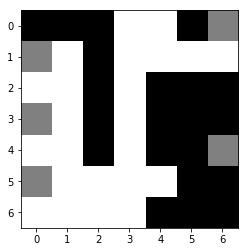

((0, 0), (1, 0)): n_v:   801 q_all:+0.006274 q:+0.047768 q_m:+0.018367 p:0.197358
((0, 2), (1, 0)): n_v:   516 q_all:-0.000764 q:+0.040792 q_m:+0.011755 p:0.139925
((1, 2), (3, 0)): n_v:   337 q_all:+0.012579 q:+0.109281 q_m:+0.047020 p:0.075601
((3, 2), (5, 0)): n_v:   280 q_all:+0.005418 q:+0.032819 q_m:+0.047020 p:0.069782
((3, 2), (1, 0)): n_v:   277 q_all:-0.006221 q:+0.014661 q_m:+0.011755 p:0.080548
((2, 2), (3, 0)): n_v:   233 q_all:+0.014846 q:+0.102154 q_m:+0.047020 p:0.050278
((4, 2), (3, 0)): n_v:   226 q_all:+0.011281 q:+0.044496 q_m:+0.047020 p:0.051745
((2, 2), (1, 0)): n_v:    56 q_all:-0.009868 q:+0.033114 q_m:+0.011755 p:0.017102
((3, 2), (3, 0)): n_v:    55 q_all:+0.000295 q:+0.028787 q_m:+0.047020 p:0.014954
((4, 2), (5, 0)): n_v:    48 q_all:+0.011999 q:+0.026209 q_m:+0.047020 p:0.011051
((6, 6), (4, 6)): n_v:    27 q_all:-0.013515 q:-0.037416 q_m:-0.002939 p:0.008770
((3, 5), (4, 6)): n_v:    21 q_all:-0.008369 q:-0.032525 q_m:-0.000735 p:0.006333
((1, 2), (1, 0))

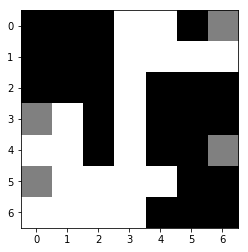

((3, 1), (3, 0)): n_v:  2197 q_all:-0.032368 q:+0.003747 q_m:-0.000000 p:0.251304
((5, 4), (4, 6)): n_v:   367 q_all:-0.027618 q:-0.033833 q_m:+0.018367 p:0.035699
((5, 1), (3, 0)): n_v:    68 q_all:-0.073513 q:+0.032610 q_m:-0.000735 p:0.018091
((4, 0), (5, 0)): n_v:    61 q_all:-0.069089 q:-0.022564 q_m:-0.011755 p:0.015050
((0, 4), (0, 6)): n_v:    34 q_all:-0.082216 q:-0.068799 q_m:-0.006612 p:0.010213
((1, 5), (0, 6)): n_v:    31 q_all:-0.063150 q:-0.020426 q_m:-0.002939 p:0.006899
((5, 2), (3, 0)): n_v:    27 q_all:-0.104683 q:-0.077620 q_m:-0.000735 p:0.010452
((6, 2), (5, 0)): n_v:    14 q_all:-0.095662 q:-0.051554 q_m:-0.018367 p:0.004792
((3, 1), (5, 0)): n_v:     9 q_all:-0.062382 q:-0.023163 q_m:-0.018367 p:0.001974
((1, 4), (0, 6)): n_v:     3 q_all:-0.108474 q:+0.000437 q_m:-0.006612 p:0.001048
((5, 2), (5, 0)): n_v:     1 q_all:-0.162417 q:-0.084064 q_m:-0.018367 p:0.000543
-1 's turn
one move takes time(s):  0.1317901611328125
no. of data collected:  8


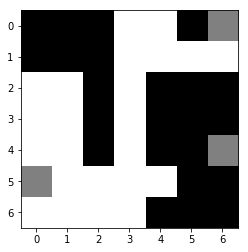

((3, 2), (5, 0)): n_v:  1788 q_all:+0.043120 q:+0.085094 q_m:+0.073469 p:0.199233
((6, 6), (4, 6)): n_v:   486 q_all:+0.005559 q:-0.002419 q_m:-0.000000 p:0.109316
((3, 5), (4, 6)): n_v:   420 q_all:+0.011060 q:+0.007390 q_m:+0.000735 p:0.087589
((4, 2), (5, 0)): n_v:   348 q_all:+0.043636 q:+0.078955 q_m:+0.073469 p:0.038291
((2, 6), (4, 6)): n_v:   215 q_all:-0.019969 q:-0.019358 q_m:-0.000000 p:0.065122
((2, 6), (0, 6)): n_v:   193 q_all:-0.003743 q:-0.004296 q_m:+0.011755 p:0.048915
((6, 4), (4, 6)): n_v:   114 q_all:-0.016623 q:-0.048663 q_m:-0.000000 p:0.033309
((6, 5), (4, 6)): n_v:   112 q_all:-0.019863 q:-0.010922 q_m:-0.000000 p:0.034050
((3, 4), (4, 6)): n_v:    65 q_all:-0.050145 q:-0.019624 q_m:-0.000000 p:0.025799
((2, 4), (4, 6)): n_v:    62 q_all:-0.036855 q:-0.029035 q_m:-0.000000 p:0.021793
((2, 5), (4, 6)): n_v:    44 q_all:-0.044192 q:-0.023128 q_m:-0.000000 p:0.016308
((0, 5), (0, 6)): n_v:    37 q_all:+0.020750 q:+0.040296 q_m:+0.018367 p:0.006746
((2, 4), (0, 6))

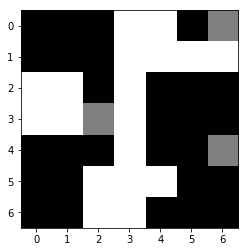

((2, 1), (3, 2)): n_v:  2640 q_all:-0.014219 q:-0.064696 q_m:-0.006612 p:0.176010
((2, 0), (3, 2)): n_v:   386 q_all:-0.031902 q:+0.011459 q_m:-0.011755 p:0.047291
((3, 0), (3, 2)): n_v:   100 q_all:-0.041437 q:+0.005502 q_m:-0.011755 p:0.015175
((1, 4), (3, 2)): n_v:    29 q_all:-0.024202 q:+0.078234 q_m:-0.011755 p:0.002946
((5, 4), (3, 2)): n_v:    15 q_all:-0.077891 q:-0.234754 q_m:-0.011755 p:0.004233
((1, 3), (3, 2)): n_v:     7 q_all:-0.048260 q:-0.000127 q_m:-0.011755 p:0.001203
((5, 3), (3, 2)): n_v:     6 q_all:-0.074013 q:-0.060371 q_m:-0.011755 p:0.001339
((5, 2), (3, 2)): n_v:     5 q_all:-0.122759 q:-0.195318 q_m:-0.011755 p:0.001634
((5, 4), (4, 6)): n_v:     2 q_all:-0.115305 q:-0.392113 q_m:-0.000000 p:0.000703
((0, 4), (0, 6)): n_v:     1 q_all:-0.255258 q:-0.428389 q_m:-0.047020 p:0.000636
((1, 4), (0, 6)): n_v:     0 q_all:-0.060469 q:-0.100816 q_m:-0.047020 p:0.000019
((1, 5), (0, 6)): n_v:     0 q_all:-0.127855 q:-0.403422 q_m:-0.036000 p:0.000013
-1 's turn


Thi

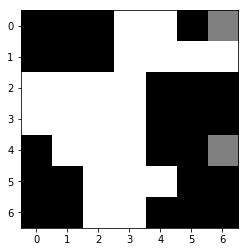

((3, 5), (4, 6)): n_v:  1588 q_all:+0.072743 q:-0.007800 q_m:+0.011755 p:0.101892
((2, 6), (0, 6)): n_v:  1041 q_all:+0.071217 q:+0.031924 q_m:+0.036000 p:0.071322
((6, 6), (4, 6)): n_v:   436 q_all:+0.001930 q:-0.009788 q_m:+0.006612 p:0.117776
((2, 6), (4, 6)): n_v:   226 q_all:-0.003654 q:-0.012021 q_m:+0.006612 p:0.064708
((2, 4), (0, 6)): n_v:   213 q_all:+0.027786 q:+0.020801 q_m:+0.036000 p:0.041334
((0, 5), (0, 6)): n_v:   140 q_all:+0.100263 q:+0.083137 q_m:+0.047020 p:0.005748
((6, 4), (4, 6)): n_v:   109 q_all:-0.017487 q:-0.088013 q_m:+0.006612 p:0.035738
((6, 5), (4, 6)): n_v:   104 q_all:-0.017784 q:-0.058955 q_m:+0.006612 p:0.034151
((2, 4), (4, 6)): n_v:   101 q_all:-0.009984 q:-0.028137 q_m:+0.006612 p:0.030719
((2, 5), (4, 6)): n_v:    80 q_all:-0.006710 q:-0.015689 q_m:+0.006612 p:0.023853
((3, 4), (4, 6)): n_v:    77 q_all:-0.010440 q:-0.016690 q_m:+0.006612 p:0.023243
((2, 5), (0, 6)): n_v:    45 q_all:+0.024371 q:+0.015979 q_m:+0.036000 p:0.008917
((4, 4), (4, 6))

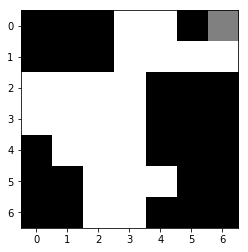

((0, 4), (0, 6)): n_v:  2248 q_all:-0.108074 q:-0.530326 q_m:-0.002939 p:0.122801
((1, 4), (0, 6)): n_v:  1087 q_all:-0.097947 q:-0.054502 q_m:-0.002939 p:0.020750
((1, 5), (0, 6)): n_v:   120 q_all:-1.000000 q:+5.000000 q_m:-0.000735 p:0.356906
-1 's turn
one move takes time(s):  0.05497026443481445
no. of data collected:  8


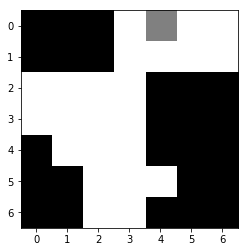

((2, 6), (0, 4)): n_v:  2159 q_all:+0.106421 q:+0.099031 q_m:+0.105796 p:0.484287
((0, 2), (0, 4)): n_v:  1346 q_all:+0.104924 q:+0.122808 q_m:+0.105796 p:0.307900
((1, 2), (0, 4)): n_v:   576 q_all:+0.103339 q:+0.068988 q_m:+0.105796 p:0.134488
((2, 5), (0, 4)): n_v:    86 q_all:+0.033813 q:+0.135745 q_m:+0.105796 p:0.035666
((2, 4), (0, 4)): n_v:    83 q_all:+0.026714 q:+0.105381 q_m:+0.105796 p:0.037583
1 's turn
one move takes time(s):  0.03322744369506836
no. of data collected:  8


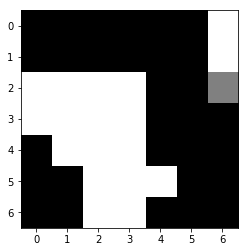

((0, 6), (2, 6)): n_v:  3018 q_all:-0.591051 q:-0.041498 q_m:-0.011755 p:0.495169
((1, 6), (2, 6)): n_v:   359 q_all:-1.000000 q:+5.000000 q_m:-0.006612 p:0.504726
-1 's turn
one move takes time(s):  0.0351412296295166
no. of data collected:  8


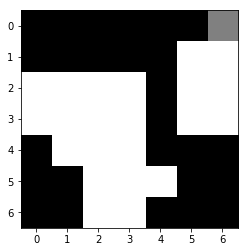

((0, 5), (0, 6)): n_v:  3908 q_all:+1.000000 q:+5.000000 q_m:+0.059510 p:0.285379
((0, 4), (0, 6)): n_v:   130 q_all:+0.036138 q:+0.034813 q_m:+0.047020 p:0.358145
((2, 4), (0, 6)): n_v:    88 q_all:-0.123831 q:-0.036903 q_m:+0.047020 p:0.278994
((1, 4), (0, 6)): n_v:    22 q_all:-0.147915 q:-0.015175 q_m:+0.047020 p:0.069234
this self play has 59 steps, time elapsed 59.69138550758362
winner is -1.0
episode 6 finished
episode 7 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.1691267490386963
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.19745159149169922
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.2675745487213135
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.29141783714294434
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.3732490539550781
no. of data collected:  8
1 's turn




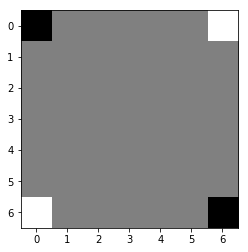

((6, 6), (6, 5)): n_v:   193 q_all:+0.001408 q:+0.025765 q_m:+0.000735 p:0.086930
((6, 6), (5, 6)): n_v:   191 q_all:+0.001712 q:+0.014693 q_m:+0.000735 p:0.086098
((6, 6), (5, 5)): n_v:   184 q_all:+0.002678 q:+0.019983 q_m:+0.000735 p:0.082083
((0, 0), (1, 1)): n_v:   184 q_all:+0.000483 q:+0.004937 q_m:+0.000735 p:0.083746
((0, 0), (0, 1)): n_v:   180 q_all:+0.000887 q:+0.005949 q_m:+0.000735 p:0.081695
((0, 0), (1, 0)): n_v:   179 q_all:+0.000492 q:-0.000797 q_m:+0.000735 p:0.081638
((6, 6), (6, 4)): n_v:   127 q_all:+0.000033 q:+0.011792 q_m:-0.000000 p:0.057869
((6, 6), (4, 6)): n_v:   123 q_all:+0.002930 q:+0.001872 q_m:-0.000000 p:0.054684
((0, 0), (0, 2)): n_v:   121 q_all:+0.000389 q:-0.005670 q_m:-0.000000 p:0.055116
((0, 0), (2, 0)): n_v:   113 q_all:-0.000354 q:-0.005948 q_m:-0.000000 p:0.051964
((6, 6), (5, 4)): n_v:   107 q_all:+0.000849 q:+0.011021 q_m:-0.000000 p:0.048725
((6, 6), (4, 5)): n_v:   105 q_all:+0.002583 q:+0.011597 q_m:-0.000000 p:0.046961
((0, 0), (1, 2))

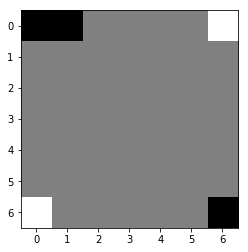

((0, 6), (1, 5)): n_v:   275 q_all:-0.002719 q:-0.003455 q_m:-0.000000 p:0.115837
((6, 0), (5, 1)): n_v:   259 q_all:-0.000214 q:-0.020948 q_m:-0.000000 p:0.106136
((0, 6), (1, 6)): n_v:   212 q_all:-0.003119 q:+0.013953 q_m:-0.000000 p:0.089660
((6, 0), (5, 0)): n_v:   210 q_all:+0.000963 q:+0.000946 q_m:-0.000000 p:0.085293
((0, 6), (0, 5)): n_v:   203 q_all:-0.001607 q:+0.014816 q_m:-0.000000 p:0.084475
((6, 0), (6, 1)): n_v:   195 q_all:-0.000907 q:-0.001741 q_m:-0.000000 p:0.080660
((0, 6), (1, 4)): n_v:   119 q_all:-0.006178 q:-0.003453 q_m:-0.000735 p:0.051839
((0, 6), (0, 4)): n_v:   107 q_all:-0.005699 q:-0.006794 q_m:-0.000735 p:0.046310
((6, 0), (5, 2)): n_v:   106 q_all:-0.001446 q:-0.006636 q_m:-0.000735 p:0.044001
((0, 6), (2, 6)): n_v:   106 q_all:-0.002688 q:-0.003679 q_m:-0.000735 p:0.044821
((6, 0), (6, 2)): n_v:   104 q_all:-0.000408 q:-0.006565 q_m:-0.000735 p:0.042821
((0, 6), (2, 5)): n_v:   103 q_all:-0.001757 q:-0.007435 q_m:-0.000735 p:0.043039
((6, 0), (4, 0))

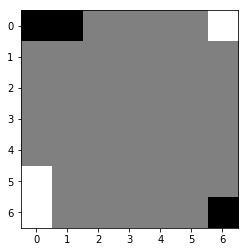

((0, 1), (0, 2)): n_v:   186 q_all:+0.000460 q:-0.002885 q_m:+0.000735 p:0.066400
((0, 0), (1, 1)): n_v:   182 q_all:-0.000427 q:-0.009465 q_m:+0.000735 p:0.065749
((6, 6), (6, 5)): n_v:   176 q_all:-0.000503 q:+0.014548 q_m:+0.000735 p:0.063507
((6, 6), (5, 6)): n_v:   170 q_all:+0.001467 q:+0.004228 q_m:+0.000735 p:0.059991
((6, 6), (5, 5)): n_v:   169 q_all:+0.001051 q:+0.006438 q_m:+0.000735 p:0.059901
((0, 0), (1, 0)): n_v:   164 q_all:-0.000381 q:-0.007800 q_m:+0.000735 p:0.059215
((0, 1), (1, 2)): n_v:   143 q_all:-0.000266 q:+0.003783 q_m:+0.000735 p:0.051566
((0, 0), (0, 2)): n_v:    93 q_all:-0.001148 q:-0.026206 q_m:-0.000000 p:0.034058
((6, 6), (4, 6)): n_v:    91 q_all:+0.002139 q:-0.007664 q_m:-0.000000 p:0.031848
((6, 6), (6, 4)): n_v:    90 q_all:-0.000944 q:-0.001039 q_m:-0.000000 p:0.032599
((0, 1), (0, 3)): n_v:    89 q_all:-0.000560 q:-0.014812 q_m:-0.000000 p:0.032403
((0, 1), (2, 0)): n_v:    81 q_all:-0.001301 q:-0.009716 q_m:-0.000000 p:0.029461
((0, 0), (2, 0))

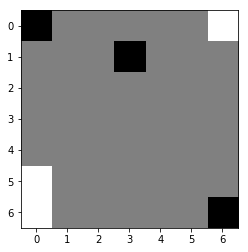

((5, 0), (6, 1)): n_v:   214 q_all:+0.003201 q:+0.003610 q_m:+0.000735 p:0.079778
((0, 6), (0, 5)): n_v:   183 q_all:+0.002817 q:+0.004923 q_m:+0.000735 p:0.068273
((0, 6), (1, 5)): n_v:   177 q_all:+0.000785 q:-0.000523 q_m:+0.000735 p:0.067715
((5, 0), (5, 1)): n_v:   172 q_all:+0.002930 q:-0.013440 q_m:+0.000735 p:0.064129
((5, 0), (4, 0)): n_v:   134 q_all:+0.002852 q:+0.009701 q_m:+0.000735 p:0.050318
((5, 0), (4, 1)): n_v:   128 q_all:+0.004968 q:+0.006463 q_m:+0.000735 p:0.046688
((0, 6), (1, 4)): n_v:   128 q_all:+0.006171 q:+0.014349 q_m:+0.002939 p:0.046027
((0, 6), (1, 6)): n_v:   117 q_all:+0.001224 q:+0.009776 q_m:+0.000735 p:0.044709
((5, 0), (5, 2)): n_v:   103 q_all:-0.001517 q:-0.011048 q_m:-0.000000 p:0.040413
((6, 0), (5, 2)): n_v:   100 q_all:+0.000759 q:+0.009278 q_m:-0.000000 p:0.038362
((0, 6), (0, 4)): n_v:    85 q_all:+0.005345 q:+0.004670 q_m:+0.002939 p:0.031070
((0, 6), (2, 4)): n_v:    78 q_all:+0.005785 q:-0.001030 q_m:+0.002939 p:0.028325
((6, 0), (6, 2))

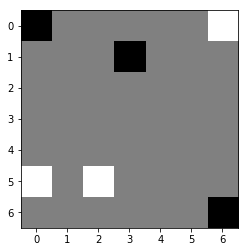

((1, 3), (0, 2)): n_v:   160 q_all:-0.003928 q:-0.009598 q_m:+0.000735 p:0.069240
((1, 3), (0, 4)): n_v:   133 q_all:-0.004198 q:+0.010884 q_m:+0.000735 p:0.057635
((1, 3), (0, 1)): n_v:   124 q_all:-0.004569 q:-0.008255 q_m:-0.000000 p:0.053853
((1, 3), (0, 5)): n_v:   103 q_all:+0.000125 q:+0.010081 q_m:+0.002939 p:0.042758
((0, 0), (1, 1)): n_v:   102 q_all:-0.004647 q:-0.013834 q_m:+0.000735 p:0.044586
((6, 6), (5, 5)): n_v:    99 q_all:-0.001546 q:+0.003958 q_m:+0.000735 p:0.041938
((6, 6), (6, 5)): n_v:    96 q_all:-0.004686 q:-0.002752 q_m:+0.000735 p:0.041819
((0, 0), (0, 1)): n_v:    95 q_all:-0.004525 q:-0.007051 q_m:+0.000735 p:0.041279
((1, 3), (2, 3)): n_v:    90 q_all:-0.004657 q:-0.009358 q_m:+0.000735 p:0.039419
((6, 6), (5, 6)): n_v:    82 q_all:-0.000703 q:-0.004845 q_m:+0.000735 p:0.034403
((1, 3), (1, 1)): n_v:    80 q_all:-0.004901 q:-0.013999 q_m:-0.000000 p:0.035224
((0, 0), (1, 0)): n_v:    76 q_all:-0.004822 q:-0.018452 q_m:+0.000735 p:0.033309
((1, 3), (1, 5))

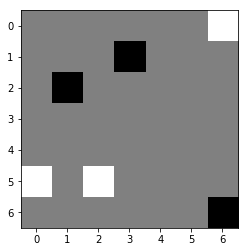

((5, 0), (6, 0)): n_v:   153 q_all:+0.001696 q:+0.014095 q_m:+0.000735 p:0.057630
((5, 0), (6, 1)): n_v:   147 q_all:+0.002786 q:+0.026154 q_m:+0.000735 p:0.055026
((0, 6), (0, 5)): n_v:   127 q_all:+0.002844 q:+0.024711 q_m:+0.000735 p:0.047575
((5, 2), (5, 4)): n_v:   108 q_all:-0.000385 q:+0.027102 q_m:-0.000000 p:0.041828
((5, 0), (5, 1)): n_v:   108 q_all:-0.000441 q:+0.003090 q_m:+0.000735 p:0.041918
((5, 2), (6, 2)): n_v:   100 q_all:+0.001119 q:+0.026264 q_m:+0.000735 p:0.038280
((5, 2), (4, 3)): n_v:    98 q_all:+0.001439 q:+0.049059 q_m:+0.000735 p:0.037115
((0, 6), (1, 5)): n_v:    97 q_all:+0.000743 q:+0.016122 q_m:+0.000735 p:0.037060
((5, 2), (6, 3)): n_v:    93 q_all:+0.003122 q:+0.012317 q_m:+0.000735 p:0.034712
((5, 2), (5, 3)): n_v:    88 q_all:+0.005505 q:+0.039279 q_m:+0.000735 p:0.031830
((0, 6), (1, 6)): n_v:    88 q_all:+0.001231 q:+0.032518 q_m:+0.000735 p:0.033347
((5, 2), (4, 2)): n_v:    82 q_all:-0.001564 q:+0.004418 q_m:+0.000735 p:0.032104
((5, 0), (4, 0))

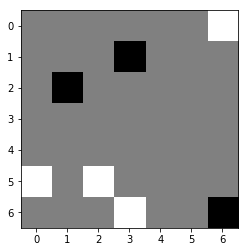

((2, 1), (1, 1)): n_v:   117 q_all:-0.007425 q:-0.028508 q_m:-0.000000 p:0.047345
((1, 3), (0, 4)): n_v:   106 q_all:-0.007151 q:+0.008515 q_m:-0.000000 p:0.043122
((1, 3), (0, 2)): n_v:   104 q_all:-0.006575 q:-0.000143 q_m:-0.000000 p:0.041844
((6, 6), (5, 5)): n_v:   101 q_all:-0.005118 q:-0.013775 q_m:-0.000000 p:0.040052
((2, 1), (1, 0)): n_v:   101 q_all:-0.007313 q:-0.023125 q_m:-0.000000 p:0.040930
((2, 1), (2, 0)): n_v:    84 q_all:-0.008036 q:-0.028515 q_m:-0.000000 p:0.034345
((1, 3), (1, 2)): n_v:    84 q_all:-0.006918 q:-0.017542 q_m:-0.000000 p:0.033815
((6, 6), (6, 5)): n_v:    83 q_all:-0.006878 q:+0.006675 q_m:-0.000000 p:0.033463
((1, 3), (1, 4)): n_v:    79 q_all:-0.005821 q:+0.012704 q_m:-0.000000 p:0.031399
((1, 3), (2, 3)): n_v:    77 q_all:-0.007791 q:-0.018616 q_m:-0.000000 p:0.031607
((1, 3), (1, 1)): n_v:    70 q_all:-0.008555 q:-0.023255 q_m:-0.000735 p:0.028968
((1, 3), (0, 1)): n_v:    70 q_all:-0.008344 q:-0.030412 q_m:-0.000735 p:0.028639
((2, 1), (3, 2))

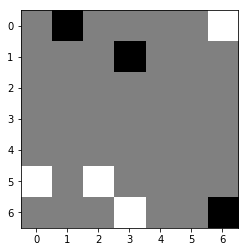

((6, 3), (6, 5)): n_v:   139 q_all:+0.006436 q:+0.031240 q_m:+0.006612 p:0.051669
((6, 3), (6, 1)): n_v:   133 q_all:+0.004090 q:+0.021727 q_m:+0.000735 p:0.050702
((6, 3), (5, 4)): n_v:   111 q_all:+0.005198 q:+0.049367 q_m:+0.002939 p:0.041733
((5, 0), (6, 1)): n_v:   110 q_all:+0.010073 q:+0.007228 q_m:+0.002939 p:0.039039
((5, 0), (6, 0)): n_v:   104 q_all:+0.005441 q:+0.036052 q_m:+0.002939 p:0.038846
((5, 2), (6, 2)): n_v:    99 q_all:+0.009928 q:+0.044204 q_m:+0.002939 p:0.035363
((6, 3), (6, 4)): n_v:    93 q_all:+0.007002 q:+0.025718 q_m:+0.002939 p:0.034315
((5, 2), (5, 3)): n_v:    79 q_all:+0.007782 q:+0.031221 q_m:+0.002939 p:0.029054
((6, 3), (5, 1)): n_v:    76 q_all:+0.004208 q:-0.001078 q_m:+0.000735 p:0.028929
((0, 6), (0, 5)): n_v:    74 q_all:+0.007206 q:+0.034660 q_m:+0.002939 p:0.027433
((5, 2), (5, 4)): n_v:    72 q_all:+0.002533 q:+0.030485 q_m:+0.000735 p:0.027922
((6, 3), (5, 5)): n_v:    71 q_all:+0.006862 q:+0.027772 q_m:+0.006612 p:0.026436
((5, 2), (4, 3))

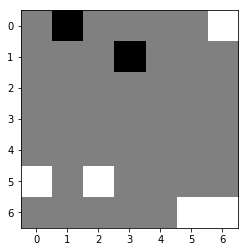

((0, 1), (0, 0)): n_v:   163 q_all:-0.012402 q:-0.013359 q_m:-0.002939 p:0.060155
((1, 3), (0, 5)): n_v:   157 q_all:-0.005835 q:-0.001573 q_m:-0.000735 p:0.053853
((1, 3), (0, 4)): n_v:   139 q_all:-0.012464 q:-0.000770 q_m:-0.002939 p:0.051142
((1, 3), (1, 5)): n_v:   139 q_all:-0.006977 q:+0.003025 q_m:-0.000735 p:0.048254
((0, 1), (1, 1)): n_v:   136 q_all:-0.012390 q:-0.016376 q_m:-0.002939 p:0.050285
((0, 1), (0, 2)): n_v:   132 q_all:-0.011968 q:-0.018560 q_m:-0.002939 p:0.048473
((1, 3), (1, 4)): n_v:   131 q_all:-0.011526 q:-0.008922 q_m:-0.002939 p:0.048101
((1, 3), (2, 3)): n_v:   129 q_all:-0.013237 q:-0.016624 q_m:-0.002939 p:0.048036
((1, 3), (2, 2)): n_v:   124 q_all:-0.012903 q:-0.020521 q_m:-0.002939 p:0.046142
((1, 3), (1, 1)): n_v:   123 q_all:-0.015493 q:-0.020571 q_m:-0.006612 p:0.047017
((0, 1), (1, 0)): n_v:   121 q_all:-0.012279 q:-0.013349 q_m:-0.002939 p:0.044760
((1, 3), (2, 4)): n_v:   112 q_all:-0.009948 q:-0.030012 q_m:-0.002939 p:0.040361
((1, 3), (0, 3))

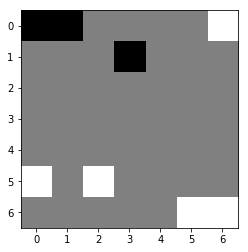

((5, 2), (6, 3)): n_v:   109 q_all:+0.009756 q:+0.025701 q_m:+0.006612 p:0.038282
((5, 2), (6, 2)): n_v:   109 q_all:+0.008590 q:+0.042884 q_m:+0.006612 p:0.038544
((6, 5), (6, 4)): n_v:   108 q_all:+0.007678 q:+0.019453 q_m:+0.006612 p:0.038744
((5, 0), (6, 0)): n_v:   104 q_all:+0.006616 q:+0.035820 q_m:+0.006612 p:0.037633
((5, 0), (6, 1)): n_v:   103 q_all:+0.008700 q:+0.039320 q_m:+0.006612 p:0.036708
((6, 5), (5, 4)): n_v:    91 q_all:+0.008002 q:+0.057018 q_m:+0.006612 p:0.032692
((5, 2), (4, 3)): n_v:    90 q_all:+0.005511 q:+0.055422 q_m:+0.006612 p:0.033229
((5, 2), (5, 3)): n_v:    86 q_all:+0.009291 q:+0.043642 q_m:+0.006612 p:0.030276
((5, 0), (5, 1)): n_v:    77 q_all:+0.007433 q:+0.015375 q_m:+0.006612 p:0.027914
((6, 5), (5, 6)): n_v:    77 q_all:+0.010759 q:+0.032134 q_m:+0.006612 p:0.026863
((5, 2), (5, 4)): n_v:    76 q_all:+0.004651 q:+0.026510 q_m:+0.002939 p:0.028096
((6, 5), (5, 5)): n_v:    74 q_all:+0.009121 q:+0.035150 q_m:+0.006612 p:0.026097
((5, 0), (4, 0))

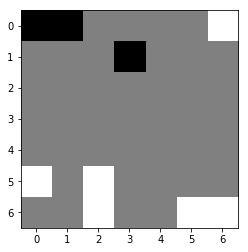

((0, 0), (1, 1)): n_v:   170 q_all:-0.014193 q:-0.018408 q_m:-0.002939 p:0.058789
((1, 3), (0, 5)): n_v:   140 q_all:-0.008055 q:-0.010612 q_m:-0.000735 p:0.044822
((0, 1), (0, 2)): n_v:   139 q_all:-0.014207 q:-0.010062 q_m:-0.002939 p:0.047976
((1, 3), (0, 4)): n_v:   125 q_all:-0.014733 q:-0.021623 q_m:-0.002939 p:0.043595
((1, 3), (1, 5)): n_v:   124 q_all:-0.009611 q:-0.016404 q_m:-0.000735 p:0.040484
((1, 3), (1, 1)): n_v:   122 q_all:-0.016894 q:-0.012606 q_m:-0.006612 p:0.043725
((1, 3), (1, 4)): n_v:   118 q_all:-0.014740 q:-0.031568 q_m:-0.002939 p:0.041045
((0, 0), (1, 0)): n_v:   116 q_all:-0.014473 q:-0.022740 q_m:-0.002939 p:0.040291
((0, 1), (1, 2)): n_v:   111 q_all:-0.014401 q:-0.011903 q_m:-0.002939 p:0.038385
((1, 3), (2, 2)): n_v:   110 q_all:-0.014606 q:-0.031270 q_m:-0.002939 p:0.038412
((1, 3), (2, 3)): n_v:   108 q_all:-0.015633 q:-0.025309 q_m:-0.002939 p:0.037957
((1, 3), (2, 4)): n_v:    92 q_all:-0.012659 q:-0.063241 q_m:-0.002939 p:0.031399
((1, 3), (0, 3))

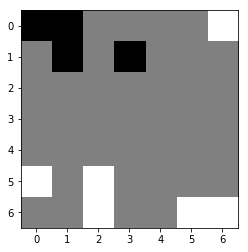

((5, 0), (6, 1)): n_v:   147 q_all:+0.008937 q:+0.046466 q_m:+0.006612 p:0.044961
((5, 0), (6, 0)): n_v:   134 q_all:+0.008256 q:+0.035979 q_m:+0.006612 p:0.041125
((6, 5), (6, 4)): n_v:   119 q_all:+0.004396 q:+0.025064 q_m:+0.006612 p:0.038582
((6, 5), (5, 6)): n_v:   102 q_all:+0.008803 q:+0.060457 q_m:+0.006612 p:0.031150
((6, 5), (5, 4)): n_v:   100 q_all:+0.006693 q:+0.050417 q_m:+0.006612 p:0.031497
((0, 6), (1, 6)): n_v:    82 q_all:+0.004658 q:+0.068770 q_m:+0.006612 p:0.026501
((5, 2), (4, 3)): n_v:    79 q_all:+0.004464 q:+0.063854 q_m:+0.006612 p:0.025735
((0, 6), (0, 5)): n_v:    76 q_all:+0.005722 q:+0.060975 q_m:+0.006612 p:0.024323
((5, 2), (6, 3)): n_v:    75 q_all:+0.008904 q:+0.032413 q_m:+0.006612 p:0.022928
((5, 2), (5, 3)): n_v:    74 q_all:+0.006993 q:+0.057153 q_m:+0.006612 p:0.023114
((5, 2), (5, 4)): n_v:    68 q_all:+0.004980 q:+0.032620 q_m:+0.002939 p:0.021806
((5, 2), (4, 2)): n_v:    62 q_all:+0.005066 q:+0.013497 q_m:+0.006612 p:0.020152
((5, 0), (5, 1))

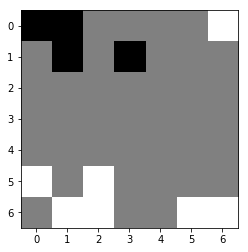

((1, 3), (1, 5)): n_v:   176 q_all:-0.007905 q:+0.000516 q_m:-0.000735 p:0.051335
((0, 1), (0, 2)): n_v:   169 q_all:-0.013494 q:-0.015102 q_m:-0.002939 p:0.053018
((1, 3), (0, 3)): n_v:   166 q_all:-0.009383 q:-0.024169 q_m:-0.002939 p:0.049522
((1, 3), (2, 3)): n_v:   131 q_all:-0.014521 q:-0.021503 q_m:-0.002939 p:0.041789
((1, 3), (0, 4)): n_v:   116 q_all:-0.012840 q:-0.019743 q_m:-0.002939 p:0.036315
((1, 3), (1, 4)): n_v:   113 q_all:-0.010315 q:-0.006257 q_m:-0.002939 p:0.034262
((1, 3), (0, 5)): n_v:   106 q_all:-0.006946 q:-0.016777 q_m:-0.000735 p:0.030595
((0, 0), (1, 0)): n_v:   101 q_all:-0.011029 q:-0.024434 q_m:-0.002939 p:0.030959
((0, 1), (1, 2)): n_v:    93 q_all:-0.012482 q:-0.036546 q_m:-0.002939 p:0.028995
((1, 1), (2, 2)): n_v:    89 q_all:-0.012869 q:-0.025778 q_m:-0.002939 p:0.027689
((1, 1), (2, 1)): n_v:    84 q_all:-0.013263 q:-0.016119 q_m:-0.002939 p:0.026548
((1, 1), (2, 0)): n_v:    83 q_all:-0.014967 q:-0.023073 q_m:-0.002939 p:0.026836
((1, 3), (2, 4))

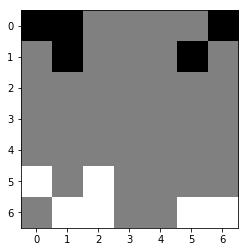

((5, 0), (6, 0)): n_v:   178 q_all:+0.005863 q:+0.020512 q_m:+0.002939 p:0.054170
((6, 5), (5, 6)): n_v:   121 q_all:+0.007698 q:+0.053203 q_m:+0.002939 p:0.036135
((5, 0), (4, 1)): n_v:    93 q_all:+0.004113 q:+0.059117 q_m:+0.002939 p:0.028962
((6, 5), (6, 4)): n_v:    93 q_all:+0.004509 q:+0.000445 q_m:+0.002939 p:0.028886
((5, 2), (6, 3)): n_v:    83 q_all:+0.008427 q:-0.008324 q_m:+0.002939 p:0.024474
((6, 5), (5, 5)): n_v:    75 q_all:+0.004709 q:+0.040453 q_m:+0.002939 p:0.023347
((5, 0), (5, 1)): n_v:    72 q_all:+0.004622 q:+0.039292 q_m:+0.002939 p:0.022445
((5, 0), (4, 0)): n_v:    70 q_all:+0.006000 q:+0.043203 q_m:+0.002939 p:0.021229
((6, 5), (5, 4)): n_v:    66 q_all:+0.006391 q:+0.044840 q_m:+0.002939 p:0.020096
((5, 2), (4, 3)): n_v:    65 q_all:+0.002959 q:+0.064376 q_m:+0.002939 p:0.020751
((6, 2), (6, 0)): n_v:    63 q_all:+0.001177 q:+0.010367 q_m:+0.000735 p:0.020522
((5, 2), (4, 2)): n_v:    63 q_all:+0.002508 q:+0.015031 q_m:+0.002939 p:0.019982
((5, 2), (6, 0))

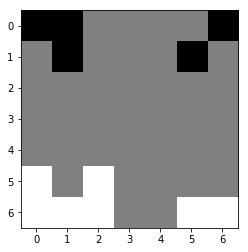

((0, 1), (0, 2)): n_v:   136 q_all:-0.003592 q:+0.014858 q_m:-0.000735 p:0.044494
((1, 5), (0, 4)): n_v:   125 q_all:-0.004553 q:-0.019972 q_m:-0.000735 p:0.041430
((0, 6), (0, 5)): n_v:   103 q_all:-0.004890 q:-0.024848 q_m:-0.000735 p:0.034136
((0, 6), (1, 6)): n_v:    98 q_all:-0.003800 q:-0.016458 q_m:-0.000735 p:0.032114
((0, 0), (1, 0)): n_v:    91 q_all:-0.005633 q:-0.024844 q_m:-0.000735 p:0.030606
((1, 1), (2, 0)): n_v:    89 q_all:-0.007648 q:-0.008284 q_m:-0.000735 p:0.030579
((1, 5), (1, 4)): n_v:    89 q_all:-0.004873 q:-0.027224 q_m:-0.000735 p:0.029703
((0, 1), (1, 2)): n_v:    83 q_all:-0.005720 q:-0.011875 q_m:-0.000735 p:0.027836
((1, 1), (2, 2)): n_v:    83 q_all:-0.005304 q:-0.005979 q_m:-0.000735 p:0.027851
((1, 5), (2, 6)): n_v:    83 q_all:-0.003630 q:-0.024049 q_m:-0.000735 p:0.027303
((1, 5), (2, 4)): n_v:    81 q_all:-0.002834 q:-0.024402 q_m:-0.000735 p:0.026102
((1, 1), (2, 1)): n_v:    76 q_all:-0.005820 q:-0.003873 q_m:-0.000735 p:0.025480
((1, 5), (2, 5))

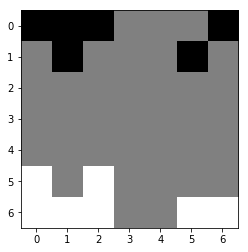

((5, 2), (6, 3)): n_v:   139 q_all:+0.007343 q:-0.019613 q_m:+0.002939 p:0.039152
((6, 5), (5, 6)): n_v:   121 q_all:+0.006610 q:+0.020154 q_m:+0.002939 p:0.034526
((6, 5), (5, 5)): n_v:   101 q_all:+0.004129 q:+0.011950 q_m:+0.002939 p:0.029705
((5, 0), (5, 1)): n_v:    95 q_all:+0.001882 q:+0.042378 q_m:+0.002939 p:0.028995
((5, 0), (4, 1)): n_v:    92 q_all:+0.002875 q:+0.035664 q_m:+0.002939 p:0.027754
((5, 2), (5, 3)): n_v:    91 q_all:+0.003671 q:+0.030426 q_m:+0.002939 p:0.027107
((5, 2), (4, 3)): n_v:    84 q_all:+0.003452 q:+0.063553 q_m:+0.002939 p:0.025083
((6, 5), (5, 4)): n_v:    80 q_all:+0.004475 q:+0.012598 q_m:+0.002939 p:0.023557
((6, 5), (6, 4)): n_v:    76 q_all:+0.003268 q:-0.000109 q_m:+0.002939 p:0.022739
((5, 2), (5, 4)): n_v:    74 q_all:+0.002515 q:+0.005891 q_m:+0.000735 p:0.022494
((5, 0), (4, 0)): n_v:    70 q_all:+0.003006 q:+0.014454 q_m:+0.002939 p:0.021018
((5, 2), (4, 2)): n_v:    63 q_all:+0.000870 q:+0.001928 q_m:+0.002939 p:0.019319
((6, 2), (5, 4))

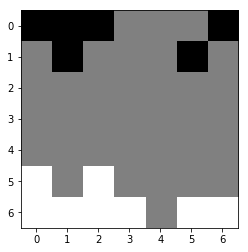

((0, 2), (1, 3)): n_v:   186 q_all:-0.002517 q:-0.023312 q_m:-0.000735 p:0.064589
((1, 5), (0, 4)): n_v:   106 q_all:-0.001110 q:-0.016646 q_m:-0.000735 p:0.036278
((0, 0), (1, 0)): n_v:    83 q_all:+0.003318 q:-0.019835 q_m:-0.000735 p:0.026951
((0, 2), (0, 3)): n_v:    81 q_all:+0.002757 q:-0.021811 q_m:-0.000735 p:0.026360
((1, 1), (2, 1)): n_v:    79 q_all:-0.001635 q:+0.002566 q_m:-0.000735 p:0.027220
((1, 5), (2, 5)): n_v:    79 q_all:+0.000220 q:-0.013652 q_m:-0.000735 p:0.026716
((0, 1), (1, 2)): n_v:    78 q_all:-0.002931 q:-0.021442 q_m:-0.000735 p:0.027271
((0, 6), (1, 6)): n_v:    78 q_all:-0.000786 q:-0.029998 q_m:-0.000735 p:0.026577
((1, 5), (1, 4)): n_v:    76 q_all:-0.000962 q:-0.072310 q_m:-0.000735 p:0.026006
((1, 1), (1, 3)): n_v:    72 q_all:-0.004986 q:-0.032225 q_m:-0.002939 p:0.025870
((0, 6), (0, 5)): n_v:    69 q_all:-0.000865 q:-0.029440 q_m:-0.000735 p:0.023792
((1, 1), (2, 0)): n_v:    66 q_all:-0.003494 q:-0.009245 q_m:-0.000735 p:0.023365
((1, 5), (1, 3))

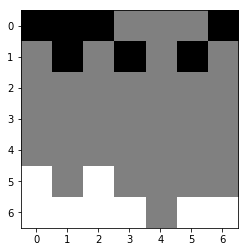

((6, 3), (6, 4)): n_v:   123 q_all:+0.006503 q:-0.018084 q_m:+0.002939 p:0.033101
((6, 5), (5, 6)): n_v:   118 q_all:+0.008579 q:+0.006046 q_m:+0.002939 p:0.030896
((6, 3), (5, 4)): n_v:   114 q_all:+0.007749 q:-0.005915 q_m:+0.002939 p:0.030102
((5, 2), (5, 3)): n_v:    95 q_all:+0.003164 q:-0.025992 q_m:+0.002939 p:0.027065
((5, 2), (4, 3)): n_v:    88 q_all:+0.002975 q:+0.045924 q_m:+0.002939 p:0.025149
((6, 5), (5, 5)): n_v:    85 q_all:+0.006866 q:+0.003814 q_m:+0.002939 p:0.022914
((5, 2), (5, 4)): n_v:    83 q_all:+0.003447 q:-0.014105 q_m:+0.000735 p:0.023569
((6, 3), (5, 5)): n_v:    81 q_all:+0.000605 q:+0.017711 q_m:+0.000735 p:0.023756
((5, 2), (4, 2)): n_v:    79 q_all:+0.002574 q:-0.007268 q_m:+0.002939 p:0.022573
((5, 0), (5, 1)): n_v:    78 q_all:+0.001101 q:+0.033173 q_m:+0.002939 p:0.022961
((6, 3), (5, 1)): n_v:    76 q_all:-0.001299 q:+0.016596 q_m:+0.000735 p:0.022955
((5, 0), (4, 1)): n_v:    71 q_all:+0.003565 q:+0.062520 q_m:+0.002939 p:0.020202
((6, 2), (5, 4))

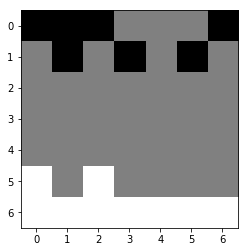

((1, 3), (2, 3)): n_v:    96 q_all:-0.003529 q:-0.012359 q_m:-0.000735 p:0.029413
((0, 2), (0, 3)): n_v:    86 q_all:-0.001623 q:-0.029532 q_m:-0.000735 p:0.025577
((1, 3), (0, 4)): n_v:    83 q_all:-0.001297 q:-0.012842 q_m:-0.000735 p:0.024834
((1, 1), (2, 2)): n_v:    81 q_all:-0.003157 q:+0.004235 q_m:-0.000735 p:0.024672
((0, 6), (0, 5)): n_v:    80 q_all:-0.003317 q:-0.033486 q_m:-0.000735 p:0.024558
((1, 1), (2, 0)): n_v:    76 q_all:-0.003755 q:+0.001939 q_m:-0.000735 p:0.023447
((1, 3), (1, 4)): n_v:    75 q_all:-0.001534 q:-0.048274 q_m:-0.000735 p:0.022504
((0, 0), (1, 0)): n_v:    71 q_all:+0.000576 q:-0.035876 q_m:-0.000735 p:0.020602
((0, 6), (1, 6)): n_v:    70 q_all:-0.001190 q:-0.012041 q_m:-0.000735 p:0.020733
((1, 1), (2, 1)): n_v:    68 q_all:-0.002787 q:-0.017696 q_m:-0.000735 p:0.020595
((1, 5), (2, 6)): n_v:    64 q_all:-0.001178 q:-0.040275 q_m:-0.000735 p:0.018950
((1, 5), (2, 5)): n_v:    63 q_all:-0.001230 q:-0.011116 q_m:-0.000735 p:0.018864
((1, 3), (2, 4))

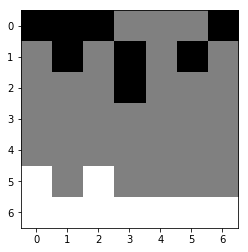

((6, 3), (5, 4)): n_v:   116 q_all:+0.006553 q:-0.001827 q_m:+0.002939 p:0.032269
((5, 2), (4, 3)): n_v:   111 q_all:+0.003663 q:+0.046647 q_m:+0.002939 p:0.032150
((5, 2), (5, 3)): n_v:   102 q_all:+0.002473 q:+0.025241 q_m:+0.002939 p:0.030056
((5, 2), (4, 2)): n_v:    98 q_all:+0.002640 q:+0.009514 q_m:+0.002939 p:0.028825
((6, 5), (5, 6)): n_v:    62 q_all:+0.004279 q:-0.003921 q_m:+0.002939 p:0.017940
((5, 0), (4, 1)): n_v:    61 q_all:+0.002198 q:-0.005016 q_m:+0.002939 p:0.018093
((5, 2), (3, 3)): n_v:    61 q_all:-0.001116 q:+0.022690 q_m:+0.006612 p:0.018946
((6, 2), (5, 4)): n_v:    59 q_all:+0.000425 q:+0.011741 q_m:+0.000735 p:0.018053
((6, 3), (4, 1)): n_v:    59 q_all:-0.002327 q:+0.018393 q_m:+0.000735 p:0.018639
((6, 4), (5, 5)): n_v:    55 q_all:+0.004832 q:-0.007743 q_m:+0.002939 p:0.015714
((5, 2), (4, 4)): n_v:    55 q_all:+0.005039 q:+0.035556 q_m:+0.000735 p:0.015819
((6, 4), (4, 2)): n_v:    53 q_all:-0.003275 q:-0.000781 q_m:+0.000735 p:0.017123
((6, 3), (4, 5))

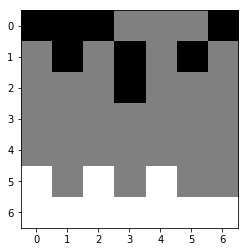

((0, 6), (0, 5)): n_v:   101 q_all:-0.004641 q:-0.043056 q_m:-0.000735 p:0.029717
((1, 3), (0, 4)): n_v:    96 q_all:-0.003088 q:-0.043184 q_m:-0.000735 p:0.027491
((0, 2), (0, 3)): n_v:    92 q_all:-0.003302 q:-0.027205 q_m:-0.000735 p:0.026345
((2, 3), (3, 2)): n_v:    92 q_all:-0.006603 q:+0.002276 q_m:-0.000735 p:0.027820
((2, 3), (3, 4)): n_v:    85 q_all:-0.006598 q:-0.011518 q_m:-0.000735 p:0.025556
((2, 3), (4, 3)): n_v:    77 q_all:-0.014649 q:+0.014402 q_m:+0.002939 p:0.025684
((2, 3), (0, 5)): n_v:    72 q_all:-0.006235 q:-0.029232 q_m:-0.002939 p:0.021705
((1, 3), (2, 4)): n_v:    72 q_all:-0.004076 q:-0.062926 q_m:-0.000735 p:0.021112
((1, 1), (2, 2)): n_v:    61 q_all:-0.006115 q:+0.015361 q_m:-0.000735 p:0.018443
((1, 1), (2, 0)): n_v:    60 q_all:-0.006503 q:-0.040433 q_m:-0.000735 p:0.018039
((1, 3), (1, 4)): n_v:    58 q_all:-0.004881 q:-0.052225 q_m:-0.000735 p:0.016971
((2, 3), (4, 1)): n_v:    57 q_all:-0.009424 q:+0.035186 q_m:+0.002939 p:0.017984
((0, 2), (0, 4))

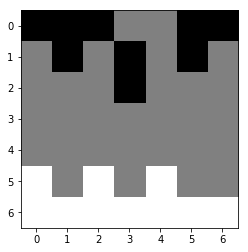

((5, 2), (5, 3)): n_v:   132 q_all:+0.002862 q:+0.028136 q_m:+0.002939 p:0.036188
((6, 5), (5, 6)): n_v:   127 q_all:+0.010065 q:-0.001319 q_m:+0.002939 p:0.031142
((5, 2), (4, 3)): n_v:   107 q_all:+0.003006 q:+0.027270 q_m:+0.002939 p:0.029247
((5, 2), (4, 2)): n_v:    90 q_all:+0.000939 q:+0.003821 q_m:+0.002939 p:0.025368
((5, 4), (4, 4)): n_v:    86 q_all:+0.005643 q:+0.000818 q_m:+0.002939 p:0.022630
((6, 4), (4, 2)): n_v:    66 q_all:-0.000422 q:-0.001291 q_m:+0.000735 p:0.019146
((6, 3), (5, 1)): n_v:    59 q_all:+0.000889 q:+0.008912 q_m:+0.000735 p:0.016709
((6, 2), (4, 4)): n_v:    58 q_all:+0.001452 q:+0.010109 q_m:+0.000735 p:0.016384
((5, 0), (5, 1)): n_v:    58 q_all:+0.002842 q:+0.034373 q_m:+0.002939 p:0.016074
((6, 5), (5, 3)): n_v:    54 q_all:+0.000337 q:-0.028697 q_m:+0.000735 p:0.015405
((5, 2), (4, 4)): n_v:    54 q_all:+0.003901 q:+0.043428 q_m:+0.000735 p:0.014714
((6, 3), (4, 4)): n_v:    53 q_all:+0.002211 q:-0.003908 q_m:+0.000735 p:0.014690
((6, 3), (4, 2))

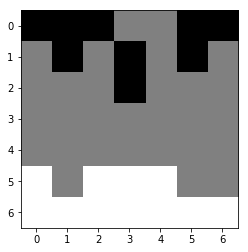

((2, 3), (4, 3)): n_v:   199 q_all:-0.005098 q:+0.013907 q_m:+0.011755 p:0.050545
((0, 2), (0, 3)): n_v:   145 q_all:-0.007019 q:-0.017453 q_m:-0.000735 p:0.038119
((0, 5), (0, 4)): n_v:   141 q_all:-0.004964 q:-0.011812 q_m:-0.000735 p:0.035640
((0, 1), (1, 2)): n_v:    74 q_all:-0.008867 q:-0.013809 q_m:-0.000735 p:0.019917
((2, 3), (0, 4)): n_v:    69 q_all:-0.008001 q:-0.012758 q_m:-0.002939 p:0.018472
((0, 5), (1, 4)): n_v:    65 q_all:-0.006038 q:+0.004701 q_m:-0.000735 p:0.016905
((1, 3), (2, 4)): n_v:    57 q_all:-0.011090 q:-0.048298 q_m:-0.000735 p:0.016108
((2, 3), (4, 2)): n_v:    56 q_all:-0.020595 q:-0.013136 q_m:+0.002939 p:0.017760
((0, 1), (0, 3)): n_v:    53 q_all:-0.010095 q:-0.021621 q_m:-0.002939 p:0.014658
((2, 3), (3, 4)): n_v:    53 q_all:-0.012727 q:-0.011847 q_m:-0.000735 p:0.015127
((1, 1), (2, 2)): n_v:    51 q_all:-0.009896 q:+0.009523 q_m:-0.000735 p:0.013977
((0, 5), (0, 3)): n_v:    50 q_all:-0.010331 q:-0.018482 q_m:-0.002939 p:0.013907
((2, 3), (4, 1))

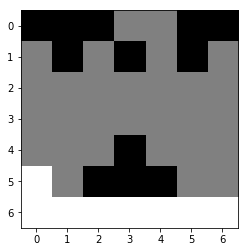

((6, 4), (4, 2)): n_v:   313 q_all:-0.004361 q:+0.009795 q_m:+0.002939 p:0.114373
((5, 0), (4, 2)): n_v:   308 q_all:-0.002024 q:+0.017658 q_m:+0.002939 p:0.109565
((6, 1), (4, 2)): n_v:   273 q_all:-0.002733 q:+0.006610 q_m:+0.002939 p:0.097950
((6, 0), (4, 2)): n_v:   255 q_all:-0.002564 q:+0.022025 q_m:+0.002939 p:0.091098
((6, 2), (4, 4)): n_v:   245 q_all:-0.002038 q:+0.039581 q_m:+0.002939 p:0.087113
((6, 3), (4, 2)): n_v:   210 q_all:-0.018350 q:-0.019238 q_m:+0.002939 p:0.088674
((6, 5), (4, 4)): n_v:   185 q_all:-0.001008 q:+0.034209 q_m:+0.002939 p:0.065218
((6, 6), (4, 4)): n_v:   170 q_all:-0.004933 q:+0.053033 q_m:+0.002939 p:0.062446
((6, 3), (4, 4)): n_v:   147 q_all:-0.016767 q:+0.006219 q_m:+0.002939 p:0.061245
((6, 2), (4, 2)): n_v:    77 q_all:-0.007642 q:+0.010421 q_m:+0.002939 p:0.029234
((5, 0), (5, 1)): n_v:    70 q_all:-0.008280 q:+0.010905 q_m:-0.000735 p:0.026783
((6, 4), (4, 4)): n_v:    65 q_all:-0.006338 q:+0.045358 q_m:+0.002939 p:0.024500
((6, 4), (5, 5))

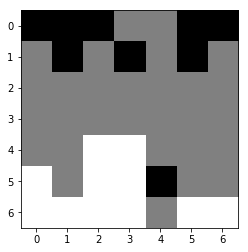

((5, 4), (6, 4)): n_v:   496 q_all:+0.004373 q:+0.025833 q_m:+0.018367 p:0.127457
((5, 4), (5, 5)): n_v:   412 q_all:-0.014538 q:-0.001457 q_m:+0.006612 p:0.136941
((0, 5), (0, 4)): n_v:   285 q_all:-0.009586 q:+0.001547 q_m:-0.000735 p:0.089178
((0, 2), (0, 4)): n_v:    88 q_all:-0.016049 q:-0.002649 q_m:-0.002939 p:0.029901
((0, 6), (0, 4)): n_v:    73 q_all:-0.015481 q:+0.004843 q_m:-0.002939 p:0.024776
((5, 4), (4, 4)): n_v:    61 q_all:-0.006918 q:+0.014213 q_m:+0.006612 p:0.018604
((1, 3), (2, 3)): n_v:    53 q_all:-0.017347 q:-0.002849 q_m:-0.000735 p:0.018451
((0, 2), (0, 3)): n_v:    44 q_all:-0.013316 q:+0.000354 q_m:-0.000735 p:0.014413
((1, 1), (3, 3)): n_v:    40 q_all:-0.011451 q:+0.022350 q_m:+0.002939 p:0.012990
((1, 5), (3, 3)): n_v:    35 q_all:-0.012382 q:+0.027639 q_m:+0.002939 p:0.011535
((5, 4), (3, 2)): n_v:    34 q_all:-0.005343 q:+0.030103 q_m:+0.002939 p:0.010310
((5, 4), (4, 5)): n_v:    30 q_all:-0.016448 q:-0.009101 q_m:-0.000735 p:0.010494
((5, 4), (3, 3))

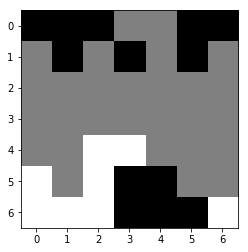

((4, 3), (5, 5)): n_v:   633 q_all:-0.016486 q:+0.006225 q_m:+0.000735 p:0.140310
((6, 6), (5, 5)): n_v:   372 q_all:-0.016192 q:+0.000236 q_m:+0.002939 p:0.082069
((4, 2), (5, 1)): n_v:   312 q_all:-0.028332 q:+0.000786 q_m:-0.011755 p:0.083408
((4, 3), (4, 4)): n_v:   309 q_all:-0.030168 q:+0.031095 q_m:-0.000000 p:0.084519
((4, 3), (5, 1)): n_v:   308 q_all:-0.035907 q:-0.034990 q_m:-0.018367 p:0.091466
((6, 2), (4, 4)): n_v:   114 q_all:-0.031180 q:+0.020529 q_m:-0.000735 p:0.031882
((4, 2), (4, 4)): n_v:   113 q_all:-0.019447 q:-0.010387 q_m:-0.000735 p:0.026461
((5, 2), (4, 4)): n_v:    72 q_all:-0.045130 q:+0.012784 q_m:-0.000735 p:0.023929
((6, 6), (4, 4)): n_v:    61 q_all:-0.032358 q:+0.000166 q_m:-0.000735 p:0.017490
((4, 2), (2, 4)): n_v:    56 q_all:-0.013342 q:+0.011868 q_m:-0.000735 p:0.011824
((4, 3), (2, 4)): n_v:    56 q_all:-0.015148 q:-0.005351 q_m:-0.000735 p:0.012257
((4, 3), (2, 2)): n_v:    54 q_all:-0.019739 q:-0.007547 q_m:-0.000735 p:0.012700
((4, 2), (2, 2))

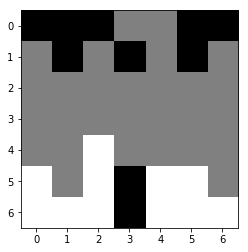

((5, 3), (4, 3)): n_v:   605 q_all:+0.002127 q:+0.008588 q_m:+0.026449 p:0.179478
((1, 3), (2, 3)): n_v:   255 q_all:-0.004162 q:+0.009981 q_m:-0.000000 p:0.081771
((6, 3), (5, 1)): n_v:   240 q_all:+0.027574 q:+0.074989 q_m:+0.088898 p:0.048366
((5, 3), (5, 1)): n_v:   146 q_all:+0.021219 q:+0.064463 q_m:+0.088898 p:0.032972
((0, 2), (0, 3)): n_v:    86 q_all:-0.000660 q:-0.010256 q_m:-0.000000 p:0.026656
((0, 1), (2, 3)): n_v:    86 q_all:-0.009604 q:+0.000415 q_m:-0.000735 p:0.029646
((0, 5), (0, 4)): n_v:    72 q_all:+0.000973 q:+0.006495 q_m:-0.000000 p:0.021883
((1, 1), (2, 3)): n_v:    72 q_all:-0.006512 q:+0.004953 q_m:-0.000735 p:0.023775
((0, 5), (2, 3)): n_v:    69 q_all:-0.008811 q:+0.008851 q_m:-0.000735 p:0.023324
((6, 3), (4, 3)): n_v:    69 q_all:+0.000116 q:-0.001494 q_m:+0.018367 p:0.021197
((1, 5), (2, 3)): n_v:    66 q_all:-0.008557 q:+0.003864 q_m:-0.000735 p:0.022276
((0, 2), (2, 3)): n_v:    50 q_all:-0.008534 q:-0.002663 q_m:-0.000735 p:0.016871
((0, 5), (1, 6))

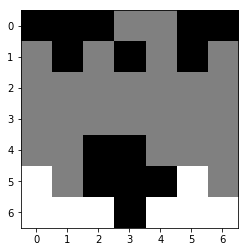

((5, 5), (4, 4)): n_v:   243 q_all:+0.004681 q:+0.036919 q_m:+0.000735 p:0.257770
((6, 2), (4, 4)): n_v:    83 q_all:+0.003289 q:+0.037904 q_m:-0.000000 p:0.088718
((5, 0), (5, 1)): n_v:    71 q_all:-0.006667 q:-0.005399 q_m:-0.000735 p:0.081443
((6, 5), (4, 4)): n_v:    61 q_all:-0.007363 q:+0.001257 q_m:-0.000000 p:0.070353
((6, 6), (4, 4)): n_v:    48 q_all:-0.007316 q:-0.003694 q_m:-0.000000 p:0.056088
((6, 4), (4, 4)): n_v:    27 q_all:-0.011629 q:-0.012765 q_m:-0.000000 p:0.032467
((5, 5), (3, 3)): n_v:    14 q_all:-0.020751 q:-0.001792 q_m:-0.002939 p:0.016819
((5, 0), (4, 1)): n_v:    13 q_all:-0.027393 q:-0.026882 q_m:-0.000735 p:0.017798
((5, 5), (4, 5)): n_v:    10 q_all:-0.025070 q:-0.020048 q_m:-0.006612 p:0.013243
((5, 0), (3, 2)): n_v:     7 q_all:-0.022043 q:-0.032680 q_m:-0.002939 p:0.009057
((5, 5), (3, 4)): n_v:     6 q_all:-0.023782 q:-0.024523 q_m:-0.011755 p:0.008640
((6, 6), (4, 5)): n_v:     5 q_all:-0.025090 q:-0.006060 q_m:-0.011755 p:0.006231
((6, 5), (4, 5))

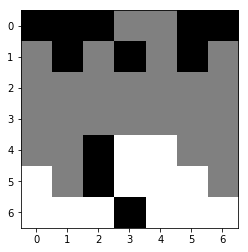

((4, 2), (5, 1)): n_v:   223 q_all:+0.023067 q:+0.064568 q_m:+0.047020 p:0.042401
((4, 2), (3, 3)): n_v:   176 q_all:-0.006417 q:+0.030773 q_m:+0.011755 p:0.054478
((6, 3), (5, 1)): n_v:   110 q_all:+0.003152 q:+0.058856 q_m:+0.036000 p:0.029876
((1, 5), (3, 3)): n_v:    74 q_all:-0.008704 q:+0.023909 q_m:+0.006612 p:0.023711
((1, 1), (3, 3)): n_v:    74 q_all:-0.010040 q:+0.020841 q_m:+0.006612 p:0.023970
((4, 2), (3, 2)): n_v:    65 q_all:-0.023559 q:+0.010504 q_m:+0.002939 p:0.024822
((4, 2), (3, 4)): n_v:    60 q_all:-0.004352 q:-0.001777 q_m:+0.006612 p:0.018280
((0, 2), (0, 3)): n_v:    47 q_all:-0.017410 q:-0.003662 q_m:-0.000000 p:0.016826
((1, 3), (2, 3)): n_v:    47 q_all:-0.021572 q:+0.008275 q_m:-0.000000 p:0.017701
((6, 3), (4, 5)): n_v:    47 q_all:-0.002015 q:+0.017230 q_m:+0.018367 p:0.013945
((0, 5), (0, 4)): n_v:    45 q_all:-0.016865 q:-0.003961 q_m:-0.000000 p:0.015799
((1, 3), (3, 3)): n_v:    44 q_all:-0.009896 q:+0.023066 q_m:+0.006612 p:0.014448
((5, 2), (3, 3))

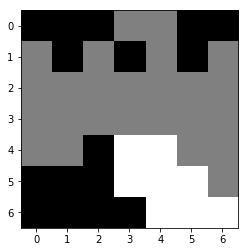

((4, 3), (4, 1)): n_v:   336 q_all:-0.028025 q:+0.015242 q_m:-0.000000 p:0.041071
((4, 4), (4, 5)): n_v:   302 q_all:-0.061892 q:-0.005786 q_m:-0.036000 p:0.078583
((4, 3), (2, 1)): n_v:   197 q_all:-0.067190 q:-0.013432 q_m:-0.026449 p:0.055749
((5, 5), (5, 6)): n_v:   187 q_all:-0.056938 q:+0.023671 q_m:-0.036000 p:0.044953
((4, 3), (3, 3)): n_v:    98 q_all:-0.073126 q:+0.003670 q_m:-0.018367 p:0.030191
((4, 4), (2, 2)): n_v:    89 q_all:-0.056371 q:+0.000670 q_m:-0.011755 p:0.021284
((4, 3), (2, 2)): n_v:    88 q_all:-0.065433 q:-0.006108 q_m:-0.011755 p:0.024291
((4, 4), (5, 6)): n_v:    86 q_all:-0.088091 q:-0.012499 q_m:-0.047020 p:0.031715
((5, 3), (4, 1)): n_v:    80 q_all:-0.099198 q:+0.001644 q_m:-0.000000 p:0.033085
((5, 5), (4, 6)): n_v:    78 q_all:-0.064261 q:+0.004929 q_m:-0.036000 p:0.021136
((4, 3), (4, 5)): n_v:    75 q_all:-0.096778 q:-0.017546 q_m:-0.047020 p:0.030181
((4, 3), (2, 4)): n_v:    64 q_all:-0.063383 q:+0.021529 q_m:-0.011755 p:0.017106
((4, 3), (2, 5))

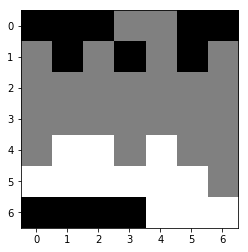

((6, 2), (4, 3)): n_v:   381 q_all:+0.012002 q:+0.057260 q_m:+0.073469 p:0.117799
((1, 3), (2, 3)): n_v:   371 q_all:-0.009192 q:-0.011565 q_m:+0.000735 p:0.146170
((6, 1), (4, 3)): n_v:   355 q_all:+0.018281 q:+0.067302 q_m:+0.073469 p:0.101014
((6, 3), (4, 3)): n_v:   208 q_all:+0.007991 q:+0.036234 q_m:+0.073469 p:0.067611
((0, 1), (2, 3)): n_v:   127 q_all:-0.013906 q:-0.006256 q_m:-0.000000 p:0.052667
((0, 5), (2, 3)): n_v:   112 q_all:-0.013901 q:-0.010445 q_m:-0.000000 p:0.046534
((0, 2), (2, 3)): n_v:    87 q_all:-0.012976 q:-0.021851 q_m:-0.000000 p:0.035858
((1, 1), (2, 3)): n_v:    84 q_all:-0.009110 q:-0.018088 q_m:-0.000000 p:0.033088
((1, 5), (2, 3)): n_v:    77 q_all:-0.010579 q:-0.011870 q_m:-0.000000 p:0.030760
((1, 1), (3, 2)): n_v:    34 q_all:-0.002215 q:+0.011812 q_m:+0.011755 p:0.012705
((0, 2), (0, 3)): n_v:    32 q_all:-0.003921 q:-0.007728 q_m:+0.000735 p:0.012225
((0, 1), (1, 2)): n_v:    26 q_all:-0.007349 q:+0.011828 q_m:+0.000735 p:0.010233
((1, 1), (3, 3))

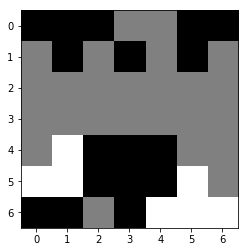

((5, 1), (6, 2)): n_v:  1395 q_all:-0.002588 q:+0.021215 q_m:-0.000735 p:0.464966
((5, 0), (6, 2)): n_v:   581 q_all:-0.017690 q:-0.009267 q_m:-0.002939 p:0.228283
((4, 1), (6, 2)): n_v:   181 q_all:-0.014226 q:-0.015987 q_m:-0.002939 p:0.068598
((6, 4), (6, 2)): n_v:   114 q_all:-0.050991 q:-0.031602 q_m:-0.002939 p:0.060097
((4, 1), (3, 2)): n_v:    81 q_all:-0.067202 q:-0.013046 q_m:-0.018367 p:0.047693
((4, 1), (3, 3)): n_v:    44 q_all:-0.056027 q:-0.029093 q_m:-0.011755 p:0.023964
((5, 5), (3, 3)): n_v:    20 q_all:-0.070061 q:-0.022347 q_m:-0.011755 p:0.012266
((5, 5), (4, 5)): n_v:    19 q_all:-0.038922 q:+0.025815 q_m:-0.018367 p:0.009144
((5, 1), (3, 3)): n_v:    18 q_all:-0.069466 q:-0.009484 q_m:-0.011755 p:0.010918
((5, 0), (3, 2)): n_v:    12 q_all:-0.090028 q:-0.037224 q_m:-0.026449 p:0.008399
((5, 5), (5, 6)): n_v:     9 q_all:-0.094877 q:-0.022433 q_m:-0.059510 p:0.006915
((5, 1), (3, 2)): n_v:     6 q_all:-0.075877 q:-0.031712 q_m:-0.026449 p:0.003985
((5, 5), (3, 4))

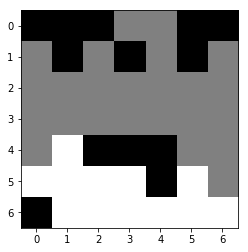

((6, 0), (4, 0)): n_v:   166 q_all:+0.016118 q:+0.028577 q_m:+0.036000 p:0.023148
((4, 4), (5, 6)): n_v:   146 q_all:+0.010369 q:+0.002028 q_m:+0.036000 p:0.023144
((0, 2), (0, 3)): n_v:    99 q_all:-0.003238 q:-0.005803 q_m:+0.002939 p:0.020177
((4, 2), (4, 0)): n_v:    96 q_all:+0.012494 q:+0.023812 q_m:+0.036000 p:0.014540
((0, 5), (1, 6)): n_v:    95 q_all:-0.002178 q:+0.004956 q_m:+0.002939 p:0.019080
((1, 1), (2, 0)): n_v:    88 q_all:-0.007176 q:-0.018701 q_m:+0.002939 p:0.019197
((0, 0), (1, 0)): n_v:    80 q_all:-0.002207 q:-0.011594 q_m:+0.002939 p:0.016167
((0, 1), (1, 2)): n_v:    76 q_all:-0.005591 q:-0.003286 q_m:+0.002939 p:0.016055
((1, 5), (2, 6)): n_v:    72 q_all:-0.004680 q:-0.023359 q_m:+0.002939 p:0.015074
((0, 5), (1, 4)): n_v:    67 q_all:-0.001234 q:+0.021920 q_m:+0.002939 p:0.013252
((4, 4), (4, 5)): n_v:    63 q_all:+0.002802 q:+0.012929 q_m:+0.011755 p:0.011590
((4, 4), (4, 6)): n_v:    63 q_all:-0.007197 q:+0.006893 q_m:+0.006612 p:0.013746
((0, 5), (0, 4))

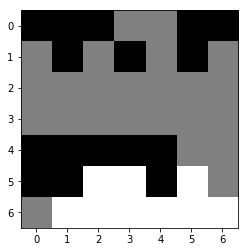

((6, 1), (6, 0)): n_v:   687 q_all:-0.008690 q:-0.000485 q_m:-0.002939 p:0.125171
((5, 5), (5, 6)): n_v:   269 q_all:-0.033516 q:-0.010204 q_m:-0.026449 p:0.076648
((5, 5), (4, 5)): n_v:   171 q_all:-0.010144 q:+0.040361 q_m:-0.002939 p:0.032316
((5, 5), (3, 3)): n_v:   168 q_all:-0.035318 q:+0.066580 q_m:-0.000735 p:0.048980
((5, 5), (3, 4)): n_v:    99 q_all:-0.047129 q:+0.005380 q_m:-0.006612 p:0.033798
((5, 2), (3, 3)): n_v:    86 q_all:-0.077804 q:-0.004414 q_m:-0.000735 p:0.040538
((5, 5), (4, 6)): n_v:    80 q_all:-0.053044 q:-0.003398 q_m:-0.026449 p:0.029232
((6, 3), (4, 5)): n_v:    69 q_all:-0.069188 q:-0.009706 q_m:-0.006612 p:0.029788
((5, 3), (3, 2)): n_v:    64 q_all:-0.102600 q:+0.008455 q_m:-0.000735 p:0.036791
((5, 2), (3, 4)): n_v:    56 q_all:-0.104323 q:-0.001646 q_m:-0.006612 p:0.032608
((6, 2), (6, 0)): n_v:    45 q_all:-0.096631 q:+0.004324 q_m:-0.006612 p:0.024478
((5, 3), (3, 1)): n_v:    40 q_all:-0.085393 q:-0.009404 q_m:-0.000735 p:0.020014
((5, 3), (3, 4))

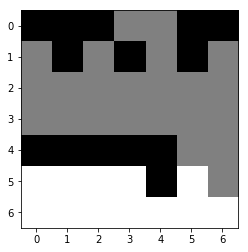

((4, 4), (5, 6)): n_v:   234 q_all:+0.009649 q:+0.019884 q_m:+0.047020 p:0.040674
((0, 2), (0, 3)): n_v:   116 q_all:-0.001266 q:+0.016333 q_m:+0.006612 p:0.025048
((0, 5), (1, 4)): n_v:    97 q_all:-0.000620 q:+0.031815 q_m:+0.006612 p:0.020705
((0, 5), (1, 6)): n_v:    89 q_all:-0.000187 q:+0.028291 q_m:+0.006612 p:0.018819
((0, 5), (0, 4)): n_v:    88 q_all:-0.001729 q:+0.007495 q_m:+0.006612 p:0.019175
((0, 1), (1, 2)): n_v:    87 q_all:-0.003942 q:+0.016252 q_m:+0.006612 p:0.019446
((0, 0), (1, 0)): n_v:    66 q_all:+0.000125 q:+0.004777 q_m:+0.006612 p:0.013917
((1, 3), (2, 3)): n_v:    66 q_all:-0.011663 q:-0.001548 q_m:+0.006612 p:0.016832
((4, 4), (4, 5)): n_v:    64 q_all:+0.001813 q:+0.031404 q_m:+0.018367 p:0.013039
((0, 2), (1, 4)): n_v:    57 q_all:-0.004638 q:+0.020474 q_m:+0.002939 p:0.013115
((5, 4), (5, 6)): n_v:    55 q_all:+0.005665 q:+0.021150 q_m:+0.047020 p:0.010387
((0, 6), (0, 4)): n_v:    51 q_all:-0.006221 q:+0.003751 q_m:+0.002939 p:0.011875
((1, 3), (2, 4))

one move takes time(s):  0.7538621425628662
no. of data collected:  8


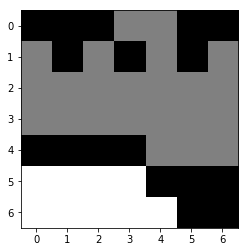

((5, 3), (4, 4)): n_v:  1777 q_all:-0.010620 q:+0.013287 q_m:-0.000735 p:0.639206
((6, 2), (4, 4)): n_v:   150 q_all:-0.067365 q:-0.014984 q_m:-0.002939 p:0.088971
((6, 3), (4, 4)): n_v:   126 q_all:-0.050764 q:-0.005541 q_m:-0.002939 p:0.065928
((5, 2), (4, 4)): n_v:    65 q_all:-0.104725 q:-0.003688 q_m:-0.002939 p:0.048019
((5, 0), (3, 1)): n_v:    53 q_all:-0.011444 q:-0.007391 q_m:-0.002939 p:0.019293
((6, 4), (4, 4)): n_v:    49 q_all:-0.055670 q:-0.000303 q_m:-0.002939 p:0.027058
((6, 3), (4, 5)): n_v:    41 q_all:-0.057884 q:-0.022419 q_m:-0.002939 p:0.022997
((5, 0), (3, 2)): n_v:    23 q_all:-0.039443 q:-0.005774 q_m:-0.002939 p:0.011408
((6, 4), (4, 5)): n_v:    15 q_all:-0.058220 q:+0.002455 q_m:-0.002939 p:0.008687
((5, 1), (3, 2)): n_v:    11 q_all:-0.100276 q:+0.013326 q_m:-0.002939 p:0.008039
((5, 1), (3, 1)): n_v:     7 q_all:-0.155535 q:-0.001861 q_m:-0.002939 p:0.006474
((5, 2), (3, 2)): n_v:     5 q_all:-0.118899 q:-0.022508 q_m:-0.002939 p:0.004528
((6, 4), (4, 6))

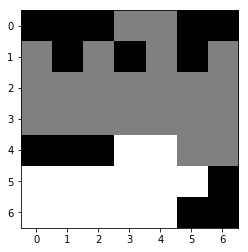

((5, 6), (4, 5)): n_v:   397 q_all:+0.024376 q:+0.048814 q_m:+0.047020 p:0.052060
((4, 2), (3, 3)): n_v:   289 q_all:+0.005889 q:+0.012987 q_m:+0.026449 p:0.054885
((4, 2), (3, 4)): n_v:   153 q_all:+0.004866 q:+0.014340 q_m:+0.018367 p:0.029628
((4, 1), (3, 2)): n_v:   128 q_all:-0.001094 q:+0.000179 q_m:+0.011755 p:0.027081
((4, 1), (3, 3)): n_v:   123 q_all:+0.003940 q:+0.015826 q_m:+0.018367 p:0.024152
((1, 5), (2, 5)): n_v:    96 q_all:-0.002547 q:-0.002068 q_m:+0.002939 p:0.020865
((4, 0), (3, 2)): n_v:    95 q_all:-0.005851 q:-0.006400 q_m:+0.006612 p:0.021716
((6, 6), (4, 5)): n_v:    91 q_all:+0.017297 q:+0.031998 q_m:+0.036000 p:0.014096
((1, 3), (2, 3)): n_v:    77 q_all:-0.006590 q:-0.014176 q_m:+0.002939 p:0.017707
((0, 2), (0, 3)): n_v:    76 q_all:-0.000222 q:+0.000091 q_m:+0.002939 p:0.015985
((1, 5), (3, 3)): n_v:    73 q_all:+0.001670 q:+0.009605 q_m:+0.018367 p:0.014809
((1, 1), (3, 3)): n_v:    70 q_all:+0.000504 q:+0.003097 q_m:+0.018367 p:0.014613
((5, 6), (3, 4))

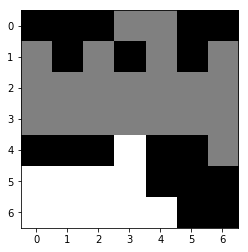

((4, 3), (3, 4)): n_v:   407 q_all:-0.037163 q:+0.014366 q_m:-0.006612 p:0.148050
((5, 0), (3, 1)): n_v:   341 q_all:-0.016341 q:+0.001668 q_m:-0.002939 p:0.096198
((6, 4), (4, 6)): n_v:   268 q_all:-0.042234 q:-0.005534 q_m:-0.002939 p:0.102870
((4, 3), (3, 2)): n_v:   245 q_all:-0.049719 q:-0.009284 q_m:-0.006612 p:0.101154
((4, 3), (3, 3)): n_v:   199 q_all:-0.050872 q:-0.011662 q_m:-0.006612 p:0.083222
((5, 1), (3, 1)): n_v:   130 q_all:-0.018612 q:+0.005965 q_m:-0.002939 p:0.037826
((4, 3), (3, 1)): n_v:   126 q_all:-0.019019 q:-0.002918 q_m:-0.002939 p:0.036892
((4, 3), (3, 5)): n_v:   120 q_all:-0.040246 q:-0.004581 q_m:-0.011755 p:0.045190
((4, 3), (2, 2)): n_v:    84 q_all:-0.045838 q:-0.001345 q_m:-0.011755 p:0.033760
((4, 3), (2, 4)): n_v:    75 q_all:-0.049577 q:+0.016647 q_m:-0.011755 p:0.031022
((5, 3), (3, 1)): n_v:    47 q_all:-0.116443 q:-0.022670 q_m:-0.002939 p:0.031958
((5, 3), (3, 5)): n_v:    44 q_all:-0.147331 q:-0.013278 q_m:-0.011755 p:0.035079
((5, 0), (3, 2))

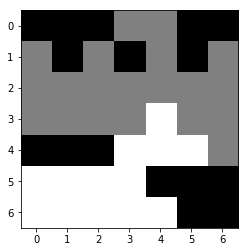

((4, 2), (3, 3)): n_v:   528 q_all:+0.017330 q:+0.043682 q_m:+0.073469 p:0.139864
((4, 0), (3, 1)): n_v:   154 q_all:-0.000588 q:+0.001212 q_m:+0.011755 p:0.051786
((4, 1), (3, 3)): n_v:   121 q_all:+0.016732 q:+0.051600 q_m:+0.059510 p:0.032519
((5, 5), (3, 3)): n_v:   114 q_all:+0.010281 q:+0.041469 q_m:+0.059510 p:0.033363
((1, 5), (3, 3)): n_v:   109 q_all:+0.013612 q:+0.040088 q_m:+0.059510 p:0.030503
((5, 6), (3, 5)): n_v:   109 q_all:+0.011454 q:+0.039184 q_m:+0.059510 p:0.031565
((1, 1), (3, 3)): n_v:   101 q_all:+0.011066 q:+0.028588 q_m:+0.059510 p:0.029306
((5, 4), (3, 3)): n_v:    85 q_all:+0.008859 q:+0.029018 q_m:+0.059510 p:0.025490
((1, 3), (3, 3)): n_v:    78 q_all:+0.011961 q:+0.057273 q_m:+0.059510 p:0.022557
((1, 3), (3, 5)): n_v:    74 q_all:+0.011732 q:+0.021749 q_m:+0.059510 p:0.021192
((4, 1), (3, 2)): n_v:    62 q_all:+0.003641 q:+0.008064 q_m:+0.026449 p:0.020049
((4, 0), (3, 2)): n_v:    48 q_all:-0.000428 q:-0.004315 q_m:+0.018367 p:0.016127
((0, 5), (1, 4))

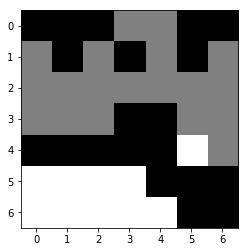

((4, 5), (3, 5)): n_v:   764 q_all:-0.031571 q:-0.016557 q_m:-0.018367 p:0.255159
((5, 0), (3, 2)): n_v:   763 q_all:-0.026440 q:+0.012832 q_m:-0.002939 p:0.239741
((5, 0), (3, 1)): n_v:   364 q_all:-0.026651 q:-0.003810 q_m:-0.011755 p:0.114589
((5, 1), (3, 2)): n_v:   302 q_all:-0.075966 q:-0.000798 q_m:-0.002939 p:0.152522
((4, 5), (2, 4)): n_v:   136 q_all:-0.040217 q:+0.022484 q_m:-0.002939 p:0.049928
((4, 5), (2, 3)): n_v:    77 q_all:-0.065502 q:+0.003492 q_m:-0.011755 p:0.035721
((5, 3), (3, 2)): n_v:    60 q_all:-0.108669 q:-0.031356 q_m:-0.002939 p:0.037966
((5, 2), (3, 2)): n_v:    39 q_all:-0.124076 q:-0.043007 q_m:-0.002939 p:0.027145
((4, 5), (4, 6)): n_v:    28 q_all:-0.034699 q:+0.004394 q_m:-0.018367 p:0.009651
((5, 1), (3, 1)): n_v:    23 q_all:-0.161296 q:-0.004082 q_m:-0.011755 p:0.018853
((5, 3), (3, 1)): n_v:    22 q_all:-0.104344 q:-0.033598 q_m:-0.011755 p:0.014079
((5, 3), (3, 5)): n_v:    21 q_all:-0.130756 q:-0.027150 q_m:-0.026449 p:0.015520
((4, 5), (3, 6))

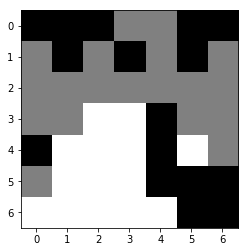

((4, 0), (3, 1)): n_v:   567 q_all:+0.019640 q:+0.039709 q_m:+0.059510 p:0.118038
((4, 0), (5, 0)): n_v:   300 q_all:+0.034774 q:+0.055249 q_m:+0.088898 p:0.045728
((3, 4), (3, 5)): n_v:   152 q_all:-0.001202 q:+0.022726 q_m:+0.018367 p:0.043245
((1, 3), (3, 1)): n_v:   120 q_all:+0.017809 q:+0.041497 q_m:+0.047020 p:0.025791
((1, 3), (2, 3)): n_v:    88 q_all:-0.000810 q:+0.027247 q_m:+0.036000 p:0.025133
((0, 2), (1, 0)): n_v:    87 q_all:-0.010353 q:-0.011296 q_m:+0.002939 p:0.027769
((5, 6), (3, 5)): n_v:    81 q_all:-0.007459 q:+0.026284 q_m:+0.011755 p:0.024850
((1, 1), (3, 1)): n_v:    77 q_all:+0.015697 q:+0.038437 q_m:+0.047020 p:0.017252
((3, 4), (1, 6)): n_v:    72 q_all:-0.008674 q:+0.002767 q_m:+0.002939 p:0.022660
((0, 0), (1, 0)): n_v:    59 q_all:-0.006106 q:-0.000786 q_m:+0.006612 p:0.018070
((0, 2), (2, 3)): n_v:    58 q_all:-0.006853 q:+0.008825 q_m:+0.026449 p:0.017836
((3, 4), (1, 2)): n_v:    51 q_all:-0.009131 q:-0.029540 q_m:+0.002939 p:0.016038
((4, 4), (2, 2))

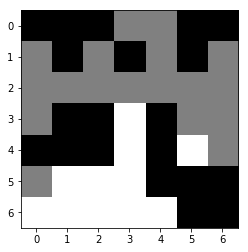

((5, 1), (5, 0)): n_v:   797 q_all:-0.022332 q:-0.006391 q_m:-0.011755 p:0.122356
((3, 3), (2, 2)): n_v:   361 q_all:-0.037891 q:-0.011180 q_m:-0.000000 p:0.076906
((3, 3), (1, 2)): n_v:   348 q_all:-0.016686 q:-0.036046 q_m:-0.000735 p:0.045835
((3, 3), (2, 3)): n_v:   321 q_all:-0.061077 q:-0.007083 q_m:-0.002939 p:0.096684
((3, 3), (2, 4)): n_v:   178 q_all:-0.054517 q:-0.011230 q_m:-0.002939 p:0.049243
((4, 5), (4, 6)): n_v:   115 q_all:-0.038312 q:-0.026749 q_m:-0.011755 p:0.024717
((3, 3), (1, 4)): n_v:    98 q_all:-0.042903 q:-0.025803 q_m:-0.006612 p:0.022686
((4, 5), (3, 5)): n_v:    74 q_all:-0.043760 q:-0.042965 q_m:-0.011755 p:0.017578
((6, 2), (5, 0)): n_v:    57 q_all:-0.092950 q:-0.015811 q_m:-0.018367 p:0.024439
((4, 3), (2, 2)): n_v:    44 q_all:-0.053016 q:-0.007996 q_m:-0.000735 p:0.011893
((3, 3), (2, 1)): n_v:    43 q_all:-0.038882 q:-0.010991 q_m:-0.006612 p:0.009353
((4, 5), (3, 6)): n_v:    33 q_all:-0.091923 q:-0.052024 q_m:-0.047020 p:0.014029
((4, 3), (2, 4))

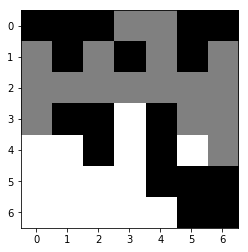

((3, 1), (3, 0)): n_v:   295 q_all:+0.017214 q:+0.045612 q_m:+0.059510 p:0.055557
((3, 2), (1, 0)): n_v:   153 q_all:-0.001422 q:+0.000980 q_m:+0.011755 p:0.039515
((3, 4), (1, 6)): n_v:   105 q_all:-0.003675 q:+0.003630 q_m:+0.011755 p:0.027994
((1, 1), (3, 0)): n_v:    69 q_all:+0.013186 q:+0.044735 q_m:+0.047020 p:0.014187
((4, 2), (3, 0)): n_v:    69 q_all:+0.010236 q:+0.049132 q_m:+0.047020 p:0.014731
((3, 4), (3, 5)): n_v:    68 q_all:+0.008397 q:+0.044675 q_m:+0.036000 p:0.015058
((0, 5), (1, 6)): n_v:    59 q_all:-0.000227 q:+0.031724 q_m:+0.018367 p:0.014897
((5, 4), (3, 6)): n_v:    58 q_all:-0.001613 q:-0.012137 q_m:+0.026449 p:0.015175
((1, 1), (2, 1)): n_v:    56 q_all:-0.005926 q:+0.009696 q_m:+0.018367 p:0.015400
((0, 2), (1, 0)): n_v:    53 q_all:-0.007709 q:+0.004023 q_m:+0.011755 p:0.014982
((5, 6), (3, 6)): n_v:    51 q_all:+0.004195 q:+0.012924 q_m:+0.026449 p:0.012251
((3, 1), (1, 0)): n_v:    51 q_all:-0.003497 q:+0.002347 q_m:+0.011755 p:0.013723
((0, 0), (1, 0))

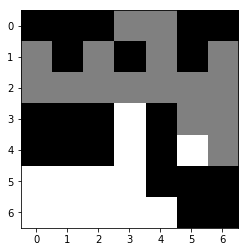

((3, 3), (2, 2)): n_v:   485 q_all:-0.038214 q:-0.008227 q_m:-0.000000 p:0.186547
((3, 3), (1, 2)): n_v:   373 q_all:-0.010920 q:+0.001448 q_m:-0.000735 p:0.102610
((3, 3), (2, 4)): n_v:   326 q_all:-0.057000 q:+0.010103 q_m:-0.002939 p:0.149709
((3, 3), (2, 3)): n_v:   325 q_all:-0.069594 q:-0.007500 q_m:-0.002939 p:0.165742
((3, 3), (1, 4)): n_v:   177 q_all:-0.037048 q:+0.017877 q_m:-0.006612 p:0.067485
((4, 5), (4, 6)): n_v:   146 q_all:-0.024871 q:-0.006336 q_m:-0.011755 p:0.048494
((4, 5), (3, 5)): n_v:   135 q_all:-0.038402 q:-0.019756 q_m:-0.011755 p:0.052094
((3, 3), (2, 1)): n_v:    84 q_all:-0.020733 q:+0.001241 q_m:-0.000735 p:0.026615
((4, 3), (2, 2)): n_v:    57 q_all:-0.058161 q:-0.004344 q_m:-0.000735 p:0.026848
((4, 3), (2, 1)): n_v:    55 q_all:-0.046809 q:-0.012864 q_m:-0.000735 p:0.023256
((6, 4), (4, 6)): n_v:    39 q_all:-0.072282 q:-0.021395 q_m:-0.018367 p:0.020495
((3, 3), (2, 5)): n_v:    32 q_all:-0.063247 q:+0.017237 q_m:-0.018367 p:0.015643
((4, 5), (2, 4))

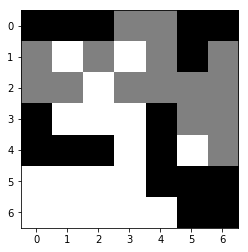

((3, 4), (2, 3)): n_v:   959 q_all:+0.009193 q:+0.031092 q_m:+0.059510 p:0.295927
((0, 1), (2, 3)): n_v:   204 q_all:+0.006412 q:+0.012400 q_m:+0.047020 p:0.065333
((0, 5), (2, 3)): n_v:   197 q_all:+0.007003 q:+0.038825 q_m:+0.047020 p:0.062781
((0, 1), (1, 2)): n_v:   170 q_all:+0.003560 q:+0.053267 q_m:+0.036000 p:0.056143
((1, 5), (2, 3)): n_v:   158 q_all:+0.006711 q:+0.029479 q_m:+0.047020 p:0.050313
((0, 2), (2, 3)): n_v:   144 q_all:+0.007790 q:+0.033086 q_m:+0.047020 p:0.045358
((3, 0), (2, 1)): n_v:   104 q_all:+0.010221 q:+0.020934 q_m:+0.059510 p:0.031808
((0, 5), (1, 4)): n_v:    87 q_all:-0.011613 q:+0.014768 q_m:+0.006612 p:0.034148
((3, 4), (1, 2)): n_v:    68 q_all:+0.005229 q:+0.019719 q_m:+0.026449 p:0.022289
((3, 0), (1, 2)): n_v:    63 q_all:-0.003102 q:+0.020353 q_m:+0.026449 p:0.022427
((4, 1), (2, 3)): n_v:    51 q_all:+0.007410 q:+0.011553 q_m:+0.047020 p:0.016350
((4, 2), (2, 3)): n_v:    51 q_all:+0.010915 q:+0.007979 q_m:+0.047020 p:0.015590
((0, 0), (1, 2))

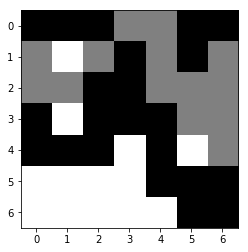

((1, 1), (1, 2)): n_v:  2276 q_all:-0.009517 q:+0.000481 q_m:+0.002939 p:0.680188
((4, 5), (3, 5)): n_v:   169 q_all:-0.037914 q:-0.048505 q_m:-0.011755 p:0.067829
((4, 5), (2, 4)): n_v:   164 q_all:-0.019754 q:+0.012820 q_m:+0.000735 p:0.055200
((1, 1), (2, 1)): n_v:   114 q_all:-0.035966 q:-0.040876 q_m:-0.002939 p:0.045108
((3, 1), (1, 2)): n_v:   113 q_all:-0.008362 q:+0.002891 q_m:+0.000735 p:0.033393
((4, 3), (2, 4)): n_v:    88 q_all:-0.021280 q:+0.049455 q_m:+0.000735 p:0.030028
((1, 1), (1, 0)): n_v:    13 q_all:-0.050552 q:-0.013524 q_m:-0.011755 p:0.006179
((1, 1), (0, 3)): n_v:    12 q_all:-0.057123 q:-0.006907 q_m:-0.018367 p:0.005811
((4, 3), (2, 1)): n_v:    10 q_all:-0.047065 q:-0.050348 q_m:-0.006612 p:0.004683
((4, 5), (2, 5)): n_v:     8 q_all:-0.054676 q:-0.019482 q_m:-0.018367 p:0.004078
((4, 3), (2, 5)): n_v:     6 q_all:-0.059130 q:-0.013515 q_m:-0.018367 p:0.002789
((5, 3), (3, 5)): n_v:     5 q_all:-0.120282 q:-0.083815 q_m:-0.018367 p:0.003677
((1, 1), (2, 0))

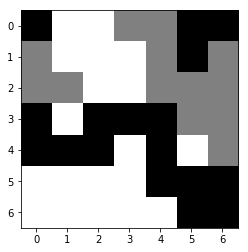

((3, 0), (2, 1)): n_v:   918 q_all:+0.012456 q:+0.016674 q_m:+0.036000 p:0.108318
((1, 5), (2, 4)): n_v:   489 q_all:-0.002881 q:+0.013288 q_m:+0.006612 p:0.080161
((0, 5), (1, 4)): n_v:   447 q_all:-0.015924 q:+0.028394 q_m:+0.006612 p:0.090737
((0, 0), (2, 1)): n_v:   264 q_all:+0.008035 q:+0.014579 q_m:+0.026449 p:0.034726
((0, 5), (0, 3)): n_v:   167 q_all:+0.000848 q:+0.039438 q_m:+0.011755 p:0.025481
((0, 6), (1, 4)): n_v:   160 q_all:-0.022598 q:+0.019574 q_m:+0.002939 p:0.035497
((0, 5), (2, 4)): n_v:   148 q_all:-0.004101 q:+0.017238 q_m:+0.002939 p:0.024802
((4, 0), (2, 1)): n_v:   121 q_all:+0.005774 q:+0.012330 q_m:+0.026449 p:0.016769
((1, 5), (0, 3)): n_v:   120 q_all:+0.004356 q:+0.029415 q_m:+0.011755 p:0.017154
((0, 6), (2, 4)): n_v:   117 q_all:-0.007513 q:+0.005215 q_m:+0.002939 p:0.020931
((0, 5), (0, 4)): n_v:   105 q_all:-0.016276 q:+0.020797 q_m:+0.000735 p:0.021591
((4, 2), (2, 4)): n_v:    90 q_all:-0.011996 q:-0.043217 q_m:+0.002939 p:0.017215
((1, 5), (2, 5))

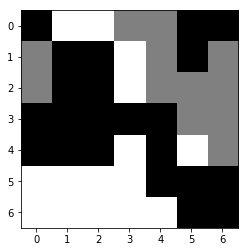

((4, 5), (3, 5)): n_v:   546 q_all:-0.048538 q:-0.001179 q_m:-0.002939 p:0.189940
((1, 3), (2, 4)): n_v:   535 q_all:-0.038160 q:+0.013564 q_m:-0.000000 p:0.166215
((0, 1), (1, 0)): n_v:   436 q_all:-0.010073 q:+0.003701 q_m:-0.000000 p:0.091528
((0, 1), (2, 0)): n_v:   229 q_all:-0.005422 q:+0.022712 q_m:+0.000735 p:0.044237
((4, 5), (4, 6)): n_v:   171 q_all:-0.023686 q:+0.007443 q_m:-0.002939 p:0.044334
((0, 2), (2, 0)): n_v:   168 q_all:-0.013580 q:-0.005364 q_m:+0.000735 p:0.037419
((1, 3), (1, 4)): n_v:   108 q_all:-0.054636 q:+0.004045 q_m:-0.002939 p:0.040071
((0, 2), (1, 0)): n_v:    56 q_all:-0.019188 q:+0.005933 q_m:-0.000735 p:0.013625
((0, 2), (2, 4)): n_v:    51 q_all:-0.042663 q:+0.005244 q_m:-0.000735 p:0.016738
((0, 2), (0, 3)): n_v:    50 q_all:-0.046442 q:+0.011961 q_m:-0.011755 p:0.017312
((4, 5), (3, 6)): n_v:    49 q_all:-0.057697 q:+0.013702 q_m:-0.026449 p:0.018733
((4, 5), (2, 4)): n_v:    47 q_all:-0.048245 q:+0.007484 q_m:-0.000735 p:0.016305
((2, 3), (3, 5))

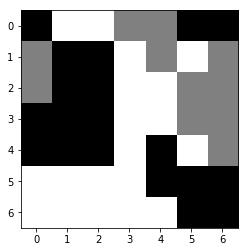

((0, 5), (1, 4)): n_v:  1300 q_all:+0.013609 q:+0.061820 q_m:+0.059510 p:0.460737
((0, 6), (1, 4)): n_v:   647 q_all:+0.009055 q:+0.052219 q_m:+0.047020 p:0.240759
((2, 2), (1, 4)): n_v:   108 q_all:-0.016649 q:+0.054035 q_m:+0.047020 p:0.050885
((1, 2), (0, 3)): n_v:   103 q_all:-0.000168 q:+0.035391 q_m:+0.018367 p:0.042296
((1, 2), (1, 4)): n_v:    90 q_all:+0.007091 q:+0.045703 q_m:+0.047020 p:0.034387
((3, 2), (1, 4)): n_v:    89 q_all:-0.011887 q:-0.002482 q_m:+0.047020 p:0.040247
((0, 5), (0, 4)): n_v:    51 q_all:+0.001516 q:+0.034898 q_m:+0.018367 p:0.020748
((0, 6), (0, 4)): n_v:    39 q_all:-0.002176 q:+0.036695 q_m:+0.011755 p:0.016205
((4, 4), (3, 5)): n_v:    37 q_all:+0.007198 q:+0.035152 q_m:+0.036000 p:0.014168
((5, 6), (3, 5)): n_v:    27 q_all:+0.001079 q:+0.038303 q_m:+0.026449 p:0.011122
((0, 5), (0, 3)): n_v:    27 q_all:+0.001370 q:+0.008793 q_m:+0.011755 p:0.011124
((2, 2), (0, 4)): n_v:    15 q_all:-0.042923 q:+0.033258 q_m:+0.011755 p:0.008730
((1, 2), (0, 4))

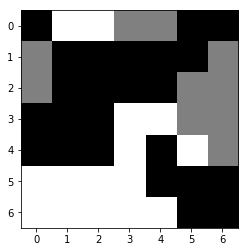

((0, 2), (0, 3)): n_v:  2047 q_all:-0.035017 q:-0.002127 q_m:-0.002939 p:0.587446
((3, 4), (2, 5)): n_v:   236 q_all:-0.047986 q:+0.006499 q_m:-0.002939 p:0.078202
((0, 1), (0, 3)): n_v:   225 q_all:-0.044300 q:-0.025696 q_m:-0.006612 p:0.071801
((0, 1), (1, 0)): n_v:   186 q_all:-0.025700 q:-0.026898 q_m:-0.002939 p:0.047681
((0, 2), (0, 4)): n_v:   168 q_all:-0.025138 q:+0.027114 q_m:-0.000735 p:0.042610
((0, 1), (2, 0)): n_v:   111 q_all:-0.018306 q:-0.044312 q_m:-0.000735 p:0.025817
((3, 4), (3, 5)): n_v:    97 q_all:-0.055614 q:-0.024353 q_m:-0.011755 p:0.034812
((4, 5), (4, 6)): n_v:    67 q_all:-0.052625 q:-0.013408 q_m:-0.011755 p:0.023330
((0, 2), (2, 0)): n_v:    53 q_all:-0.024301 q:-0.095502 q_m:-0.000735 p:0.013463
((4, 5), (2, 5)): n_v:    29 q_all:-0.034620 q:+0.004228 q_m:-0.006612 p:0.008219
((6, 4), (4, 6)): n_v:    11 q_all:-0.075840 q:-0.136476 q_m:-0.018367 p:0.004947
((0, 2), (1, 0)): n_v:    10 q_all:-0.032861 q:-0.030392 q_m:-0.006612 p:0.002912
((4, 3), (2, 5))

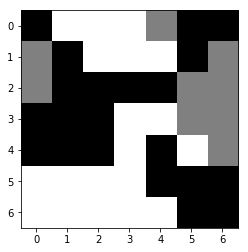

((0, 5), (0, 4)): n_v:  2169 q_all:+0.026456 q:+0.045223 q_m:+0.059510 p:0.256451
((0, 6), (0, 4)): n_v:  1091 q_all:+0.020175 q:+0.039457 q_m:+0.047020 p:0.149950
((2, 2), (0, 4)): n_v:   166 q_all:+0.007922 q:+0.030823 q_m:+0.047020 p:0.029136
((2, 3), (0, 4)): n_v:    62 q_all:+0.009473 q:-0.001980 q_m:+0.047020 p:0.010668
((2, 4), (0, 4)): n_v:    45 q_all:+0.013020 q:+0.021380 q_m:+0.047020 p:0.007175
((1, 5), (2, 5)): n_v:    10 q_all:+0.013354 q:+0.051329 q_m:+0.036000 p:0.001627
((0, 6), (2, 5)): n_v:     7 q_all:+0.006452 q:+0.029203 q_m:+0.026449 p:0.001242
((2, 4), (3, 5)): n_v:     3 q_all:+0.015383 q:+0.023186 q_m:+0.036000 p:0.000456
((0, 0), (1, 0)): n_v:     3 q_all:+0.006661 q:+0.002299 q_m:+0.018367 p:0.000560
((3, 0), (1, 0)): n_v:     2 q_all:-0.002194 q:-0.008228 q_m:+0.011755 p:0.000427
((5, 6), (3, 5)): n_v:     2 q_all:+0.000755 q:+0.014034 q_m:+0.026449 p:0.000380
((0, 5), (2, 5)): n_v:     2 q_all:+0.000111 q:+0.037564 q_m:+0.026449 p:0.000404
((1, 5), (3, 5))

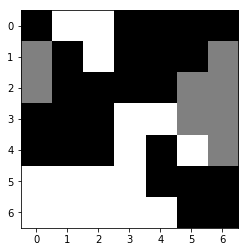

((3, 4), (2, 5)): n_v:   822 q_all:-0.046527 q:-0.009699 q_m:-0.002939 p:0.224341
((0, 1), (1, 0)): n_v:   799 q_all:-0.024923 q:-0.028387 q_m:-0.002939 p:0.166150
((0, 1), (2, 0)): n_v:   444 q_all:-0.014282 q:+0.031325 q_m:-0.000735 p:0.078001
((3, 4), (3, 5)): n_v:   364 q_all:-0.055192 q:-0.055991 q_m:-0.011755 p:0.109097
((4, 5), (4, 6)): n_v:   300 q_all:-0.043841 q:+0.021793 q_m:-0.011755 p:0.079671
((0, 2), (2, 0)): n_v:   256 q_all:-0.027529 q:+0.015051 q_m:-0.000735 p:0.055322
((4, 5), (2, 5)): n_v:   127 q_all:-0.031641 q:-0.013133 q_m:-0.006612 p:0.029125
((6, 4), (4, 6)): n_v:    72 q_all:-0.070965 q:-0.072166 q_m:-0.018367 p:0.025193
((3, 3), (2, 5)): n_v:    59 q_all:-0.044323 q:-0.005385 q_m:-0.006612 p:0.015939
((4, 3), (2, 5)): n_v:    56 q_all:-0.056464 q:-0.027592 q_m:-0.006612 p:0.016991
((3, 4), (2, 6)): n_v:    38 q_all:-0.083811 q:-0.064910 q_m:-0.036000 p:0.014713
((3, 4), (1, 6)): n_v:    36 q_all:-0.038879 q:-0.011325 q_m:-0.006612 p:0.009138
((0, 2), (1, 0))

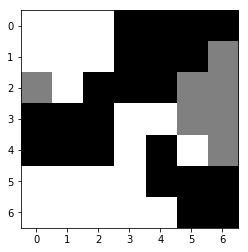

((3, 0), (2, 0)): n_v:   574 q_all:+0.024732 q:+0.049609 q_m:+0.059510 p:0.094244
((2, 4), (3, 5)): n_v:   361 q_all:+0.010867 q:+0.071718 q_m:+0.036000 p:0.077528
((4, 0), (2, 0)): n_v:   203 q_all:+0.018600 q:+0.055121 q_m:+0.047020 p:0.037994
((5, 6), (3, 5)): n_v:   173 q_all:-0.000920 q:+0.037440 q_m:+0.026449 p:0.044826
((0, 6), (2, 6)): n_v:   144 q_all:-0.024285 q:+0.009848 q_m:+0.002939 p:0.049598
((1, 4), (2, 5)): n_v:   119 q_all:-0.013672 q:+0.067954 q_m:+0.018367 p:0.036338
((4, 2), (2, 0)): n_v:    89 q_all:+0.012189 q:+0.000752 q_m:+0.047020 p:0.018768
((0, 3), (2, 5)): n_v:    79 q_all:-0.011706 q:+0.069436 q_m:+0.011755 p:0.023485
((6, 6), (4, 6)): n_v:    79 q_all:-0.002550 q:+0.025684 q_m:+0.011755 p:0.021018
((1, 5), (2, 6)): n_v:    79 q_all:-0.019292 q:+0.013656 q_m:+0.006612 p:0.025906
((0, 6), (2, 5)): n_v:    73 q_all:-0.016020 q:+0.053287 q_m:+0.011755 p:0.023157
((1, 5), (3, 5)): n_v:    71 q_all:+0.014776 q:+0.054211 q_m:+0.026449 p:0.014252
((5, 5), (4, 6))

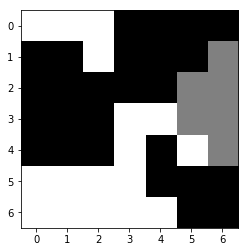

((3, 4), (2, 5)): n_v:   961 q_all:-0.069183 q:-0.045881 q_m:-0.002939 p:0.291135
((3, 4), (3, 5)): n_v:   480 q_all:-0.073717 q:-0.067744 q_m:-0.011755 p:0.153993
((4, 5), (2, 5)): n_v:   242 q_all:-0.040115 q:-0.011887 q_m:-0.006612 p:0.046758
((4, 5), (4, 6)): n_v:   241 q_all:-0.065523 q:+0.072891 q_m:-0.011755 p:0.069585
((4, 3), (2, 5)): n_v:   183 q_all:-0.084017 q:-0.038559 q_m:-0.006612 p:0.066087
((3, 3), (2, 5)): n_v:   164 q_all:-0.064943 q:-0.033285 q_m:-0.006612 p:0.047107
((3, 4), (1, 6)): n_v:   121 q_all:-0.060079 q:-0.043103 q_m:-0.006612 p:0.032437
((4, 5), (3, 6)): n_v:    66 q_all:-0.125276 q:-0.172855 q_m:-0.047020 p:0.034348
((6, 4), (4, 6)): n_v:    58 q_all:-0.116036 q:-0.221858 q_m:-0.018367 p:0.028073
((3, 4), (4, 6)): n_v:    41 q_all:-0.089675 q:-0.025917 q_m:-0.018367 p:0.015684
((4, 3), (3, 5)): n_v:    38 q_all:-0.125102 q:-0.044773 q_m:-0.018367 p:0.019578
((3, 4), (2, 6)): n_v:    24 q_all:-0.115165 q:-0.131523 q_m:-0.036000 p:0.011567
((5, 3), (3, 5))

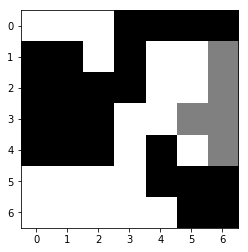

((4, 4), (3, 5)): n_v:  2016 q_all:+0.051157 q:+0.093002 q_m:+0.088898 p:0.586123
((5, 6), (3, 5)): n_v:   463 q_all:+0.032126 q:+0.097422 q_m:+0.073469 p:0.166016
((5, 5), (3, 5)): n_v:   177 q_all:+0.018712 q:+0.056023 q_m:+0.073469 p:0.072239
((1, 3), (3, 5)): n_v:    59 q_all:+0.030930 q:+0.105576 q_m:+0.073469 p:0.021505
((5, 4), (3, 5)): n_v:    57 q_all:+0.015867 q:+0.046100 q_m:+0.073469 p:0.023809
((2, 3), (3, 5)): n_v:    38 q_all:+0.019643 q:+0.048769 q_m:+0.073469 p:0.015419
((0, 5), (1, 6)): n_v:    34 q_all:+0.003397 q:+0.061448 q_m:+0.036000 p:0.015993
((0, 6), (2, 6)): n_v:    31 q_all:-0.000491 q:+0.040381 q_m:+0.026449 p:0.014856
((5, 5), (4, 6)): n_v:    30 q_all:-0.021241 q:+0.021768 q_m:+0.018367 p:0.016499
((6, 6), (4, 6)): n_v:    21 q_all:-0.023535 q:+0.015433 q_m:+0.011755 p:0.012223
((0, 4), (1, 6)): n_v:    20 q_all:+0.015874 q:-0.001681 q_m:+0.026449 p:0.008364
((0, 5), (2, 6)): n_v:    13 q_all:-0.005398 q:+0.026803 q_m:+0.026449 p:0.006773
((6, 5), (4, 6))

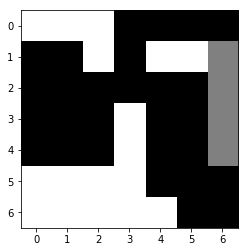

((1, 5), (2, 6)): n_v:  1694 q_all:-0.100061 q:-0.139331 q_m:-0.026449 p:0.533409
((6, 4), (4, 6)): n_v:   733 q_all:-0.068222 q:-0.102366 q_m:-0.006612 p:0.159083
((1, 5), (1, 6)): n_v:   726 q_all:-0.076359 q:-0.023087 q_m:-0.011755 p:0.175787
((1, 5), (3, 6)): n_v:   236 q_all:-0.072217 q:-0.048044 q_m:-0.018367 p:0.054131
((1, 4), (3, 6)): n_v:   186 q_all:-0.068473 q:-0.044865 q_m:-0.018367 p:0.040596
((1, 4), (2, 6)): n_v:   117 q_all:-0.082083 q:-0.028126 q_m:-0.036000 p:0.030540
((1, 4), (1, 6)): n_v:    22 q_all:-0.078603 q:+0.002743 q_m:-0.018367 p:0.005483
-1 's turn
one move takes time(s):  0.12550735473632812
no. of data collected:  8


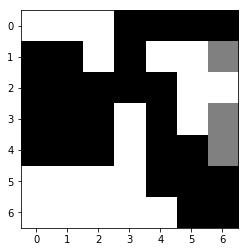

((0, 5), (1, 6)): n_v:  1314 q_all:+0.096395 q:+0.252320 q_m:+0.124163 p:0.226701
((4, 5), (3, 6)): n_v:  1054 q_all:+0.074210 q:+0.163225 q_m:+0.124163 p:0.256980
((0, 4), (1, 6)): n_v:   275 q_all:+0.067747 q:+0.114140 q_m:+0.105796 p:0.072818
((5, 6), (3, 6)): n_v:   121 q_all:+0.057075 q:+0.164324 q_m:+0.105796 p:0.036162
((4, 5), (4, 6)): n_v:   104 q_all:+0.037847 q:+0.204351 q_m:+0.059510 p:0.037593
((3, 4), (1, 6)): n_v:    96 q_all:+0.048188 q:+0.185405 q_m:+0.105796 p:0.031586
((5, 5), (3, 6)): n_v:    42 q_all:+0.050954 q:+0.167894 q_m:+0.105796 p:0.013474
((6, 6), (4, 6)): n_v:    37 q_all:+0.026746 q:+0.135789 q_m:+0.047020 p:0.014798
((5, 4), (3, 6)): n_v:    29 q_all:+0.035203 q:+0.056519 q_m:+0.105796 p:0.010774
((2, 4), (1, 6)): n_v:    24 q_all:+0.032363 q:+0.069548 q_m:+0.105796 p:0.009355
((4, 4), (3, 6)): n_v:    20 q_all:+0.036707 q:+0.087433 q_m:+0.105796 p:0.007275
((2, 4), (3, 6)): n_v:    19 q_all:+0.041507 q:+0.096247 q_m:+0.105796 p:0.006951
((6, 5), (4, 6))

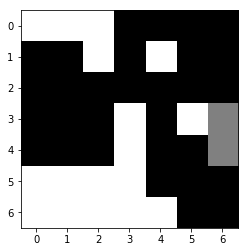

((1, 4), (3, 6)): n_v:  1117 q_all:-0.145005 q:-0.039812 q_m:-0.036000 p:0.057712
((6, 4), (4, 6)): n_v:   974 q_all:-0.198346 q:-0.446721 q_m:-0.036000 p:0.225247
((3, 5), (4, 6)): n_v:   556 q_all:-0.266494 q:+0.064381 q_m:-0.026449 p:0.255969
((3, 5), (3, 6)): n_v:   517 q_all:-0.393731 q:-0.463068 q_m:-0.026449 p:0.460113
-1 's turn
one move takes time(s):  0.09969019889831543
no. of data collected:  8


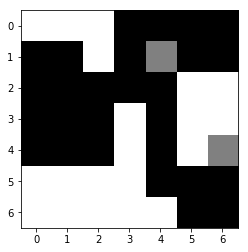

((0, 3), (1, 4)): n_v:  1558 q_all:+0.102620 q:+0.202980 q_m:+0.073469 p:0.072965
((0, 6), (1, 4)): n_v:   786 q_all:+0.062234 q:+0.134209 q_m:+0.059510 p:0.147162
((5, 5), (4, 6)): n_v:   686 q_all:+0.100812 q:+0.326655 q_m:+0.144000 p:0.035868
((1, 6), (1, 4)): n_v:    90 q_all:+0.048763 q:+0.139598 q_m:+0.059510 p:0.021213
((6, 6), (4, 6)): n_v:    80 q_all:+0.082807 q:+0.272436 q_m:+0.124163 p:0.009209
((6, 5), (4, 6)): n_v:    27 q_all:+0.065201 q:+0.173720 q_m:+0.124163 p:0.004879
((2, 2), (1, 4)): n_v:     9 q_all:+0.021929 q:+0.115266 q_m:+0.059510 p:0.003014
((3, 4), (4, 6)): n_v:     3 q_all:+0.058135 q:+0.146174 q_m:+0.124163 p:0.000658
((2, 4), (4, 6)): n_v:     3 q_all:+0.064528 q:+0.177801 q_m:+0.124163 p:0.000717
((3, 2), (1, 4)): n_v:     3 q_all:+0.018674 q:+0.123202 q_m:+0.059510 p:0.001275
((4, 4), (4, 6)): n_v:     1 q_all:+0.042451 q:+0.073442 q_m:+0.124163 p:0.000270
((3, 4), (1, 4)): n_v:     1 q_all:+0.045287 q:+0.153736 q_m:+0.059510 p:0.000333
((5, 4), (4, 6))

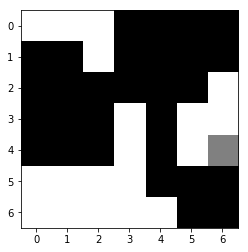

((2, 6), (4, 6)): n_v:  3084 q_all:-0.614166 q:-0.171101 q_m:-0.026449 p:0.261430
((6, 4), (4, 6)): n_v:   382 q_all:-0.676852 q:-0.675762 q_m:-0.026449 p:0.110649
((3, 5), (4, 6)): n_v:   162 q_all:-1.000000 q:+5.000000 q_m:-0.018367 p:0.218114
-1 's turn
one move takes time(s):  0.037696123123168945
no. of data collected:  8


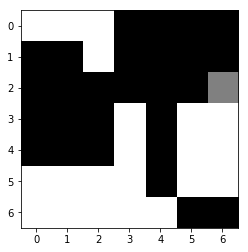

((1, 5), (2, 6)): n_v:  2332 q_all:+1.000000 q:+5.000000 q_m:+0.088898 p:0.259840
((0, 6), (2, 6)): n_v:  1168 q_all:+1.000000 q:+5.000000 q_m:+0.073469 p:0.130157
((0, 5), (2, 6)): n_v:   509 q_all:+1.000000 q:+5.000000 q_m:+0.073469 p:0.056763
((0, 4), (2, 6)): n_v:    13 q_all:+0.066091 q:+0.078672 q_m:+0.073469 p:0.035359
((4, 4), (2, 6)): n_v:     5 q_all:+0.208218 q:+0.047497 q_m:+0.073469 p:0.011187
((1, 4), (2, 6)): n_v:     1 q_all:+0.101453 q:+0.185405 q_m:+0.073469 p:0.004117
((3, 4), (2, 6)): n_v:     1 q_all:+0.086213 q:+0.124445 q_m:+0.073469 p:0.005068
((2, 4), (2, 6)): n_v:     0 q_all:-0.002605 q:-0.230830 q_m:+0.073469 p:0.002198
this self play has 61 steps, time elapsed 60.33850073814392
winner is -1.0
episode 8 finished
episode 9 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.16326022148132324
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.19876956939697266
no. 

one move takes time(s):  0.6233372688293457
no. of data collected:  8
1 's turn
one move takes time(s):  0.5155942440032959
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5844295024871826
no. of data collected:  8
1 's turn
one move takes time(s):  0.7799665927886963
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8165414333343506
no. of data collected:  8
1 's turn
one move takes time(s):  0.8131494522094727
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9941396713256836
no. of data collected:  8
1 's turn
one move takes time(s):  0.6207859516143799
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0457262992858887
no. of data collected:  8
1 's turn
one move takes time(s):  0.7958736419677734
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1415834426879883
no. of data collected:  8
1 's turn
one move takes time(s):  0.8461995124816895
no. of data collected:  8
-1 's turn
one move



This is a random move


one move takes time(s):  0.34102964401245117
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.001871109008789
no. of data collected:  8
-1 's turn
one move takes time(s):  0.854177713394165
no. of data collected:  8
1 's turn
one move takes time(s):  0.6853797435760498
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.8782668113708496
no. of data collected:  8
1 's turn
one move takes time(s):  0.3835582733154297
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6988277435302734
no. of data collected:  8
1 's turn
one move takes time(s):  0.5639219284057617
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.4119598865509033
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5724372863769531
no. of data collected:  8
-1 's turn
one move takes time(s):  0.49625492095947266
no. of data collected

one move takes time(s):  0.033035993576049805
no. of data collected:  8
-1 's turn
one move takes time(s):  0.03583049774169922
no. of data collected:  8
this self play has 63 steps, time elapsed 54.266236782073975
winner is -1.0
episode 12 finished
episode 13 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.1595296859741211
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.19420409202575684
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.2519059181213379
no. of data collected:  8
1 's turn
one move takes time(s):  0.2784121036529541
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.34681034088134766
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.42968177795410156
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.545329809188

one move takes time(s):  1.6167001724243164
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.479311227798462
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.5735044479370117
no. of data collected:  8
1 's turn
one move takes time(s):  1.5275471210479736
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.190976858139038
no. of data collected:  8
1 's turn
one move takes time(s):  1.757375717163086
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9307711124420166
no. of data collected:  8
1 's turn
one move takes time(s):  1.622614860534668
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8337085247039795
no. of data collected:  8
1 's turn
one move takes time(s):  1.1828079223632812
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6654410362243652
no. of data collected:  8
1 's turn
one move takes time(s):  1.12292289733886



This is a random move


one move takes time(s):  1.1243300437927246
no. of data collected:  8
1 's turn
one move takes time(s):  0.9253418445587158
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.7870841026306152
no. of data collected:  8
1 's turn
one move takes time(s):  1.0561859607696533
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5897808074951172
no. of data collected:  8
1 's turn
one move takes time(s):  0.8453295230865479
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.3606390953063965
no. of data collected:  8
1 's turn
one move takes time(s):  0.5986950397491455
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2960324287414551
no. of data collected:  8
1 's turn
one move takes time(s):  0.30674242973327637
no. of data collected:  8
-1 's turn
one move takes time(s):  0.35375213623046875
no. of data collected:  8
1 's turn
one move 

7509/7509 [==============================] - 1s 93us/step - loss: 2.9009 - activation_77_loss: 2.8562 - dense_39_loss: 0.0016 - val_loss: 2.7847 - val_activation_77_loss: 2.7314 - val_dense_39_loss: 0.0102
Epoch 30/512
7509/7509 [==============================] - 1s 94us/step - loss: 2.9000 - activation_77_loss: 2.8554 - dense_39_loss: 0.0015 - val_loss: 2.7837 - val_activation_77_loss: 2.7302 - val_dense_39_loss: 0.0103
Epoch 31/512
7509/7509 [==============================] - 1s 92us/step - loss: 2.8990 - activation_77_loss: 2.8546 - dense_39_loss: 0.0014 - val_loss: 2.7846 - val_activation_77_loss: 2.7311 - val_dense_39_loss: 0.0104
Epoch 32/512
7509/7509 [==============================] - 1s 94us/step - loss: 2.8986 - activation_77_loss: 2.8540 - dense_39_loss: 0.0014 - val_loss: 2.7877 - val_activation_77_loss: 2.7335 - val_dense_39_loss: 0.0111
Epoch 33/512
7509/7509 [==============================] - 1s 92us/step - loss: 2.8979 - activation_77_loss: 2.8532 - dense_39_loss: 0.001

7509/7509 [==============================] - 1s 93us/step - loss: 2.8822 - activation_77_loss: 2.8388 - dense_39_loss: 9.0866e-04 - val_loss: 2.7941 - val_activation_77_loss: 2.7397 - val_dense_39_loss: 0.0119
Epoch 00066: early stopping
saving files


start testing against greedy
####               ####
#### start testing ####
due to time lim, final rollout times:  0 time elapsed:  13.059368371963501
testing took time:  85.36313104629517
43.888888888888886



                        win ratio of Q is 0.036 





####               ####
#### start testing ####
due to time lim, final rollout times:  0 time elapsed:  10.495465278625488
testing took time:  98.59846568107605
59.9



                        win ratio of P is 0.36 





episode 15 finished
episode 16 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.1701505184173584
no. of data collected:  8
1 's turn
one move takes time(s):  0.19678163528442383
no. of data collect

one move takes time(s):  0.7783176898956299
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0219483375549316
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7271161079406738
no. of data collected:  8
-1 's turn
one move takes time(s):  1.184021234512329
no. of data collected:  8
1 's turn
one move takes time(s):  0.7983944416046143
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.1206459999084473
no. of data collected:  8
1 's turn
one move takes time(s):  0.8870081901550293
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9464292526245117
no. of data collected:  8
1 's turn
one move takes time(s):  0.8217873573303223
no. of data collected:  8
-1 's turn
one move takes time(s):  1.115612268447876
no. of data collected:  8
1 's turn
one move takes time(s):  0.6365399360656738
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9727702140808105
no. of data collecte

one move takes time(s):  0.2886319160461426
no. of data collected:  8
1 's turn
one move takes time(s):  0.40053677558898926
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3665933609008789
no. of data collected:  8
1 's turn
one move takes time(s):  0.22771501541137695
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.2683827877044678
no. of data collected:  8
1 's turn
one move takes time(s):  0.19005751609802246
no. of data collected:  8
-1 's turn
one move takes time(s):  0.21793484687805176
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.20857739448547363
no. of data collected:  8
-1 's turn
one move takes time(s):  0.16656208038330078
no. of data collected:  8
1 's turn
one move takes time(s):  0.11333441734313965
no. of data collected:  8
-1 's turn
one move takes time(s):  0.08473324775695801
no. of data collected:  8
1 's turn
one move takes time(s):  0.07793903350830078
no. of dat



This is a random move


one move takes time(s):  0.63623046875
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5573418140411377
no. of data collected:  8
1 's turn
one move takes time(s):  0.7598488330841064
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7232632637023926
no. of data collected:  8
1 's turn
one move takes time(s):  1.0260028839111328
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9537572860717773
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0847992897033691
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7695183753967285
no. of data collected:  8
1 's turn
one move takes time(s):  1.2022764682769775
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0261528491973877
no. of data collected:  8
1 's turn
one move takes time(s):  1.1703524589538574
no. of data collected:  8
-1 's turn
one move takes time(s):  1.44212889671325

9000/9000 [==============================] - 1s 94us/step - loss: 2.8474 - activation_77_loss: 2.8036 - dense_39_loss: 0.0016 - val_loss: 2.8879 - val_activation_77_loss: 2.8432 - val_dense_39_loss: 0.0025
Epoch 13/512
9000/9000 [==============================] - 1s 92us/step - loss: 2.8470 - activation_77_loss: 2.8032 - dense_39_loss: 0.0016 - val_loss: 2.8877 - val_activation_77_loss: 2.8426 - val_dense_39_loss: 0.0029
Epoch 14/512
9000/9000 [==============================] - 1s 92us/step - loss: 2.8457 - activation_77_loss: 2.8020 - dense_39_loss: 0.0015 - val_loss: 2.8884 - val_activation_77_loss: 2.8434 - val_dense_39_loss: 0.0028
Epoch 15/512
9000/9000 [==============================] - 1s 94us/step - loss: 2.8457 - activation_77_loss: 2.8020 - dense_39_loss: 0.0016 - val_loss: 2.8873 - val_activation_77_loss: 2.8427 - val_dense_39_loss: 0.0025
Epoch 16/512
9000/9000 [==============================] - 1s 92us/step - loss: 2.8448 - activation_77_loss: 2.8011 - dense_39_loss: 0.001

9000/9000 [==============================] - 1s 92us/step - loss: 2.8328 - activation_77_loss: 2.7904 - dense_39_loss: 9.8319e-04 - val_loss: 2.8902 - val_activation_77_loss: 2.8464 - val_dense_39_loss: 0.0025
Epoch 50/512
9000/9000 [==============================] - 1s 93us/step - loss: 2.8323 - activation_77_loss: 2.7901 - dense_39_loss: 8.1154e-04 - val_loss: 2.8893 - val_activation_77_loss: 2.8457 - val_dense_39_loss: 0.0022
Epoch 51/512
9000/9000 [==============================] - 1s 92us/step - loss: 2.8325 - activation_77_loss: 2.7903 - dense_39_loss: 8.7259e-04 - val_loss: 2.8890 - val_activation_77_loss: 2.8454 - val_dense_39_loss: 0.0023
Epoch 52/512
9000/9000 [==============================] - 1s 91us/step - loss: 2.8320 - activation_77_loss: 2.7898 - dense_39_loss: 8.6852e-04 - val_loss: 2.8896 - val_activation_77_loss: 2.8460 - val_dense_39_loss: 0.0022
Epoch 53/512
9000/9000 [==============================] - 1s 93us/step - loss: 2.8318 - activation_77_loss: 2.7896 - dens

one move takes time(s):  0.8885302543640137
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7338559627532959
no. of data collected:  8
1 's turn
one move takes time(s):  1.1791918277740479
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0452401638031006
no. of data collected:  8
1 's turn
one move takes time(s):  1.3503453731536865
no. of data collected:  8
-1 's turn
one move takes time(s):  1.159630298614502
no. of data collected:  8
1 's turn
one move takes time(s):  1.695835828781128
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4295997619628906
no. of data collected:  8
1 's turn
one move takes time(s):  1.4633758068084717
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5035865306854248
no. of data collected:  8
1 's turn
one move takes time(s):  1.52305269241333
no. of data collected:  8
-1 's turn
one move takes time(s):  1.35103178024292
no. of data collected:  8
1 's turn
one move takes time(s):  1.6174044609069

In [ ]:
player._mode = 2 # hybrid q mode
player.reinforcement_learning(episode=600, left_space_max=None, rollout_times=2000, train_interval=5, \
                              life_span=15, t_lim=6, self_play_verbose=False)

In [64]:
player.tester(Q=True, P=True, BOTH=False, mode=0, times=500, dep_lim=1, rollout_times=400, verbose=False)

####               ####
#### start testing ####
due to time lim, final rollout times:  0 time elapsed:  28.518978357315063
testing took time:  237.3358278274536
67.60493827160494



                        win ratio of Q is 0.486 





####               ####
#### start testing ####
testing took time:  40.238956928253174



                        win ratio of P is 0 







{'P': 0, 'Q': 0.486}

In [ ]:
player.reset()
player.tester(P=True, Q=True, times=500)
for i in range(5):
    player.reinforcement_pretraining(rounds=500)
    player.reset()
    player.tester(P=True, Q=True, times=500)

In [ ]:
w = player._network._model.get_weights()
fig = plt.gcf()
print(w[0].shape)
show_w = w[0]
for in_layer in range(6):
    for out_layer in range(64):
        print('in', in_layer, 'out', out_layer)
        plt.imshow(show_w[..., in_layer, out_layer], cmap='gray')
        plt.pause(0.1)